> # 회귀분석 프로젝트 - 양준, 이희재, 오진경, 윤예슬


> # 회귀분석 프로젝트 : 온도 추정 경진대회
- ### 데이콘 온도추정 경진대회 데이터 활용
![title](dacon.png)

> ### 목차
- **데이터 설명**
- **분석과정**
- **데이터 전처리**
- **KFold 검증**
    - Y00 ~ Y17
- **Lasso, Ridge, EN 정규화**
    - Y18
- **전체 데이터를 활용한 Y18모델**
- **+) 머신러닝 활용**

> ### 목표 성능
- test MSE 3.5 이하로 만들기 -> 3.94
- 최종순위 20등 이내 -> 40위

> ## 데이터 설명
- 대전지역에서 측정한 실내외 19곳의 센서데이터와 주변 지역의 기상청 공공데이터를 semi-비식별화하여 제공합니다. 
    - 센서는 온도를 측정하였습니다. 
    - 모든 데이터는 시간 순으로 정렬 되어 있으며 10분 단위 데이터 입니다. 
    - 예측 대상(target variable)은 Y18입니다. 
    
> ### train.csv 
    - 30일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y00~Y17)
    - 이후 3일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y18)
> ### test.csv 
    - train.csv 기간 이후 80일 간의 기상청 데이터 (X00~X39)
> ### sample_submission.csv
    - 제출 양식 예시

- **각 위치에서 기온, 누적강수량, 풍속, 풍향, 해면기압, 현지기압, 일사량, 습도 모두 측정**
![title](proj.png)

![title](datadesc.png)

> ## 분석과정

![title](data.png)
`id` : 시간(10분 단위)  
`X00 ~ X39` : 기상청 관측 데이터  
`'X00','X07','X28','X31','X32'` : 기온  
`"X01","X06","X22","X27","X29"` : 현지기압 (실제 위치에서의 기압)
`"X02","X03","X18","X24","X26"` : 풍속  
`"X04","X10","X21","X36","X39"` : 일일 누적강수량  
`"X05","X08","X09","X23","X33"` : 해면기압 (높이를 같다고 가정했을 때 기압)  
`"X11","X34"` : 일일 누적일사량 - X14, X16, X19는 고장  
`"X12","X20","X30","X37","X38"` : 습도
`'Y00','Y01','Y02','Y03','Y04','Y05','Y06','Y07','Y08','Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y16','Y17'` : 센서(기온)

![title](data2.png)


> ## 필요한 패키지 import


```
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer
from sklearn.linear_model import Lasso, Ridge
%matplotlib inline
```

> ## 데이터 불러오기

In [19]:
df= pd.read_csv('datas/train.csv', encoding='utf-8')
df

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,...,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,...,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,...,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,...,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,...,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,4747,19.9,987.6,0.9,0.8,0.0,1006.9,987.7,21.7,1007.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4748,4748,19.9,987.6,0.5,0.7,0.0,1006.8,987.7,21.6,1007.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4749,4749,19.7,987.7,0.9,0.6,0.0,1006.9,987.6,21.4,1007.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4750,4750,19.4,987.7,0.9,0.8,0.0,1006.9,987.8,21.3,1007.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5


> ## 데이터 종류에 따라 나누기

In [10]:
temperature_name = ['X00','X07','X28','X31','X32'] # 기온
localpress_name  = ["X01","X06","X22","X27","X29"] #현지기압
speed_name       = ["X02","X03","X18","X24","X26"] #풍속
water_name       = ["X04","X10","X21","X36","X39"] #일일 누적강수량
press_name       = ["X05","X08","X09","X23","X33"] #해면기압
sun_name         = ["X11","X34"] #일일 누적일사량
humidity_name    = ["X12","X20","X30","X37","X38"] #습도
direction_name   = ["X13","X15","X17","X25","X35"] #풍향
sensor_name = ['Y00','Y01','Y02','Y03','Y04','Y05','Y06','Y07','Y08','Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y16','Y17']

> ## 시간 컬럼 추가

In [20]:
hour= pd.Series((df.index%144/6).astype(int))
df['hour'] = hour

> ## 데이터 전처리
- ### 풍향
    - 북동(0), 남동(1), 남서(2), 북서(3)로 **카테고리 변수**로 변경
- ### 강수량
    - 현재 데이터는 누적강수량 데이터로 측정시각 이전에 내린 강수량의 합이다.
    - 현재 온도에 미래의 강수량이 영향을 주지 못하므로, 온도 측정 시각의 누적강수량에서 이전 온도 측정 시각의 누적강수량을 빼서 계산하였다.
    - 실수형 데이터로 예측모델을 만든 결과보다 카테고리형 데이터로 예측모델을 만들었을 경우 성능이 더 좋아 **카테고리 변수**로 바꾸었다.
    - 강수량에 따라 0, 1, 2, 3으로 나눈 모델과 강수가 있었을 경우 1, 없었을 경우 0으로 나눈 모델 중 후자가 더 성능이 좋았다.

In [21]:
for x in direction_name:
    df[x] = df[x].apply(lambda x: 0 if x < 90 else 1 if x < 180 else 2 if x < 270 else 3)
# 북동 : 0 / 남동 : 1 / 남서 : 2 / 북서 : 3

for x in water_name:
    for i in range(1, len(x)):
        df[x].loc[i] = df[x].loc[i] - df[x].loc[i-1]
        
for x in water_name:
    df[x] = df[x].apply(lambda x: 0 if x == 0 else 1)

> ## 이전 30일의 데이터 - Y18이 없음

In [22]:
df1 = df.loc[:4319]

In [23]:
df1.dropna(axis=1, inplace=True)

In [24]:
df1

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,hour
0,0,9.7,988.8,1.2,0.6,0,1009.3,989.6,12.2,1009.9,...,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,0
1,1,9.3,988.9,1.7,1.9,0,1009.3,989.6,12.1,1010.0,...,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,0
2,2,9.4,989.0,1.1,2.3,0,1009.2,989.7,12.1,1010.1,...,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,0
3,3,9.4,988.9,1.5,0.7,0,1009.2,989.6,12.0,1010.0,...,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,0
4,4,9.2,988.9,0.8,1.7,0,1009.2,989.7,12.0,1010.1,...,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,4315,19.5,987.8,1.7,0.4,0,1007.8,988.0,21.3,1007.8,...,19.5,20.0,19.0,20.5,20.5,20.0,20.0,20.5,20.0,23
4316,4316,19.3,987.7,2.1,0.9,0,1007.8,988.1,21.3,1008.0,...,19.5,20.0,19.0,20.5,20.5,20.0,19.5,20.5,19.5,23
4317,4317,19.5,987.8,0.9,1.3,0,1007.8,988.3,21.2,1008.1,...,19.5,20.0,19.0,20.0,20.0,19.5,19.5,20.0,19.0,23
4318,4318,20.0,987.8,1.4,0.5,0,1007.8,988.3,21.1,1008.1,...,19.5,20.0,18.5,20.0,20.0,19.5,19.5,20.0,19.0,23


> ## 이전 30일의 기상청 데이터(X00 ~ X39)

In [25]:
X_30s = df1.drop(columns=sensor_name)
X_30s.drop(columns=['X14', 'X16', 'X19', 'id'], inplace=True)
X_30s

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X31,X32,X33,X34,X35,X36,X37,X38,X39,hour
0,9.7,988.8,1.2,0.6,0,1009.3,989.6,12.2,1009.9,1009.8,...,8.2,10.7,1010.1,0.00,2,0,77.2,62.6,0,0
1,9.3,988.9,1.7,1.9,0,1009.3,989.6,12.1,1010.0,1009.9,...,8.3,10.3,1010.1,0.00,2,0,77.3,63.5,0,0
2,9.4,989.0,1.1,2.3,0,1009.2,989.7,12.1,1010.1,1010.1,...,8.0,9.7,1010.0,0.00,2,0,77.3,63.9,0,0
3,9.4,988.9,1.5,0.7,0,1009.2,989.6,12.0,1010.0,1010.0,...,7.7,9.4,1010.1,0.00,2,0,77.5,64.5,0,0
4,9.2,988.9,0.8,1.7,0,1009.2,989.7,12.0,1010.1,1010.0,...,7.4,9.4,1010.1,0.00,1,0,78.0,65.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,19.5,987.8,1.7,0.4,0,1007.8,988.0,21.3,1007.8,1007.5,...,18.8,19.4,1008.2,16.68,3,0,82.3,74.3,0,23
4316,19.3,987.7,2.1,0.9,0,1007.8,988.1,21.3,1008.0,1007.4,...,18.6,18.5,1008.4,16.68,3,0,82.4,74.8,0,23
4317,19.5,987.8,0.9,1.3,0,1007.8,988.3,21.2,1008.1,1007.5,...,18.4,19.1,1008.4,16.68,3,0,82.8,75.4,0,23
4318,20.0,987.8,1.4,0.5,0,1007.8,988.3,21.1,1008.1,1007.5,...,18.2,19.0,1008.4,16.68,3,0,82.8,75.8,0,23


> ## 이전 30일의 센서 데이터(Y00 ~ Y17)

In [26]:
sensor = df1[sensor_name]
sensor

,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17
0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0
1,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0
2,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5
3,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5
4,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,22.0,22.5,22.5,26.0,26.0,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,20.0,20.5,20.0
4316,22.0,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,19.5,20.5,19.5
4317,21.5,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.0,20.0,19.5,19.5,20.0,19.0
4318,21.5,22.0,22.0,25.5,25.5,20.5,20.0,20.0,20.0,19.5,20.0,18.5,20.0,20.0,19.5,19.5,20.0,19.0


In [27]:
formulas = temperature_name + localpress_name + humidity_name + sun_name + speed_name
formulas = ['scale({})'.format(x) for x in formulas]
formulas

['scale(X00)',
 'scale(X07)',
 'scale(X28)',
 'scale(X31)',
 'scale(X32)',
 'scale(X01)',
 'scale(X06)',
 'scale(X22)',
 'scale(X27)',
 'scale(X29)',
 'scale(X12)',
 'scale(X20)',
 'scale(X30)',
 'scale(X37)',
 'scale(X38)',
 'scale(X11)',
 'scale(X34)',
 'scale(X02)',
 'scale(X03)',
 'scale(X18)',
 'scale(X24)',
 'scale(X26)']

In [28]:
formulas2 = water_name + direction_name
formulas2.append('hour')
formulas2 = ['C({})'.format(x) for x in formulas2]
formulas2

['C(X04)',
 'C(X10)',
 'C(X21)',
 'C(X36)',
 'C(X39)',
 'C(X13)',
 'C(X15)',
 'C(X17)',
 'C(X25)',
 'C(X35)',
 'C(hour)']

In [29]:
formulas = formulas + formulas2

> ## OLS 식 , Y00 예측 모델만들기
- 스케일링, 카테고리 변수
- Y00을 포함한 Y00_df 생성

In [30]:
a = '+'.join(formulas)
a

'scale(X00)+scale(X07)+scale(X28)+scale(X31)+scale(X32)+scale(X01)+scale(X06)+scale(X22)+scale(X27)+scale(X29)+scale(X12)+scale(X20)+scale(X30)+scale(X37)+scale(X38)+scale(X11)+scale(X34)+scale(X02)+scale(X03)+scale(X18)+scale(X24)+scale(X26)+C(X04)+C(X10)+C(X21)+C(X36)+C(X39)+C(X13)+C(X15)+C(X17)+C(X25)+C(X35)+C(hour)'

In [31]:
Y00_df = pd.concat([X_30s, sensor['Y00']], axis=1)
Y00_df

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X32,X33,X34,X35,X36,X37,X38,X39,hour,Y00
0,9.7,988.8,1.2,0.6,0,1009.3,989.6,12.2,1009.9,1009.8,...,10.7,1010.1,0.00,2,0,77.2,62.6,0,0,12.5
1,9.3,988.9,1.7,1.9,0,1009.3,989.6,12.1,1010.0,1009.9,...,10.3,1010.1,0.00,2,0,77.3,63.5,0,0,12.5
2,9.4,989.0,1.1,2.3,0,1009.2,989.7,12.1,1010.1,1010.1,...,9.7,1010.0,0.00,2,0,77.3,63.9,0,0,12.0
3,9.4,988.9,1.5,0.7,0,1009.2,989.6,12.0,1010.0,1010.0,...,9.4,1010.1,0.00,2,0,77.5,64.5,0,0,12.0
4,9.2,988.9,0.8,1.7,0,1009.2,989.7,12.0,1010.1,1010.0,...,9.4,1010.1,0.00,1,0,78.0,65.0,0,0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,19.5,987.8,1.7,0.4,0,1007.8,988.0,21.3,1007.8,1007.5,...,19.4,1008.2,16.68,3,0,82.3,74.3,0,23,22.0
4316,19.3,987.7,2.1,0.9,0,1007.8,988.1,21.3,1008.0,1007.4,...,18.5,1008.4,16.68,3,0,82.4,74.8,0,23,22.0
4317,19.5,987.8,0.9,1.3,0,1007.8,988.3,21.2,1008.1,1007.5,...,19.1,1008.4,16.68,3,0,82.8,75.4,0,23,21.5
4318,20.0,987.8,1.4,0.5,0,1007.8,988.3,21.1,1008.1,1007.5,...,19.0,1008.4,16.68,3,0,82.8,75.8,0,23,21.5


> ## Y00 OLS Report

In [45]:
model1 = sm.OLS.from_formula("Y00 ~ scale(X00)+scale(X07)+scale(X28)+scale(X31)+scale(X32)+scale(X01)+scale(X06)+scale(X22)+scale(X27)+scale(X29)+scale(X12)+scale(X20)+scale(X30)+scale(X37)+scale(X38)+scale(X11)+scale(X34)+scale(X02)+scale(X03)+scale(X18)+scale(X24)+scale(X26)+C(X04)+C(X10)+C(X21)+C(X36)+C(X39)+C(X13)+C(X15)+C(X17)+C(X25)+C(X35)+C(hour)", Y00_df)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                    Y00   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     8823.
Date:                Sat, 18 Apr 2020   Prob (F-statistic):               0.00
Time:                        01:41:28   Log-Likelihood:                -1831.6
No. Observations:                4320   AIC:                             3795.
Df Residuals:                    4254   BIC:                             4216.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        21.9936      0.043    509.663

> ## KFold 검증

In [61]:
from sklearn.metrics import mean_squared_error
kfold = KFold(5, shuffle=True, random_state=13)

In [66]:
N = len(Y00_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y00_df.iloc[idx_train]
dfX_test = Y00_df.iloc[idx_test]

In [67]:
scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model0 = sm.OLS.from_formula("Y00 ~ 1 +" + a, data=dfX_train)
    result0 = model0.fit()
    
    pred = result0.predict(df_test)
    rss = ((df_test.Y00 - pred) ** 2).sum()
    tss = ((df_test.Y00 - df_test.Y00.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result0.rsquared, rsquared))

pred = result0.predict(dfX_test)
rss = ((dfX_test.Y00 - pred) ** 2).sum()
tss = ((dfX_test.Y00 - dfX_test.Y00.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.99272483, 검증 R2 = 0.99242741
학습 R2 = 0.99272483, 검증 R2 = 0.99215678
학습 R2 = 0.99272483, 검증 R2 = 0.99328929
학습 R2 = 0.99272483, 검증 R2 = 0.99281616
학습 R2 = 0.99272483, 검증 R2 = 0.99284578
0.9923736912649597


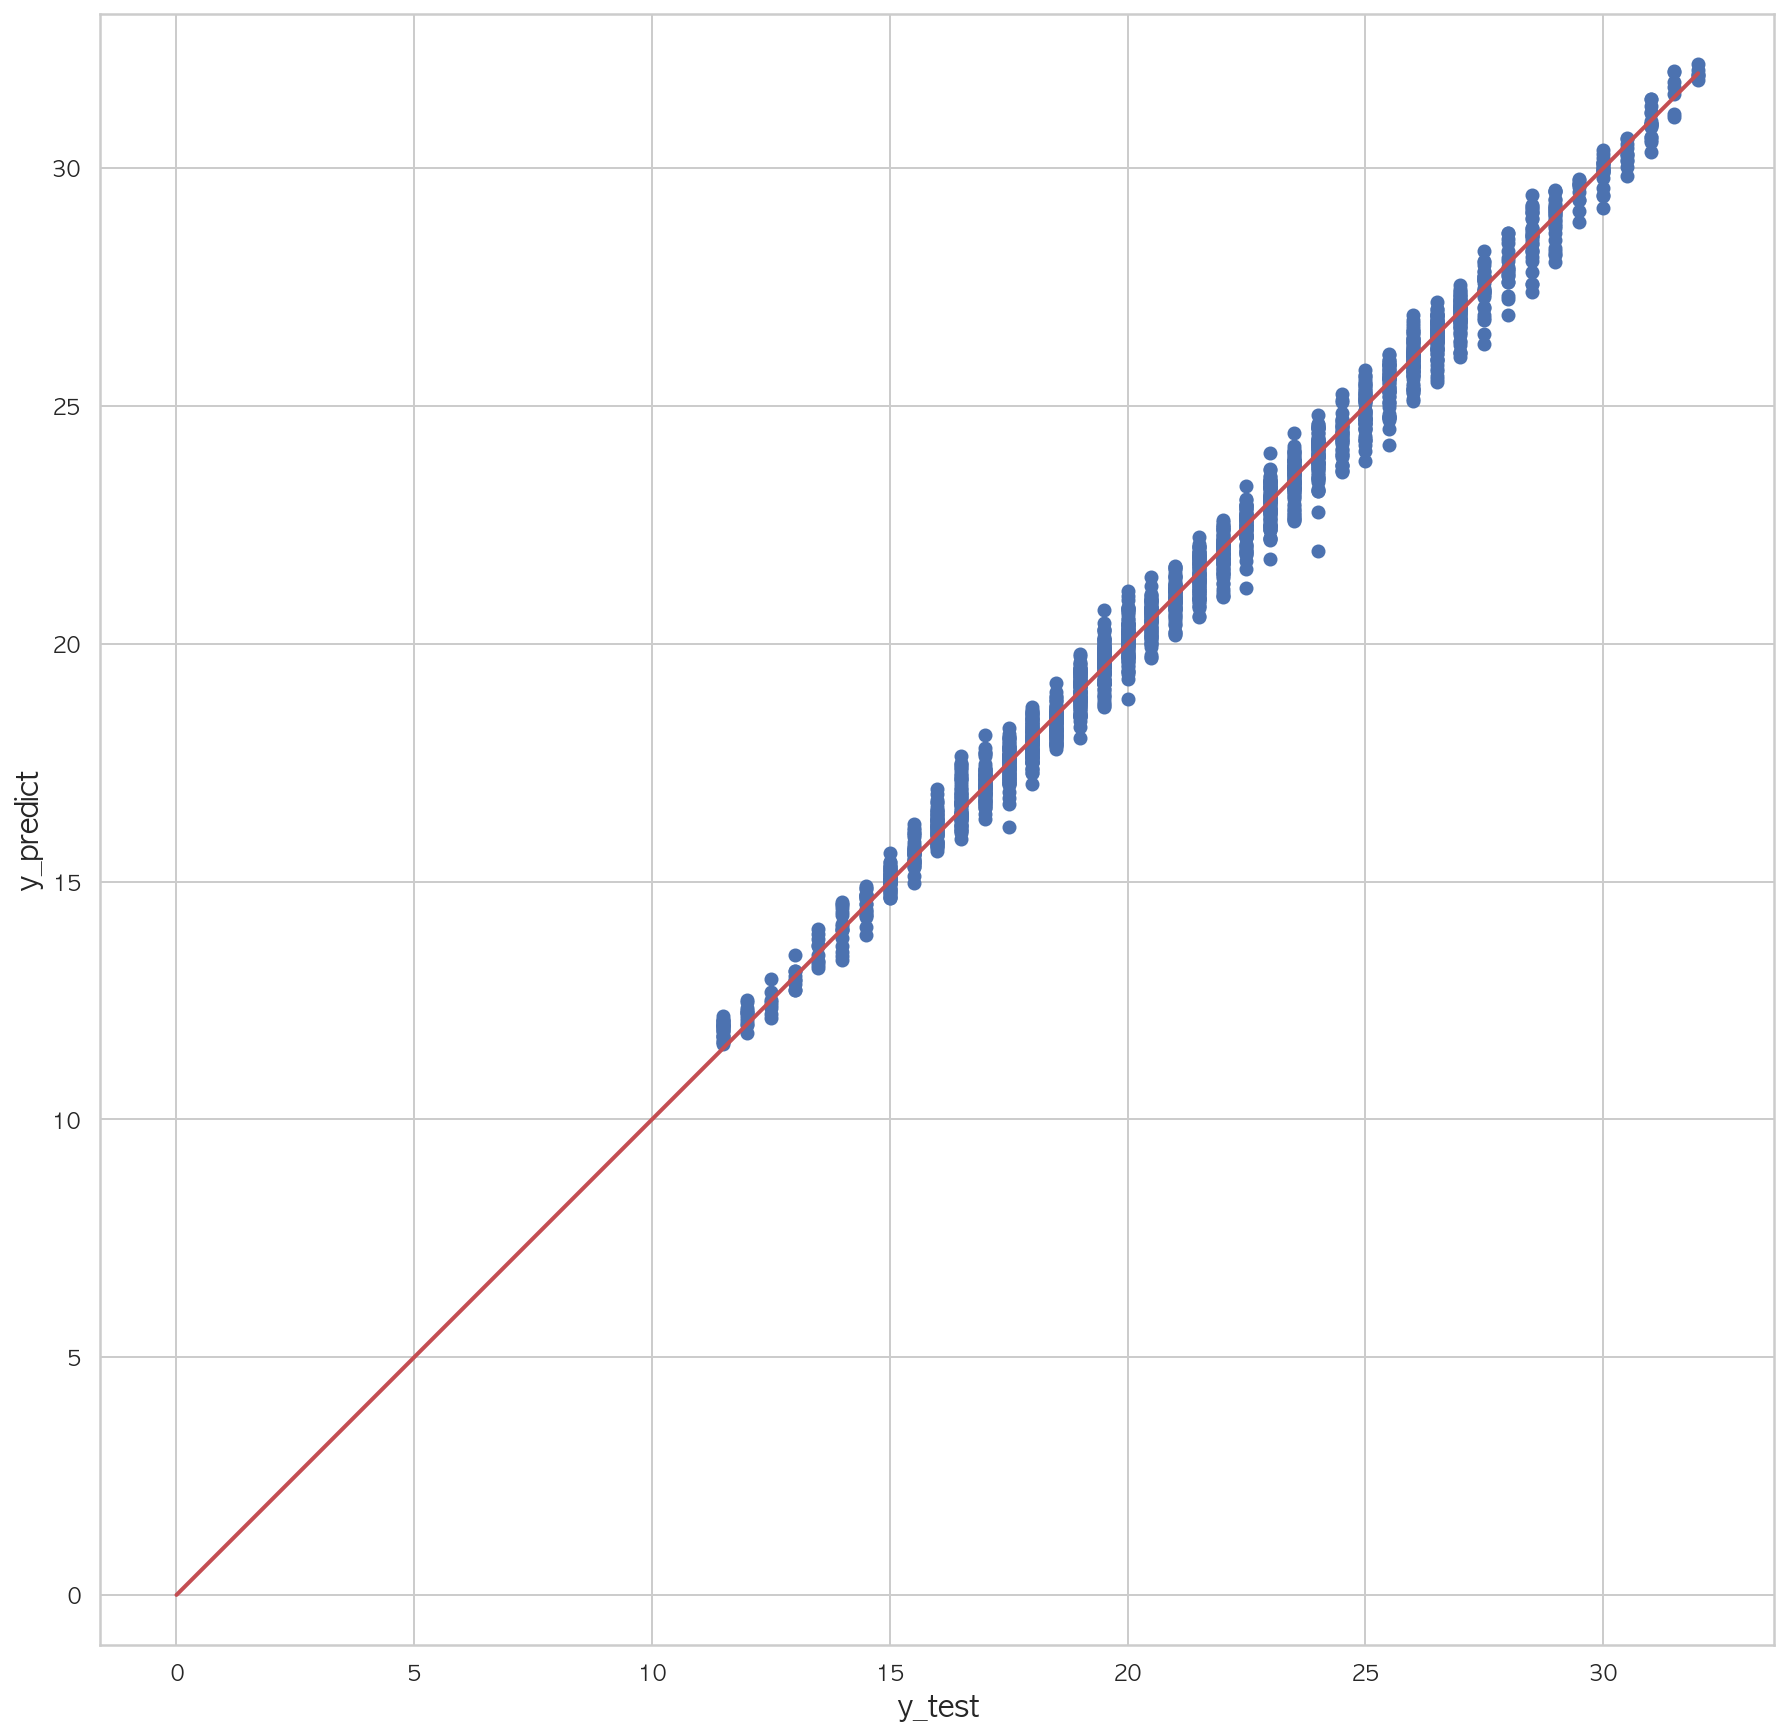

In [60]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y00'], pred)
plt.plot([0, dfX_test['Y00'].max()], [0, dfX_test['Y00'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

> ## 나머지 값들도 KFold 검증

In [68]:
Y01_df = pd.concat([X_30s, sensor['Y01']], axis=1)

N = len(Y01_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y01_df.iloc[idx_train]
dfX_test = Y01_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model1 = sm.OLS.from_formula("Y01 ~ 1 +" + a, data=dfX_train)
    result1 = model1.fit()
    
    pred = result1.predict(df_test)
    rss = ((df_test.Y01 - pred) ** 2).sum()
    tss = ((df_test.Y01 - df_test.Y01.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result1.rsquared, rsquared))
    
pred = result1.predict(dfX_test)
rss = ((dfX_test.Y01 - pred) ** 2).sum()
tss = ((dfX_test.Y01 - dfX_test.Y01.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.98413713, 검증 R2 = 0.98378369
학습 R2 = 0.98413713, 검증 R2 = 0.98328775
학습 R2 = 0.98413713, 검증 R2 = 0.98360291
학습 R2 = 0.98413713, 검증 R2 = 0.98524484
학습 R2 = 0.98413713, 검증 R2 = 0.98458787
0.9812739427374754


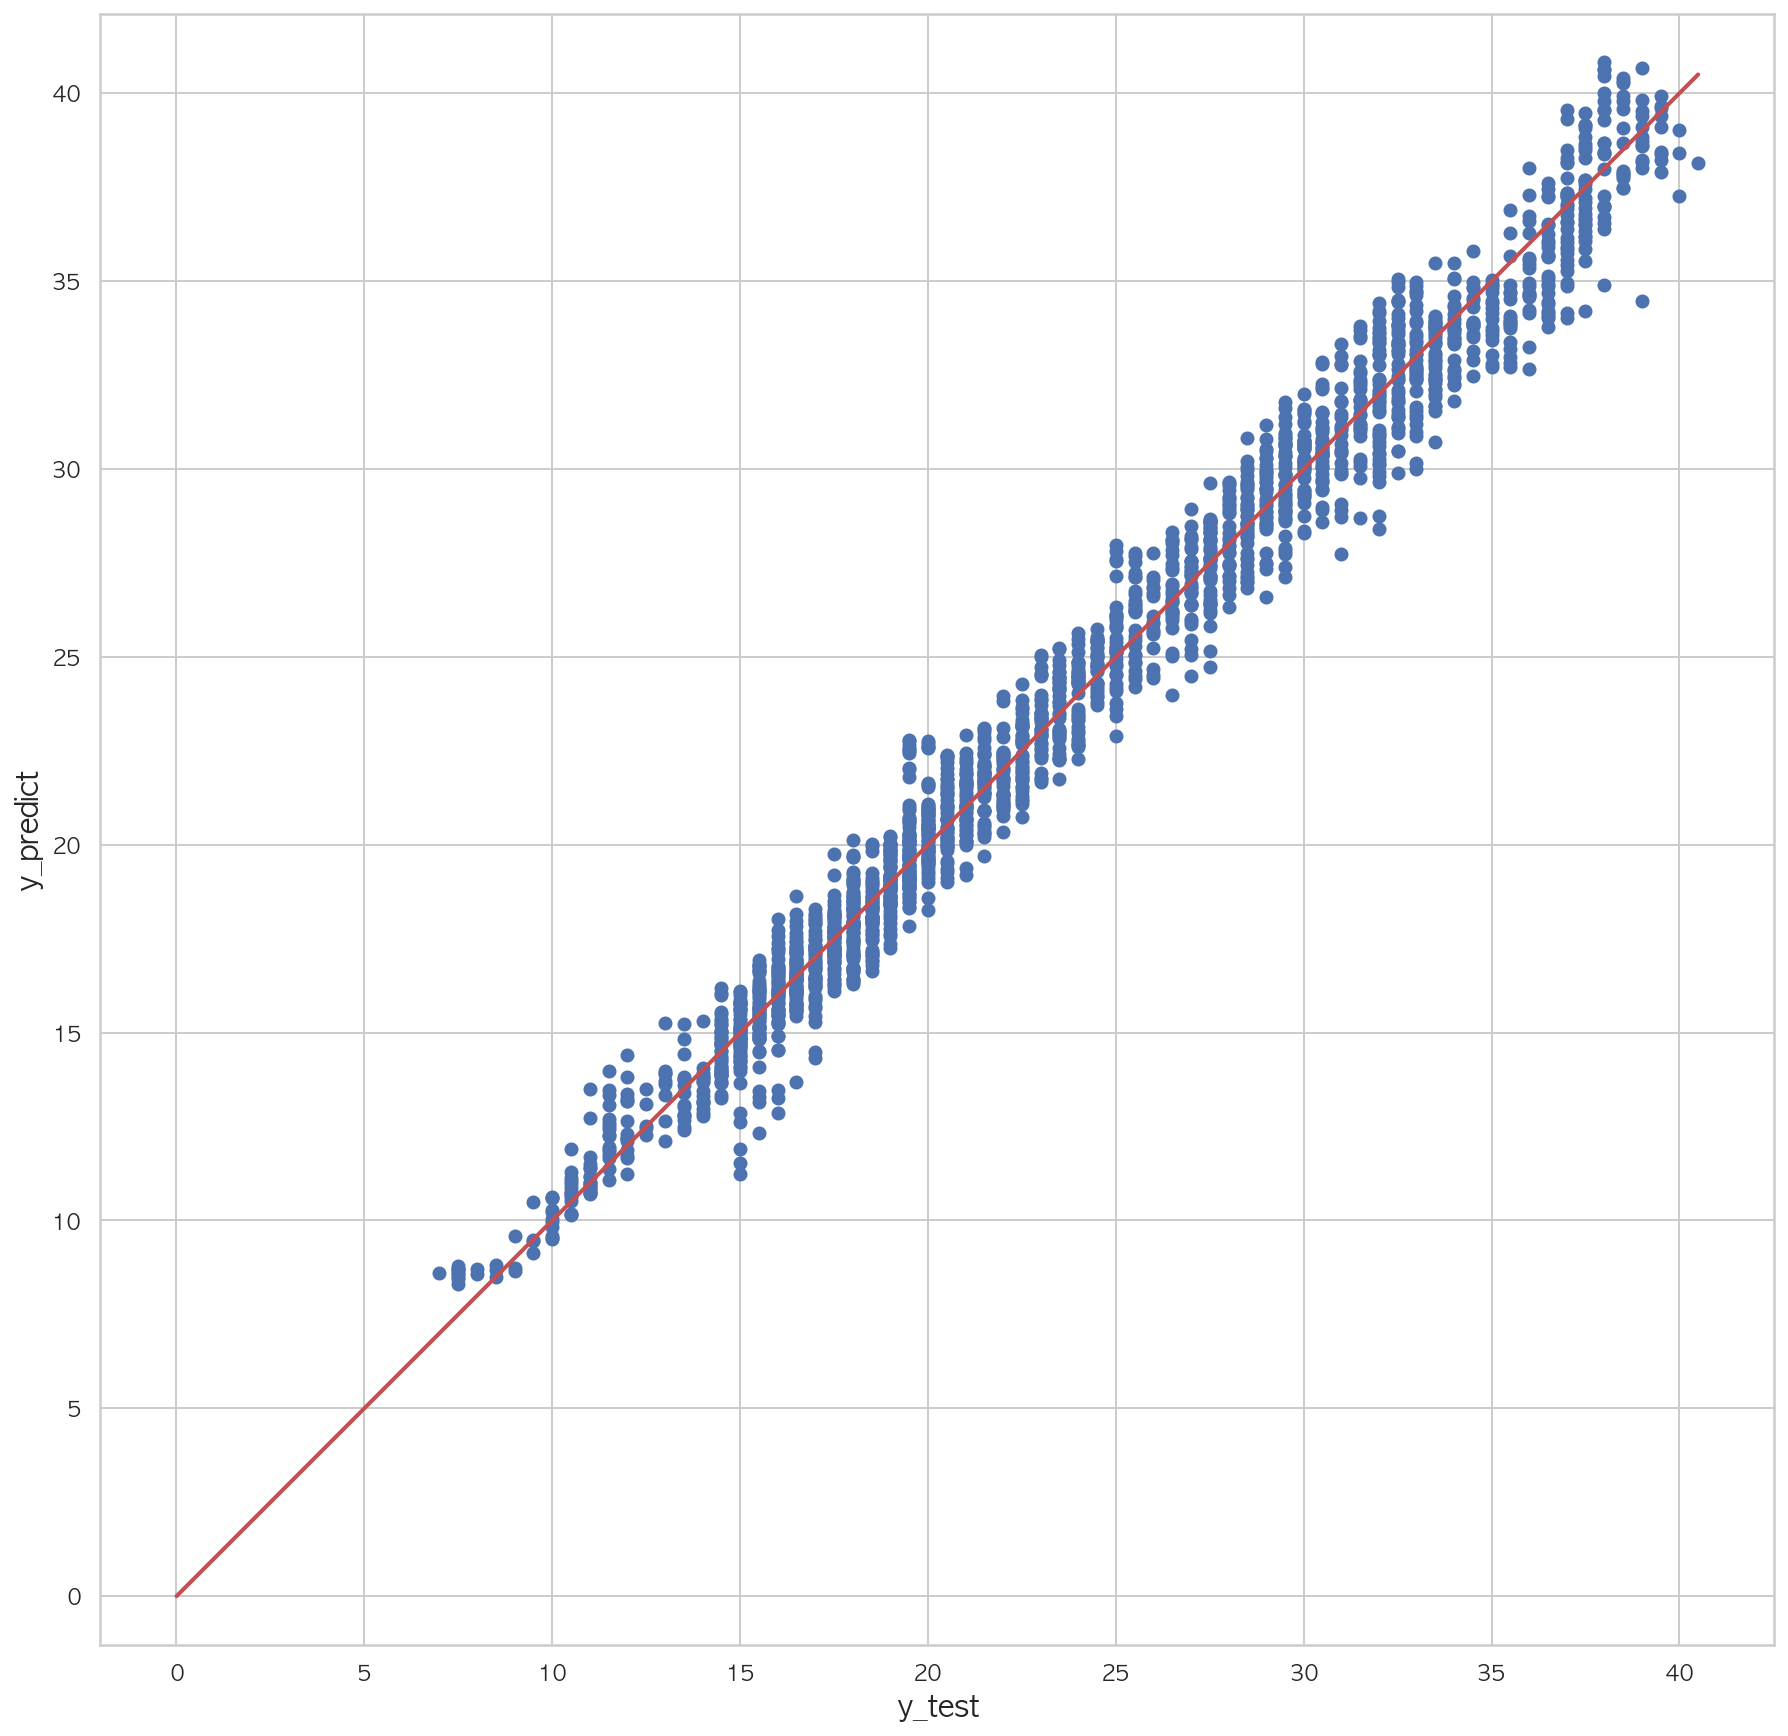

In [56]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y01'], pred)
plt.plot([0, dfX_test['Y01'].max()], [0, dfX_test['Y01'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [69]:
Y02_df = pd.concat([X_30s, sensor['Y02']], axis=1)

N = len(Y02_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y02_df.iloc[idx_train]
dfX_test = Y02_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model2 = sm.OLS.from_formula("Y02 ~ 1 +" + a, data=dfX_train)
    result2 = model2.fit()
    
    pred = result2.predict(df_test)
    rss = ((df_test.Y02 - pred) ** 2).sum()
    tss = ((df_test.Y02 - df_test.Y02.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result2.rsquared, rsquared))

pred = result2.predict(dfX_test)
rss = ((dfX_test.Y02 - pred) ** 2).sum()
tss = ((dfX_test.Y02 - dfX_test.Y02.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.98337319, 검증 R2 = 0.98398663
학습 R2 = 0.98337319, 검증 R2 = 0.98194591
학습 R2 = 0.98337319, 검증 R2 = 0.98332113
학습 R2 = 0.98337319, 검증 R2 = 0.98376697
학습 R2 = 0.98337319, 검증 R2 = 0.98364382
0.9813744364414267


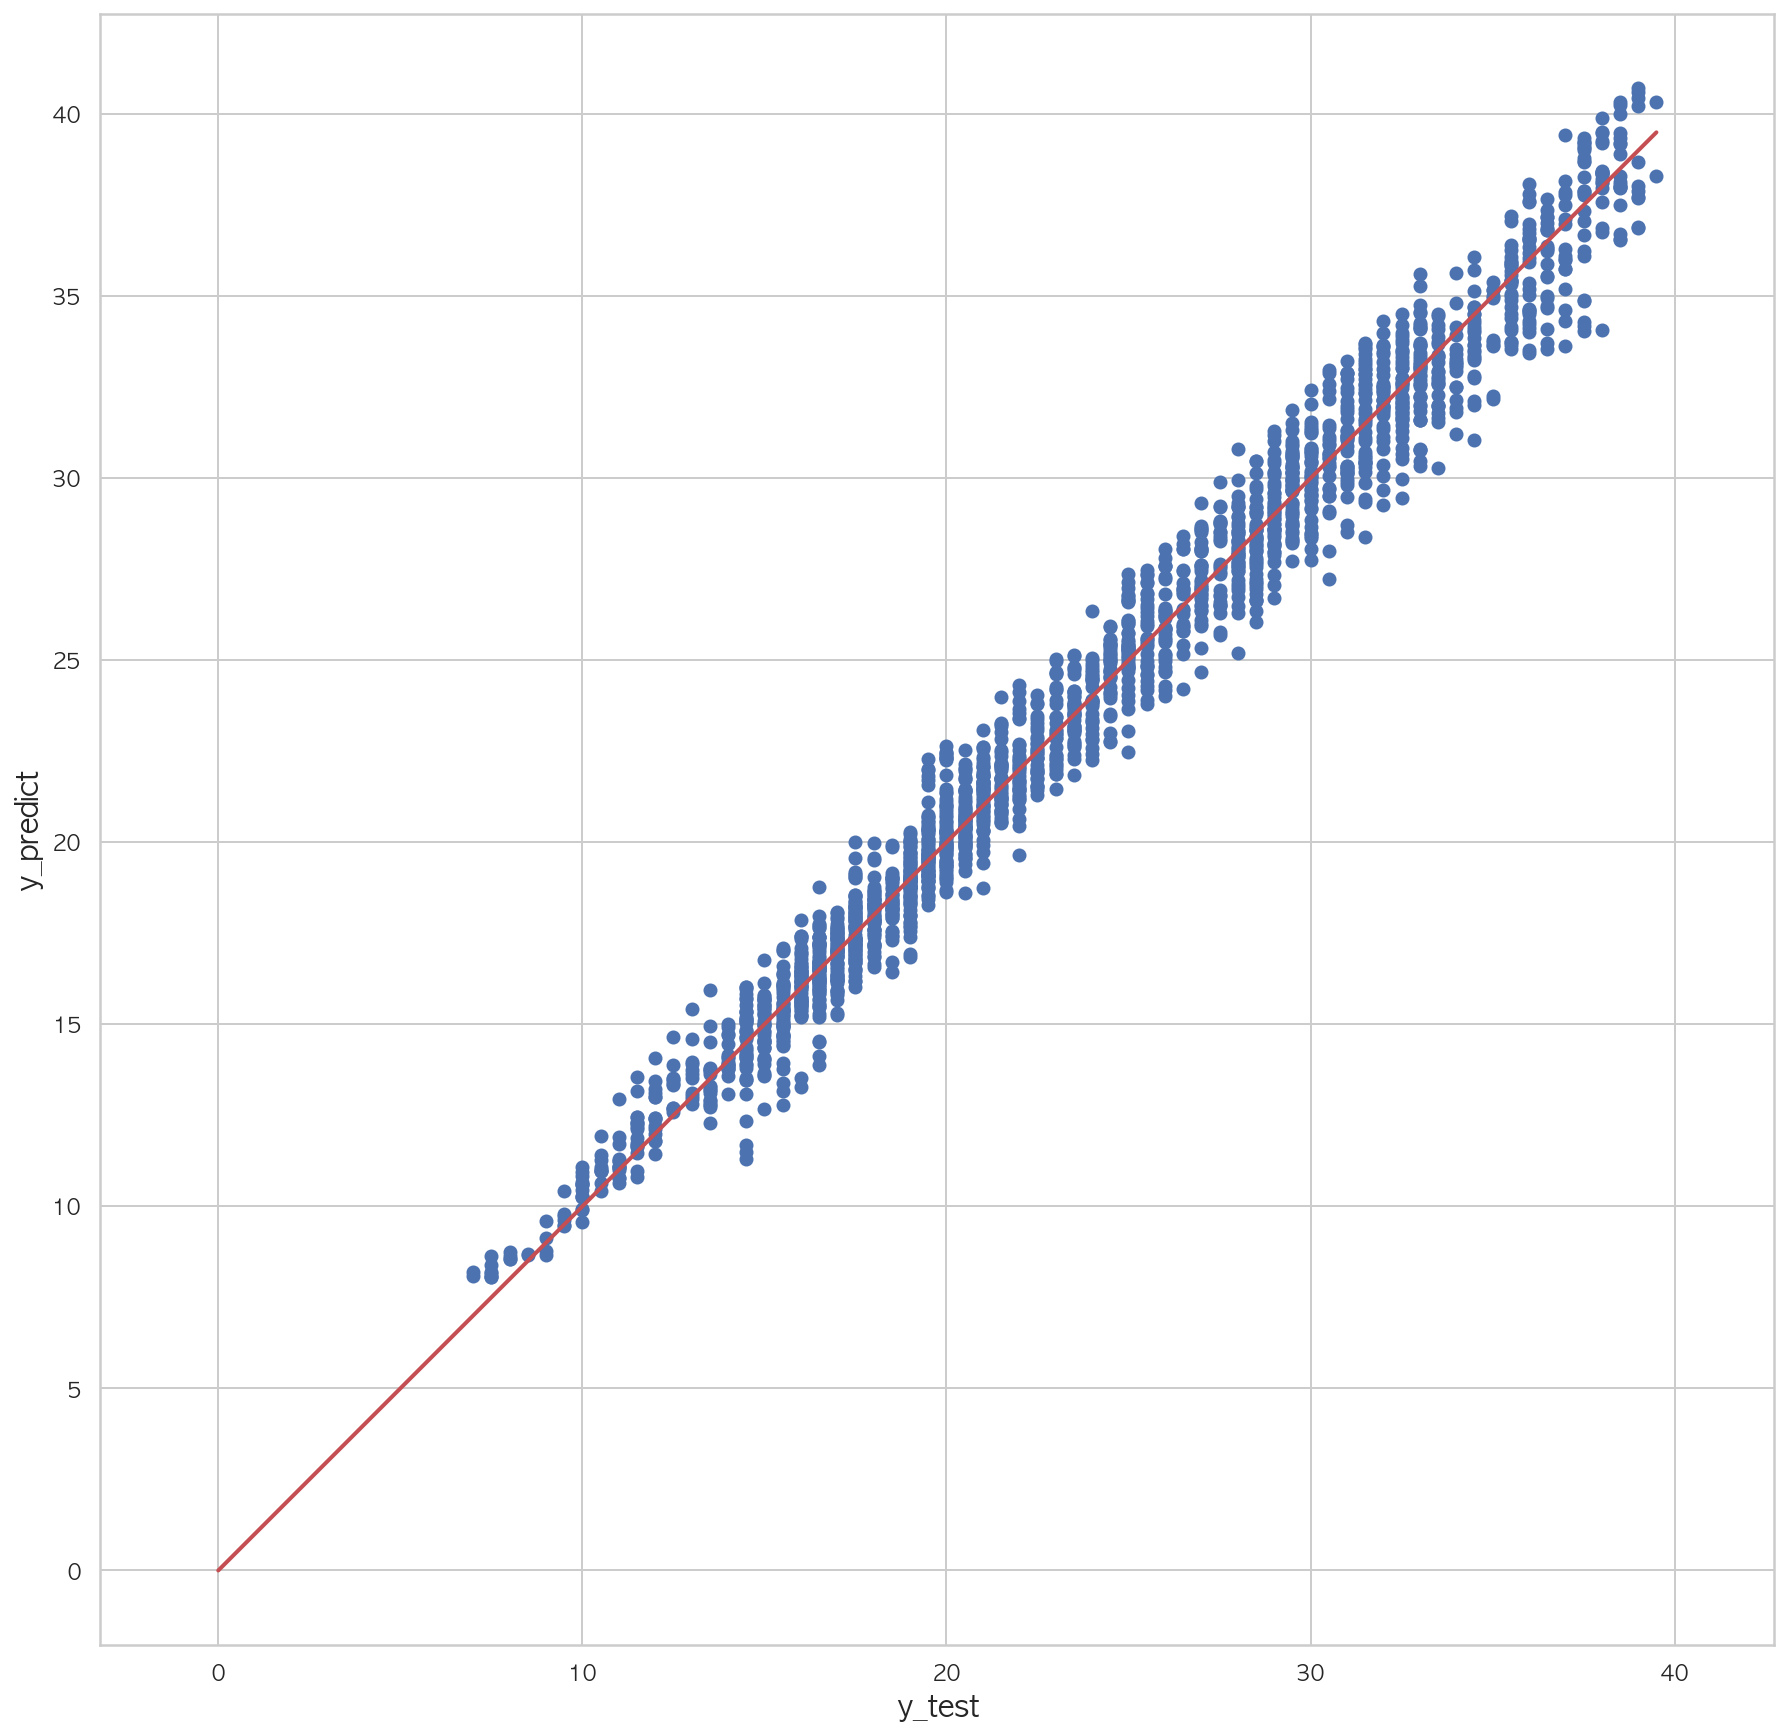

In [70]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y02'], pred)
plt.plot([0, dfX_test['Y02'].max()], [0, dfX_test['Y02'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [71]:
Y03_df = pd.concat([X_30s, sensor['Y03']], axis=1)

N = len(Y03_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y03_df.iloc[idx_train]
dfX_test = Y03_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model3 = sm.OLS.from_formula("Y03 ~ 1 +" + a, data=dfX_train)
    result3 = model3.fit()
    
    pred = result3.predict(df_test)
    rss = ((df_test.Y03 - pred) ** 2).sum()
    tss = ((df_test.Y03 - df_test.Y03.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result3.rsquared, rsquared))

pred = result3.predict(dfX_test)
rss = ((dfX_test.Y03 - pred) ** 2).sum()
tss = ((dfX_test.Y03 - dfX_test.Y03.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.94846634, 검증 R2 = 0.94657794
학습 R2 = 0.94846634, 검증 R2 = 0.94653673
학습 R2 = 0.94846634, 검증 R2 = 0.95014468
학습 R2 = 0.94846634, 검증 R2 = 0.95104291
학습 R2 = 0.94846634, 검증 R2 = 0.94797948
0.9473344365714368


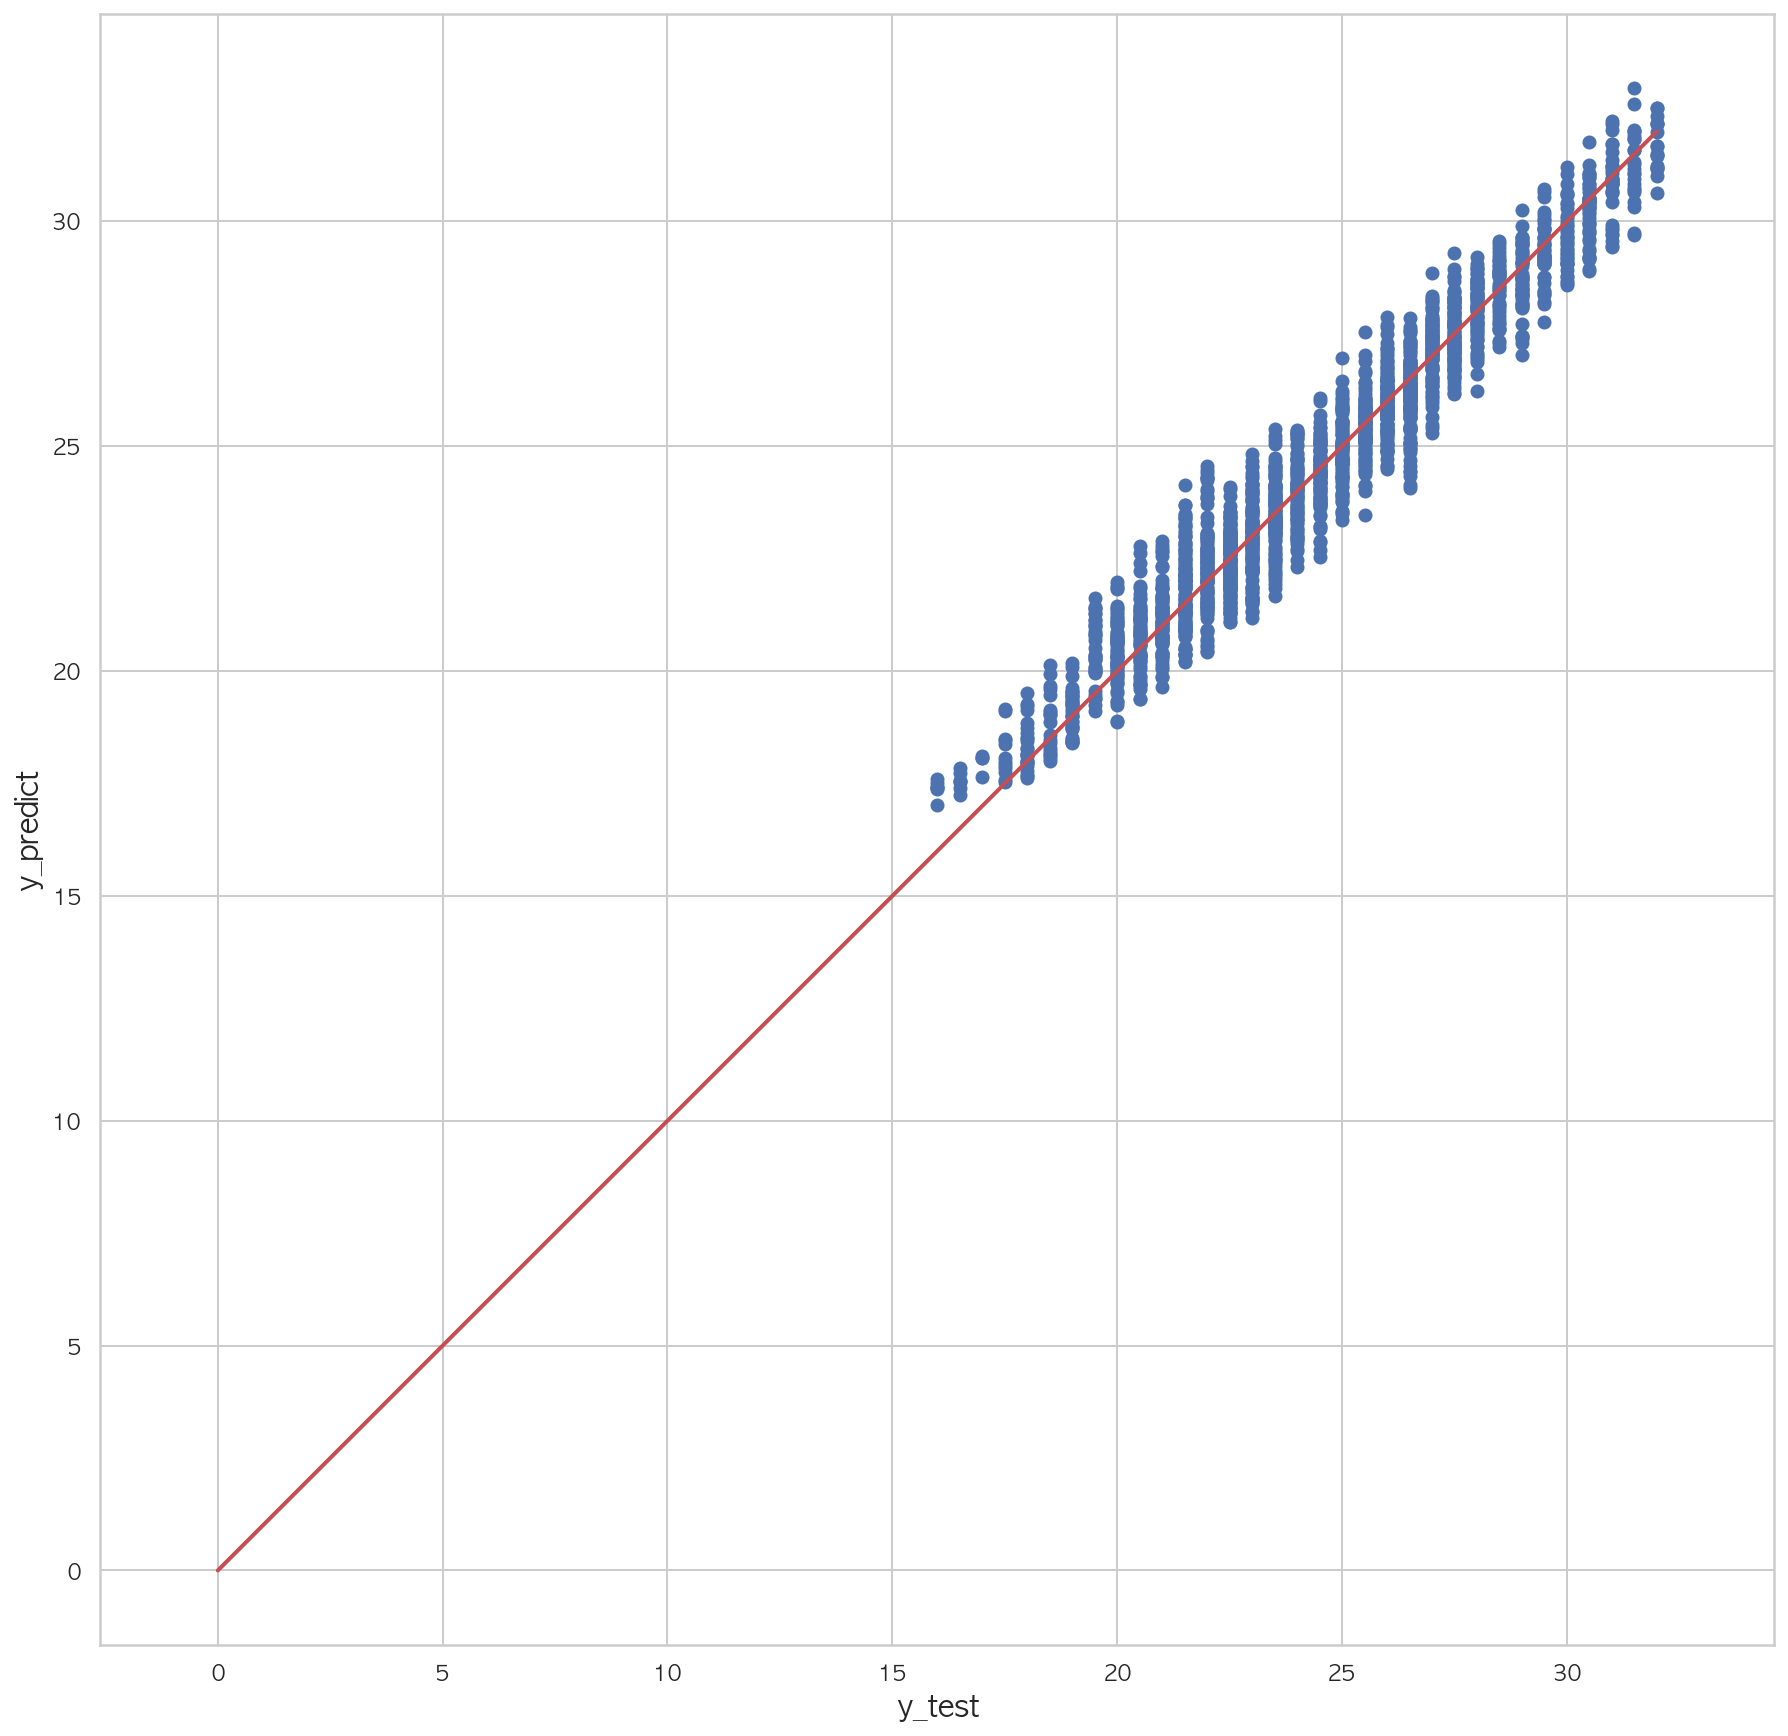

In [72]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y03'], pred)
plt.plot([0, dfX_test['Y03'].max()], [0, dfX_test['Y03'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [73]:
Y04_df = pd.concat([X_30s, sensor['Y04']], axis=1)

N = len(Y04_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y04_df.iloc[idx_train]
dfX_test = Y04_df.iloc[idx_test]

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=13)
for i, (idx_train, idx_test) in enumerate(cv.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model4 = sm.OLS.from_formula("Y04 ~ 1 +" + a, data=dfX_train)
    result4 = model4.fit()
    
    pred = result4.predict(df_test)
    rss = ((df_test.Y04 - pred) ** 2).sum()
    tss = ((df_test.Y04 - df_test.Y04.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result4.rsquared, rsquared))

pred = result4.predict(dfX_test)
rss = ((dfX_test.Y04 - pred) ** 2).sum()
tss = ((dfX_test.Y04 - dfX_test.Y04.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.94796568, 검증 R2 = 0.94734167
학습 R2 = 0.94796568, 검증 R2 = 0.94561380
학습 R2 = 0.94796568, 검증 R2 = 0.94708696
학습 R2 = 0.94796568, 검증 R2 = 0.95117340
학습 R2 = 0.94796568, 검증 R2 = 0.94848745
0.9466163967513248


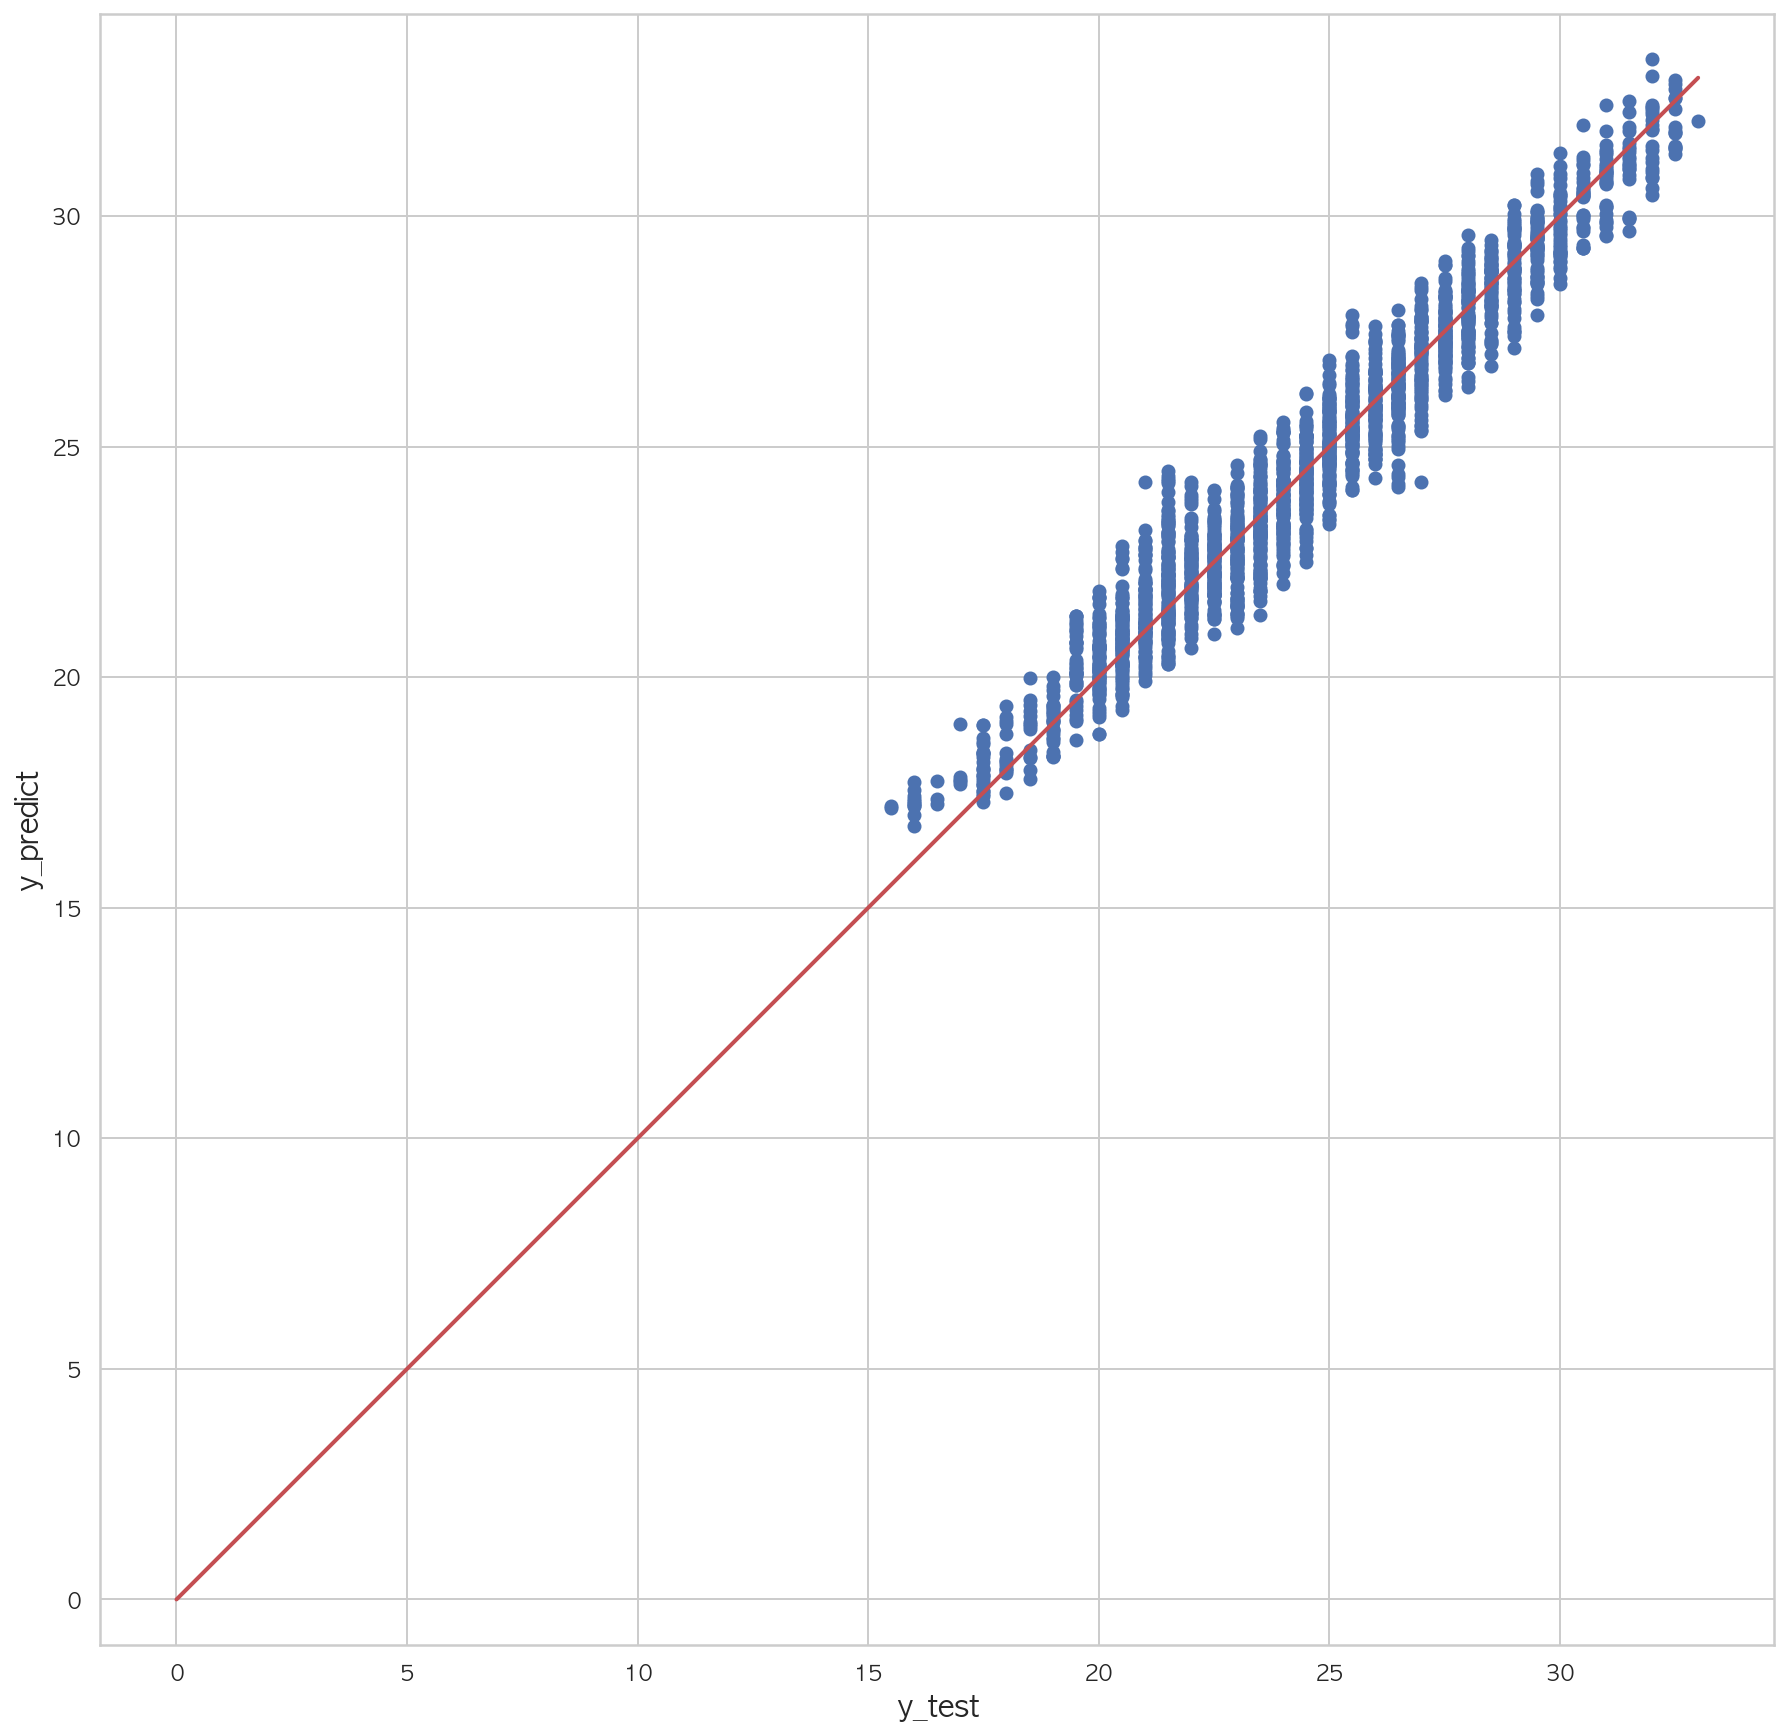

In [74]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y04'], pred)
plt.plot([0, dfX_test['Y04'].max()], [0, dfX_test['Y04'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [75]:
Y05_df = pd.concat([X_30s, sensor['Y05']], axis=1)

N = len(Y05_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y05_df.iloc[idx_train]
dfX_test = Y05_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model5 = sm.OLS.from_formula("Y05 ~ 1 +" + a, data=dfX_train)
    result5 = model5.fit()
    
    pred = result5.predict(df_test)
    rss = ((df_test.Y05 - pred) ** 2).sum()
    tss = ((df_test.Y05 - df_test.Y05.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result5.rsquared, rsquared))

pred = result5.predict(dfX_test)
rss = ((dfX_test.Y05 - pred) ** 2).sum()
tss = ((dfX_test.Y05 - dfX_test.Y05.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.94777908, 검증 R2 = 0.94299018
학습 R2 = 0.94777908, 검증 R2 = 0.94408928
학습 R2 = 0.94777908, 검증 R2 = 0.94572819
학습 R2 = 0.94777908, 검증 R2 = 0.94986888
학습 R2 = 0.94777908, 검증 R2 = 0.95540827
0.9406042424726812


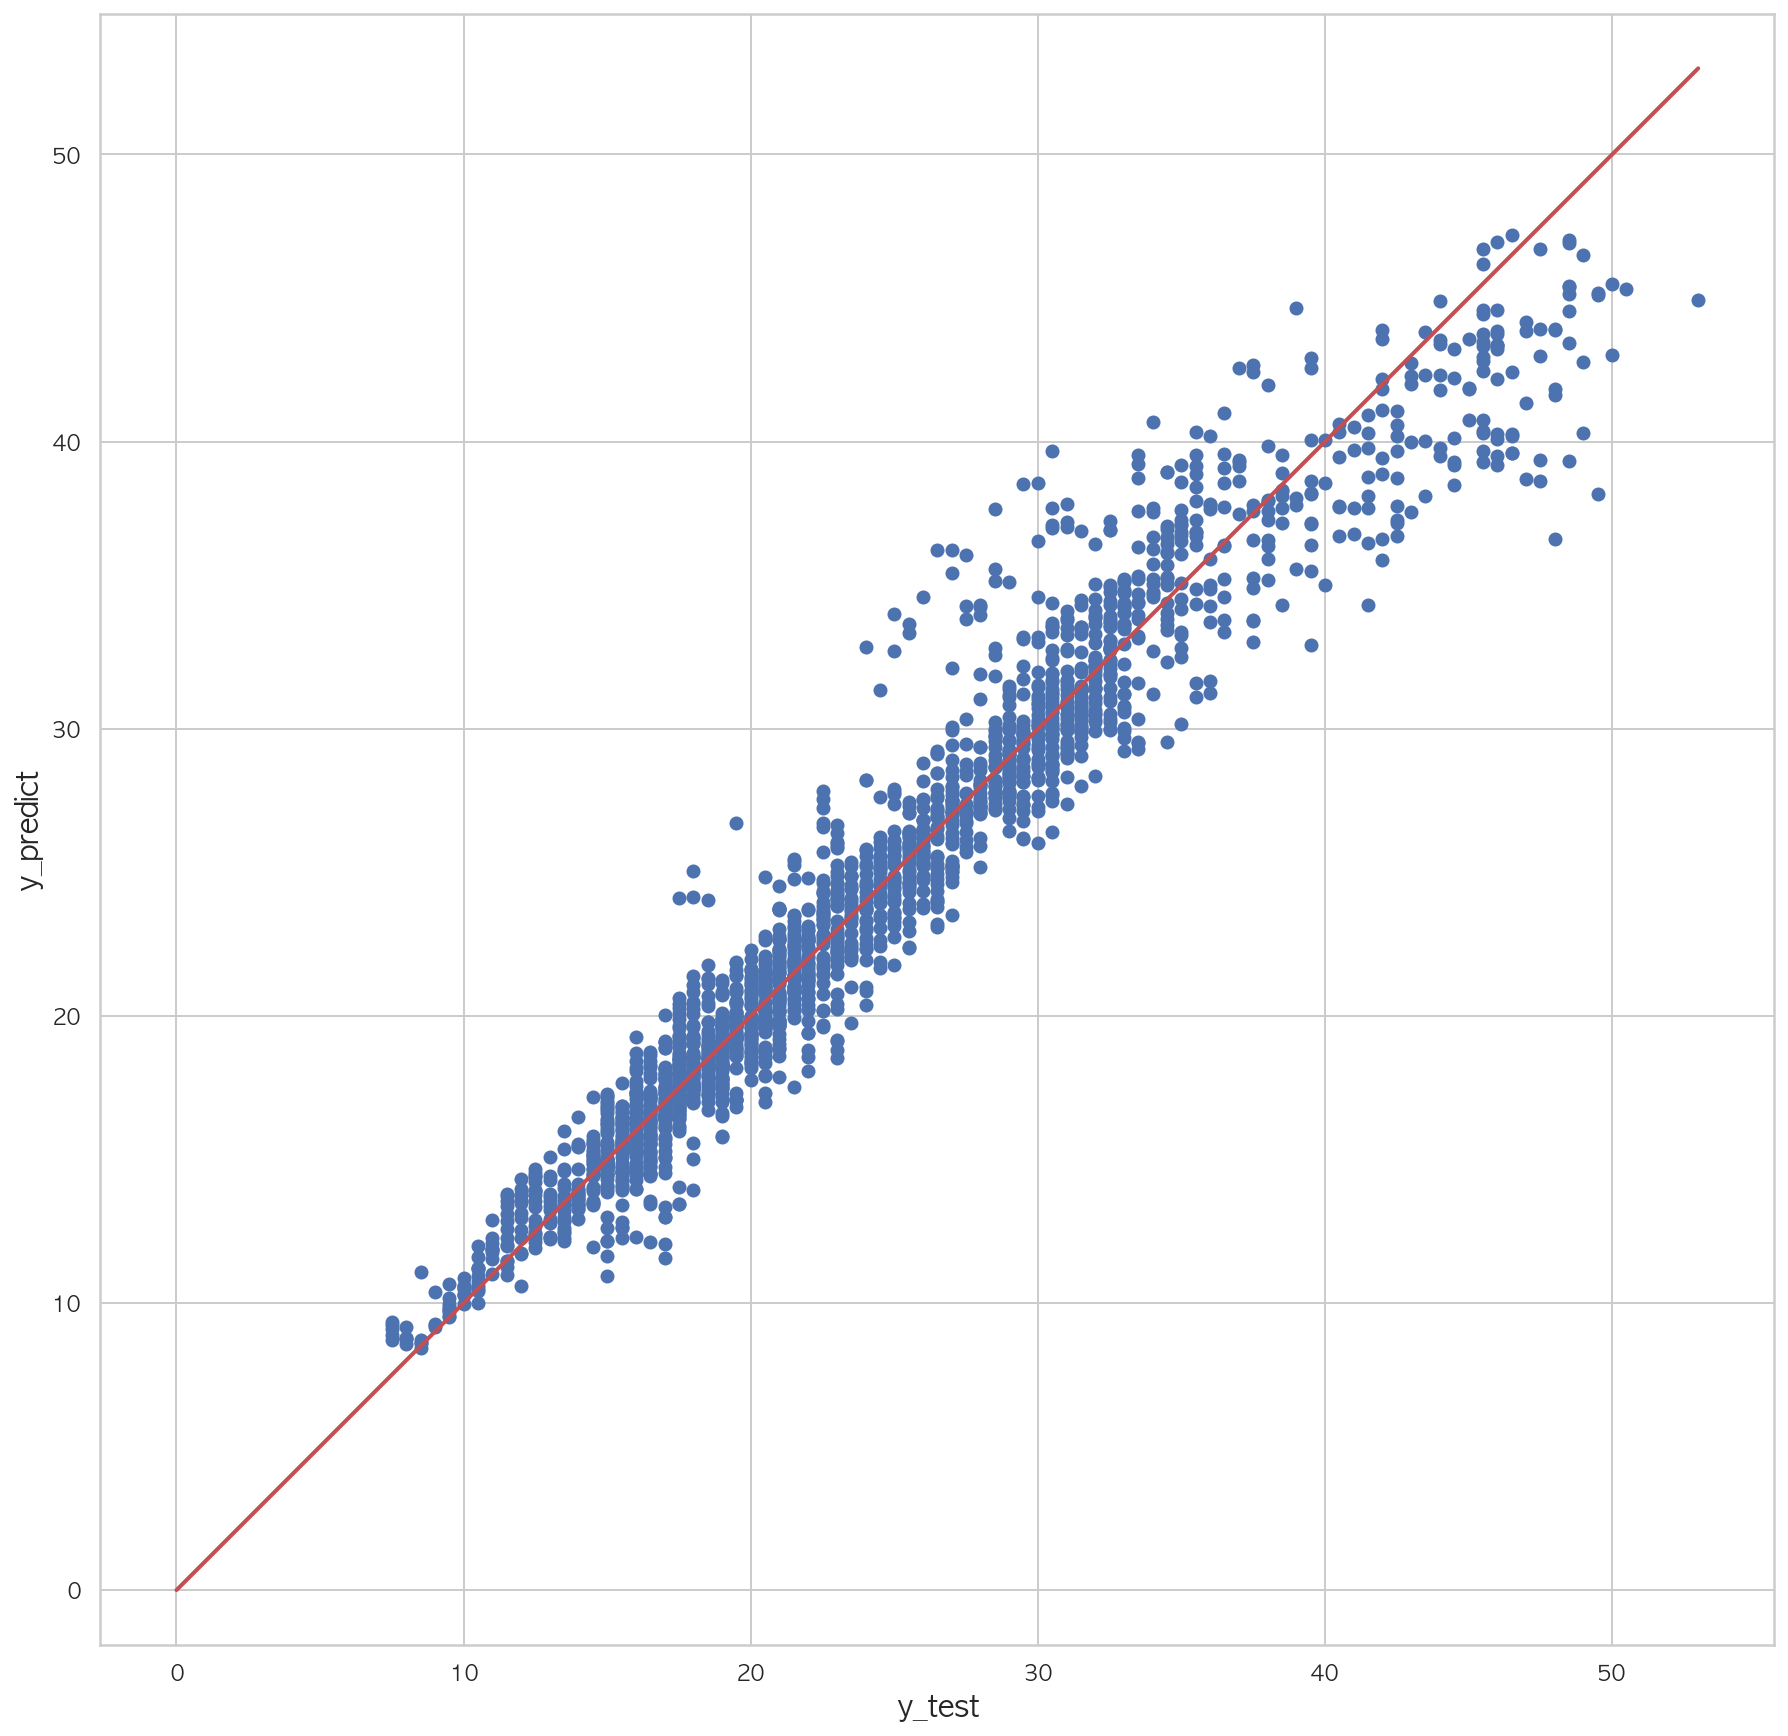

In [76]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y05'], pred)
plt.plot([0, dfX_test['Y05'].max()], [0, dfX_test['Y05'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [77]:
Y06_df = pd.concat([X_30s, sensor['Y06']], axis=1)

N = len(Y06_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y06_df.iloc[idx_train]
dfX_test = Y06_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model6 = sm.OLS.from_formula("Y06 ~ 1 +" + a, data=dfX_train)
    result6 = model6.fit()
    
    pred = result6.predict(df_test)
    rss = ((df_test.Y06 - pred) ** 2).sum()
    tss = ((df_test.Y06 - df_test.Y06.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result6.rsquared, rsquared))

pred = result6.predict(dfX_test)
rss = ((dfX_test.Y06 - pred) ** 2).sum()
tss = ((dfX_test.Y06 - dfX_test.Y06.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.93753514, 검증 R2 = 0.93838017
학습 R2 = 0.93753514, 검증 R2 = 0.93545692
학습 R2 = 0.93753514, 검증 R2 = 0.93884759
학습 R2 = 0.93753514, 검증 R2 = 0.93079795
학습 R2 = 0.93753514, 검증 R2 = 0.94346828
0.9330361936783402


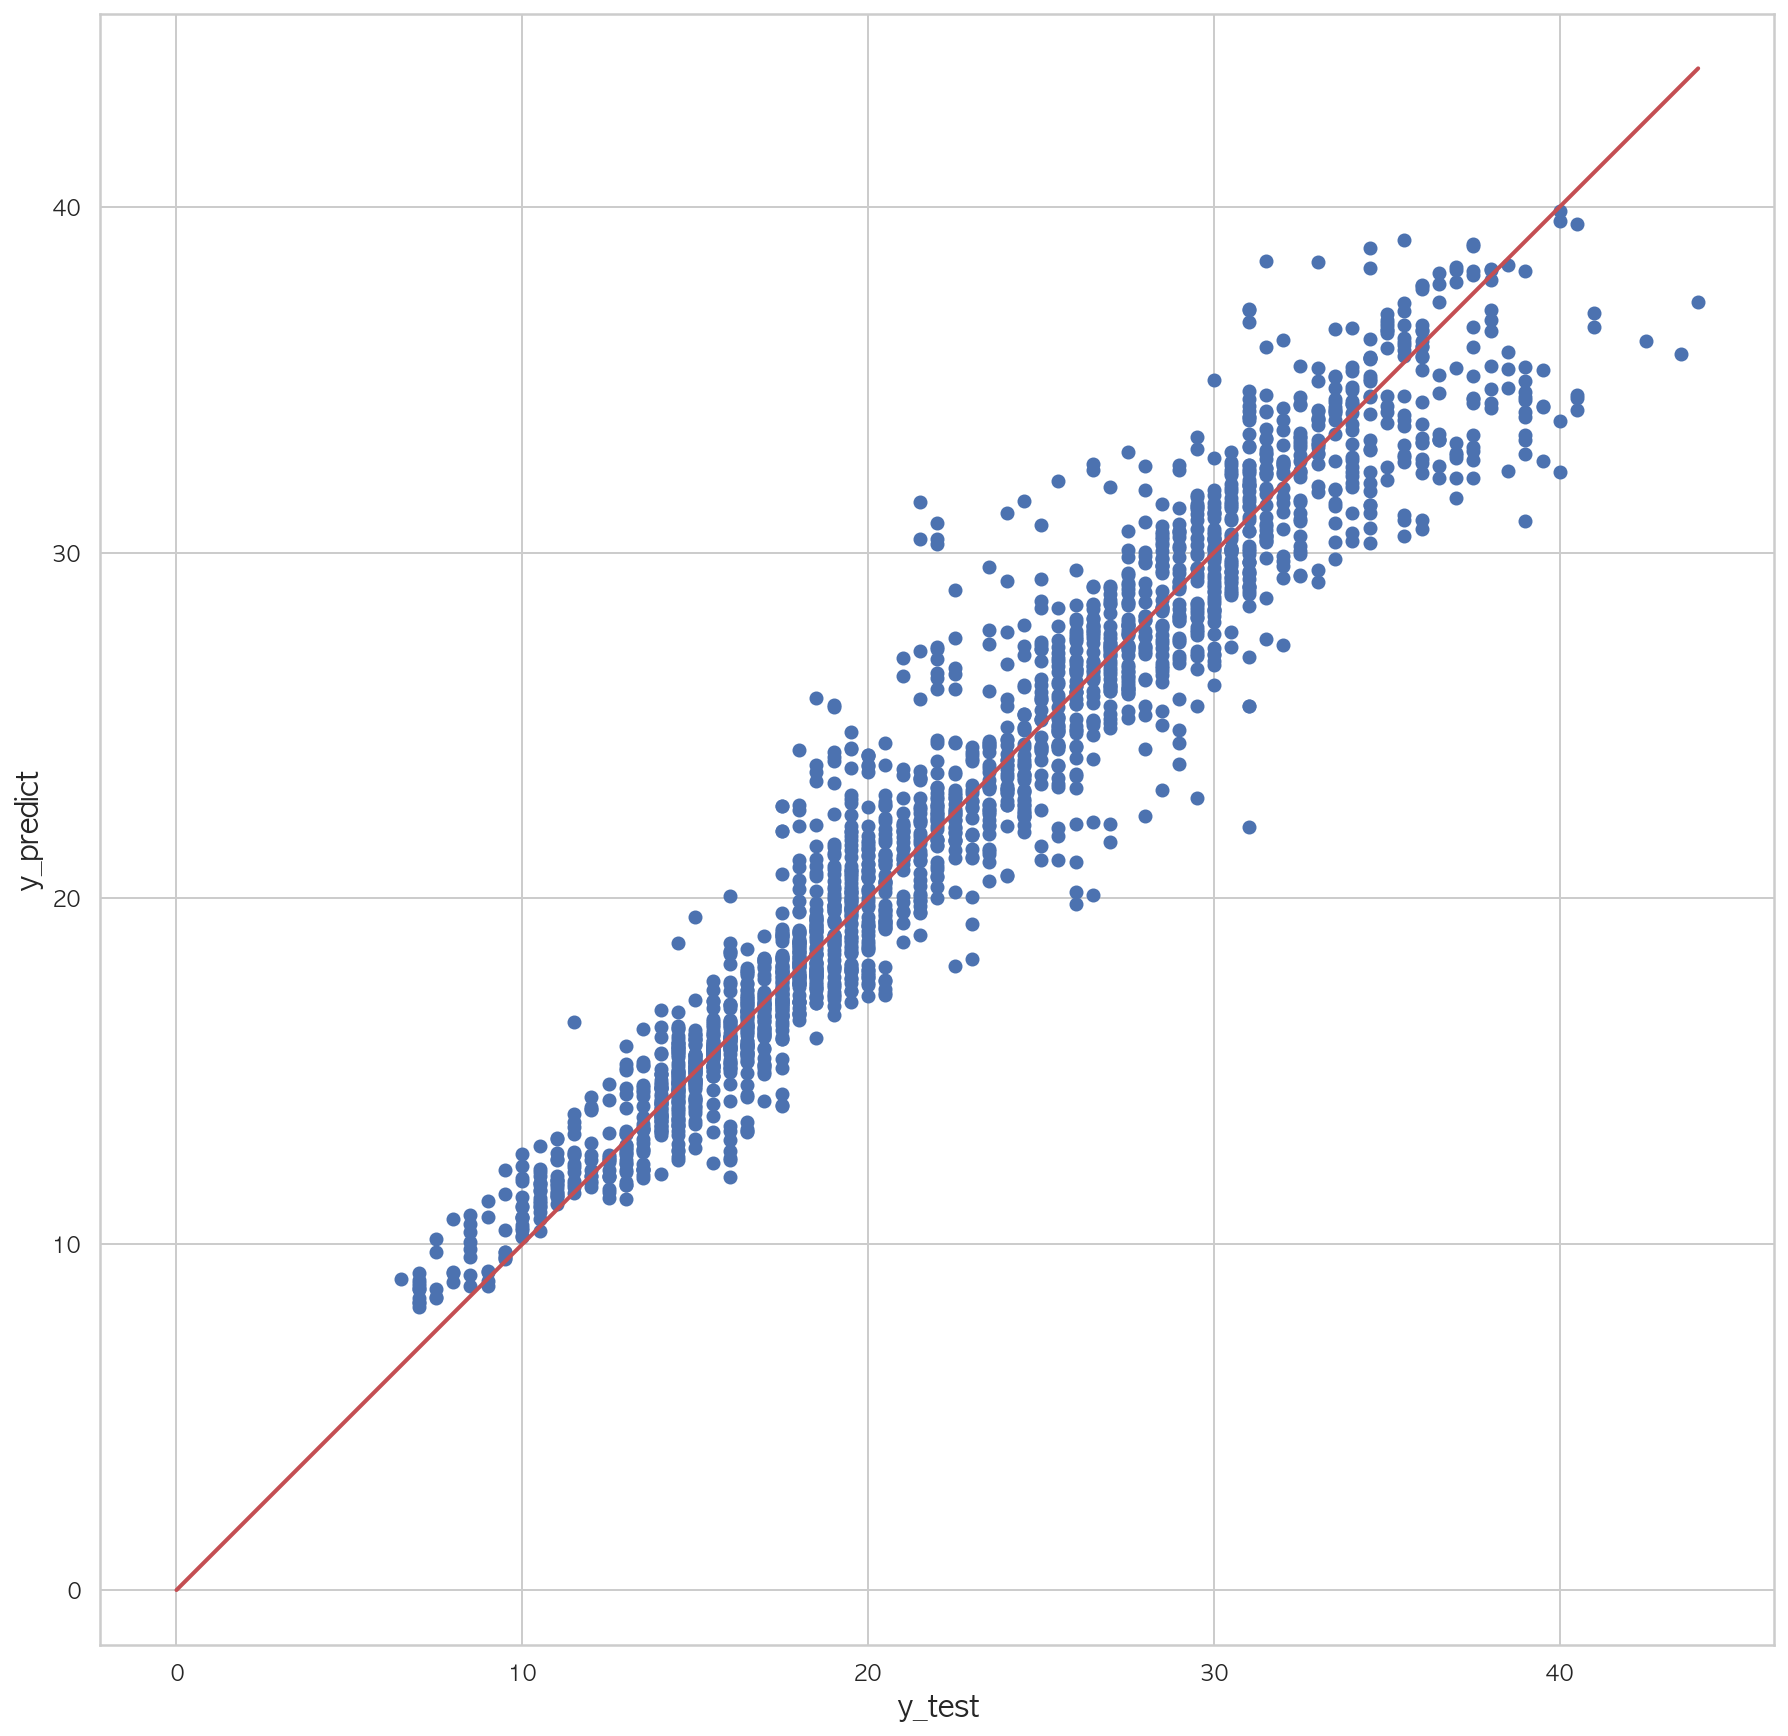

In [78]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y06'], pred)
plt.plot([0, dfX_test['Y06'].max()], [0, dfX_test['Y06'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [79]:
Y07_df = pd.concat([X_30s, sensor['Y07']], axis=1)

N = len(Y07_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y07_df.iloc[idx_train]
dfX_test = Y07_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model7 = sm.OLS.from_formula("Y07 ~ 1 +" + a, data=dfX_train)
    result7 = model7.fit()
    
    pred = result7.predict(df_test)
    rss = ((df_test.Y07 - pred) ** 2).sum()
    tss = ((df_test.Y07 - df_test.Y07.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result7.rsquared, rsquared))

pred = result7.predict(dfX_test)
rss = ((dfX_test.Y07 - pred) ** 2).sum()
tss = ((dfX_test.Y07 - dfX_test.Y07.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.89336104, 검증 R2 = 0.88463988
학습 R2 = 0.89336104, 검증 R2 = 0.89507160
학습 R2 = 0.89336104, 검증 R2 = 0.90083034
학습 R2 = 0.89336104, 검증 R2 = 0.87764882
학습 R2 = 0.89336104, 검증 R2 = 0.90739659
0.8867440441794064


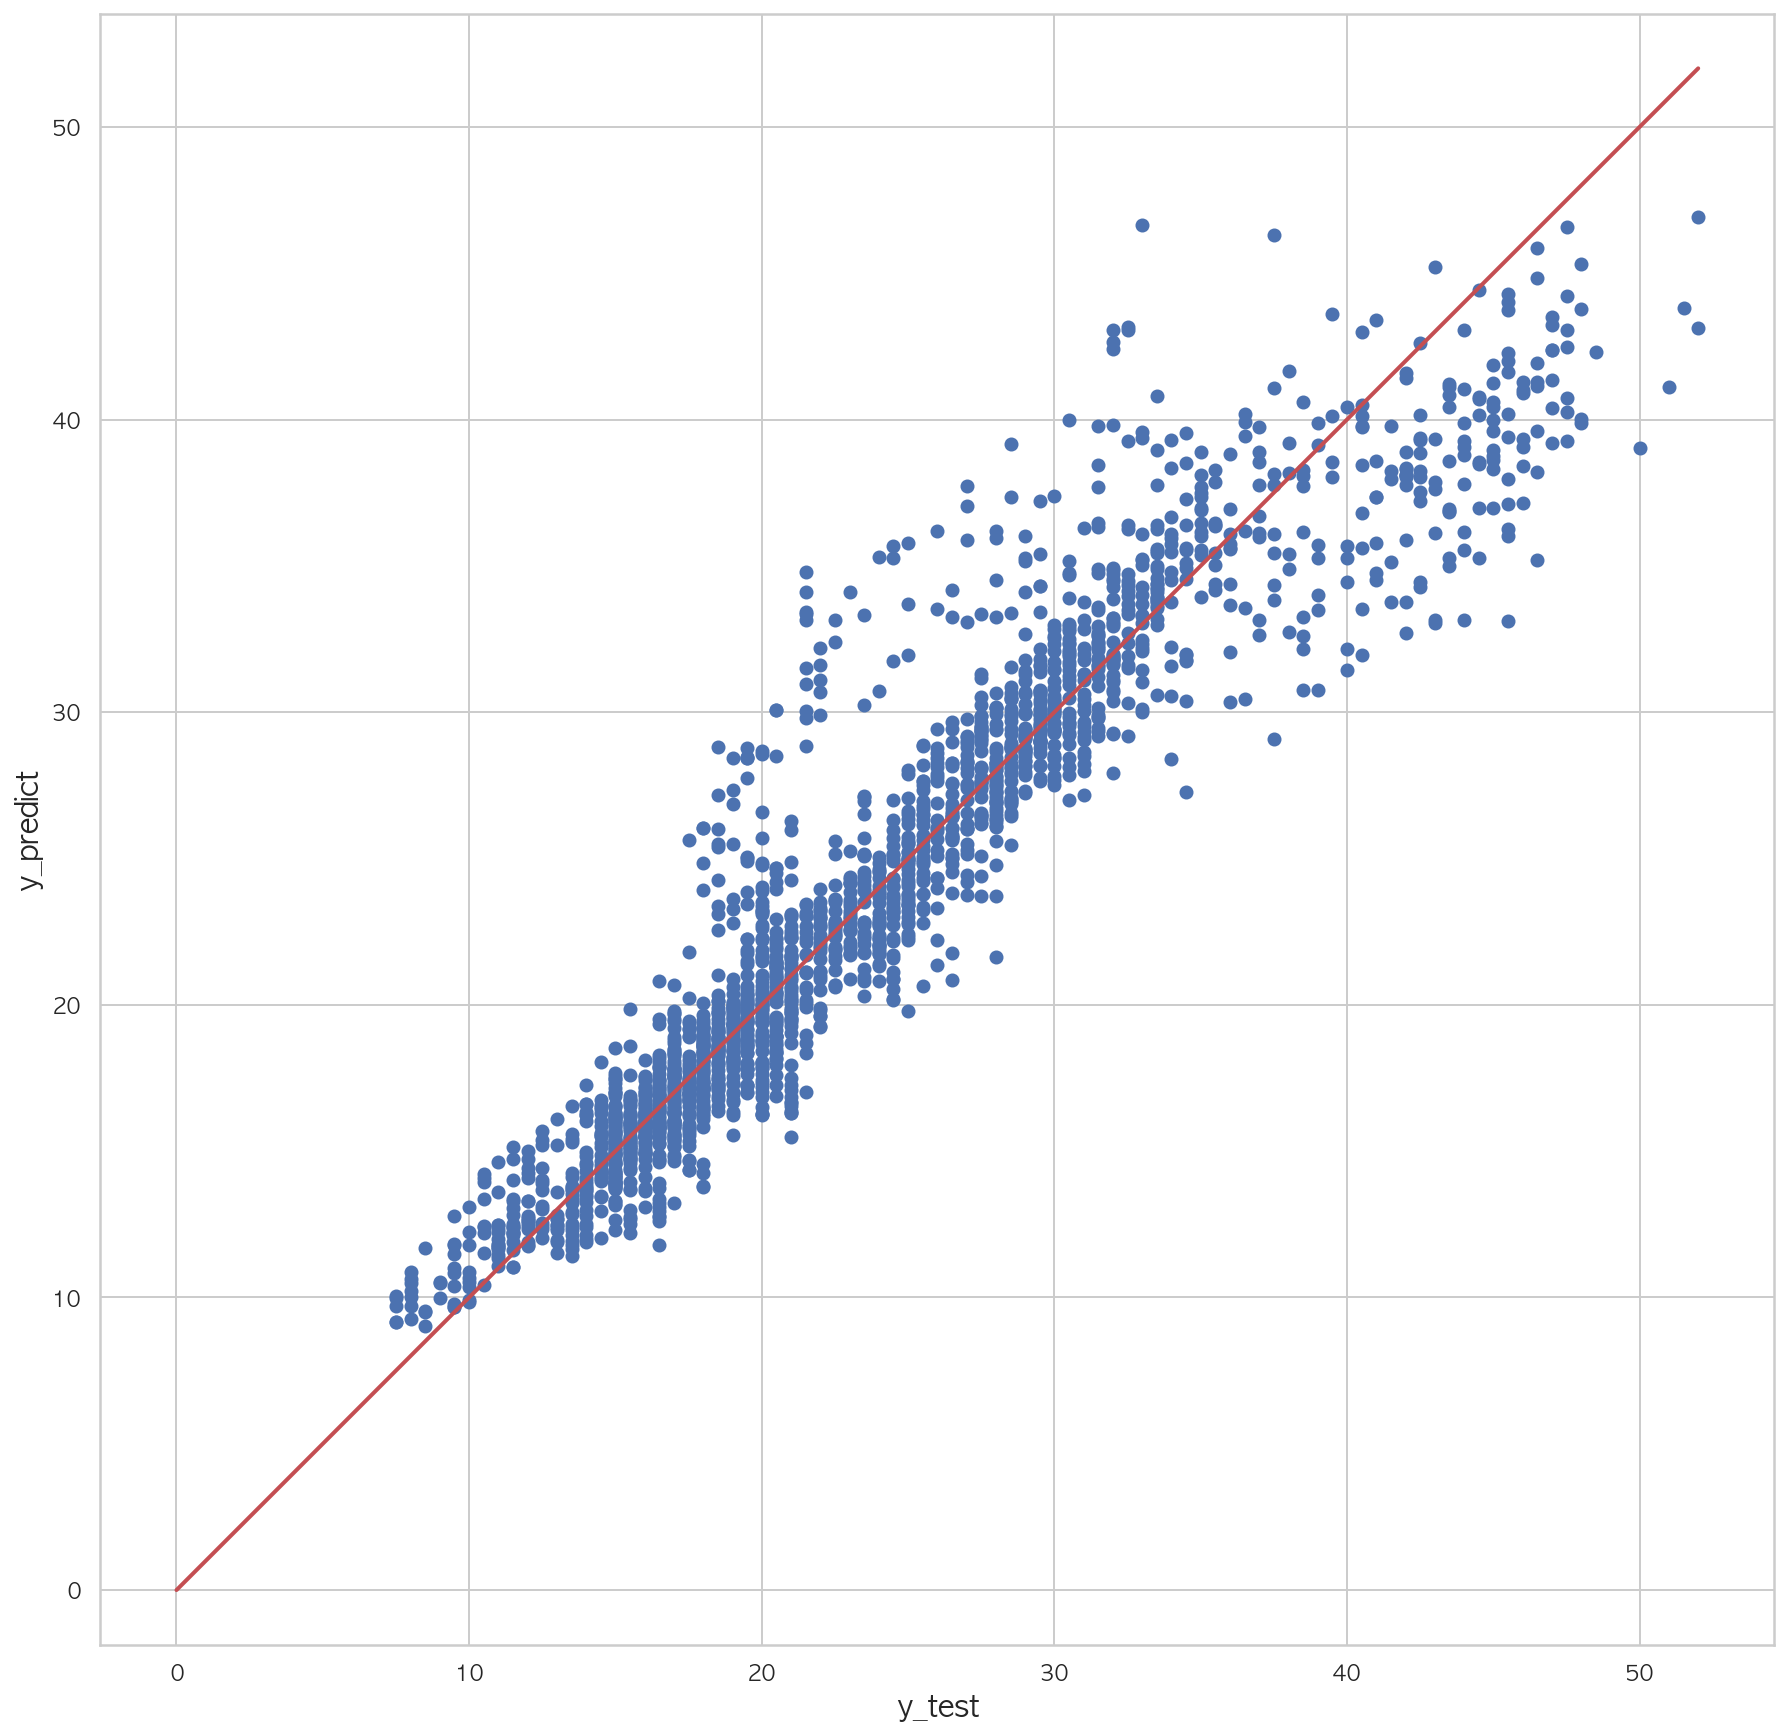

In [80]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y07'], pred)
plt.plot([0, dfX_test['Y07'].max()], [0, dfX_test['Y07'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [81]:
Y08_df = pd.concat([X_30s, sensor['Y08']], axis=1)

N = len(Y08_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y08_df.iloc[idx_train]
dfX_test = Y08_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model8 = sm.OLS.from_formula("Y08 ~ 1 +" + a, data=dfX_train)
    result8 = model8.fit()
    
    pred = result8.predict(df_test)
    rss = ((df_test.Y08 - pred) ** 2).sum()
    tss = ((df_test.Y08 - df_test.Y08.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result8.rsquared, rsquared))

pred = result8.predict(dfX_test)
rss = ((dfX_test.Y08 - pred) ** 2).sum()
tss = ((dfX_test.Y08 - dfX_test.Y08.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.93860214, 검증 R2 = 0.93855661
학습 R2 = 0.93860214, 검증 R2 = 0.93569780
학습 R2 = 0.93860214, 검증 R2 = 0.93912749
학습 R2 = 0.93860214, 검증 R2 = 0.93465834
학습 R2 = 0.93860214, 검증 R2 = 0.94418988
0.9277941979411815


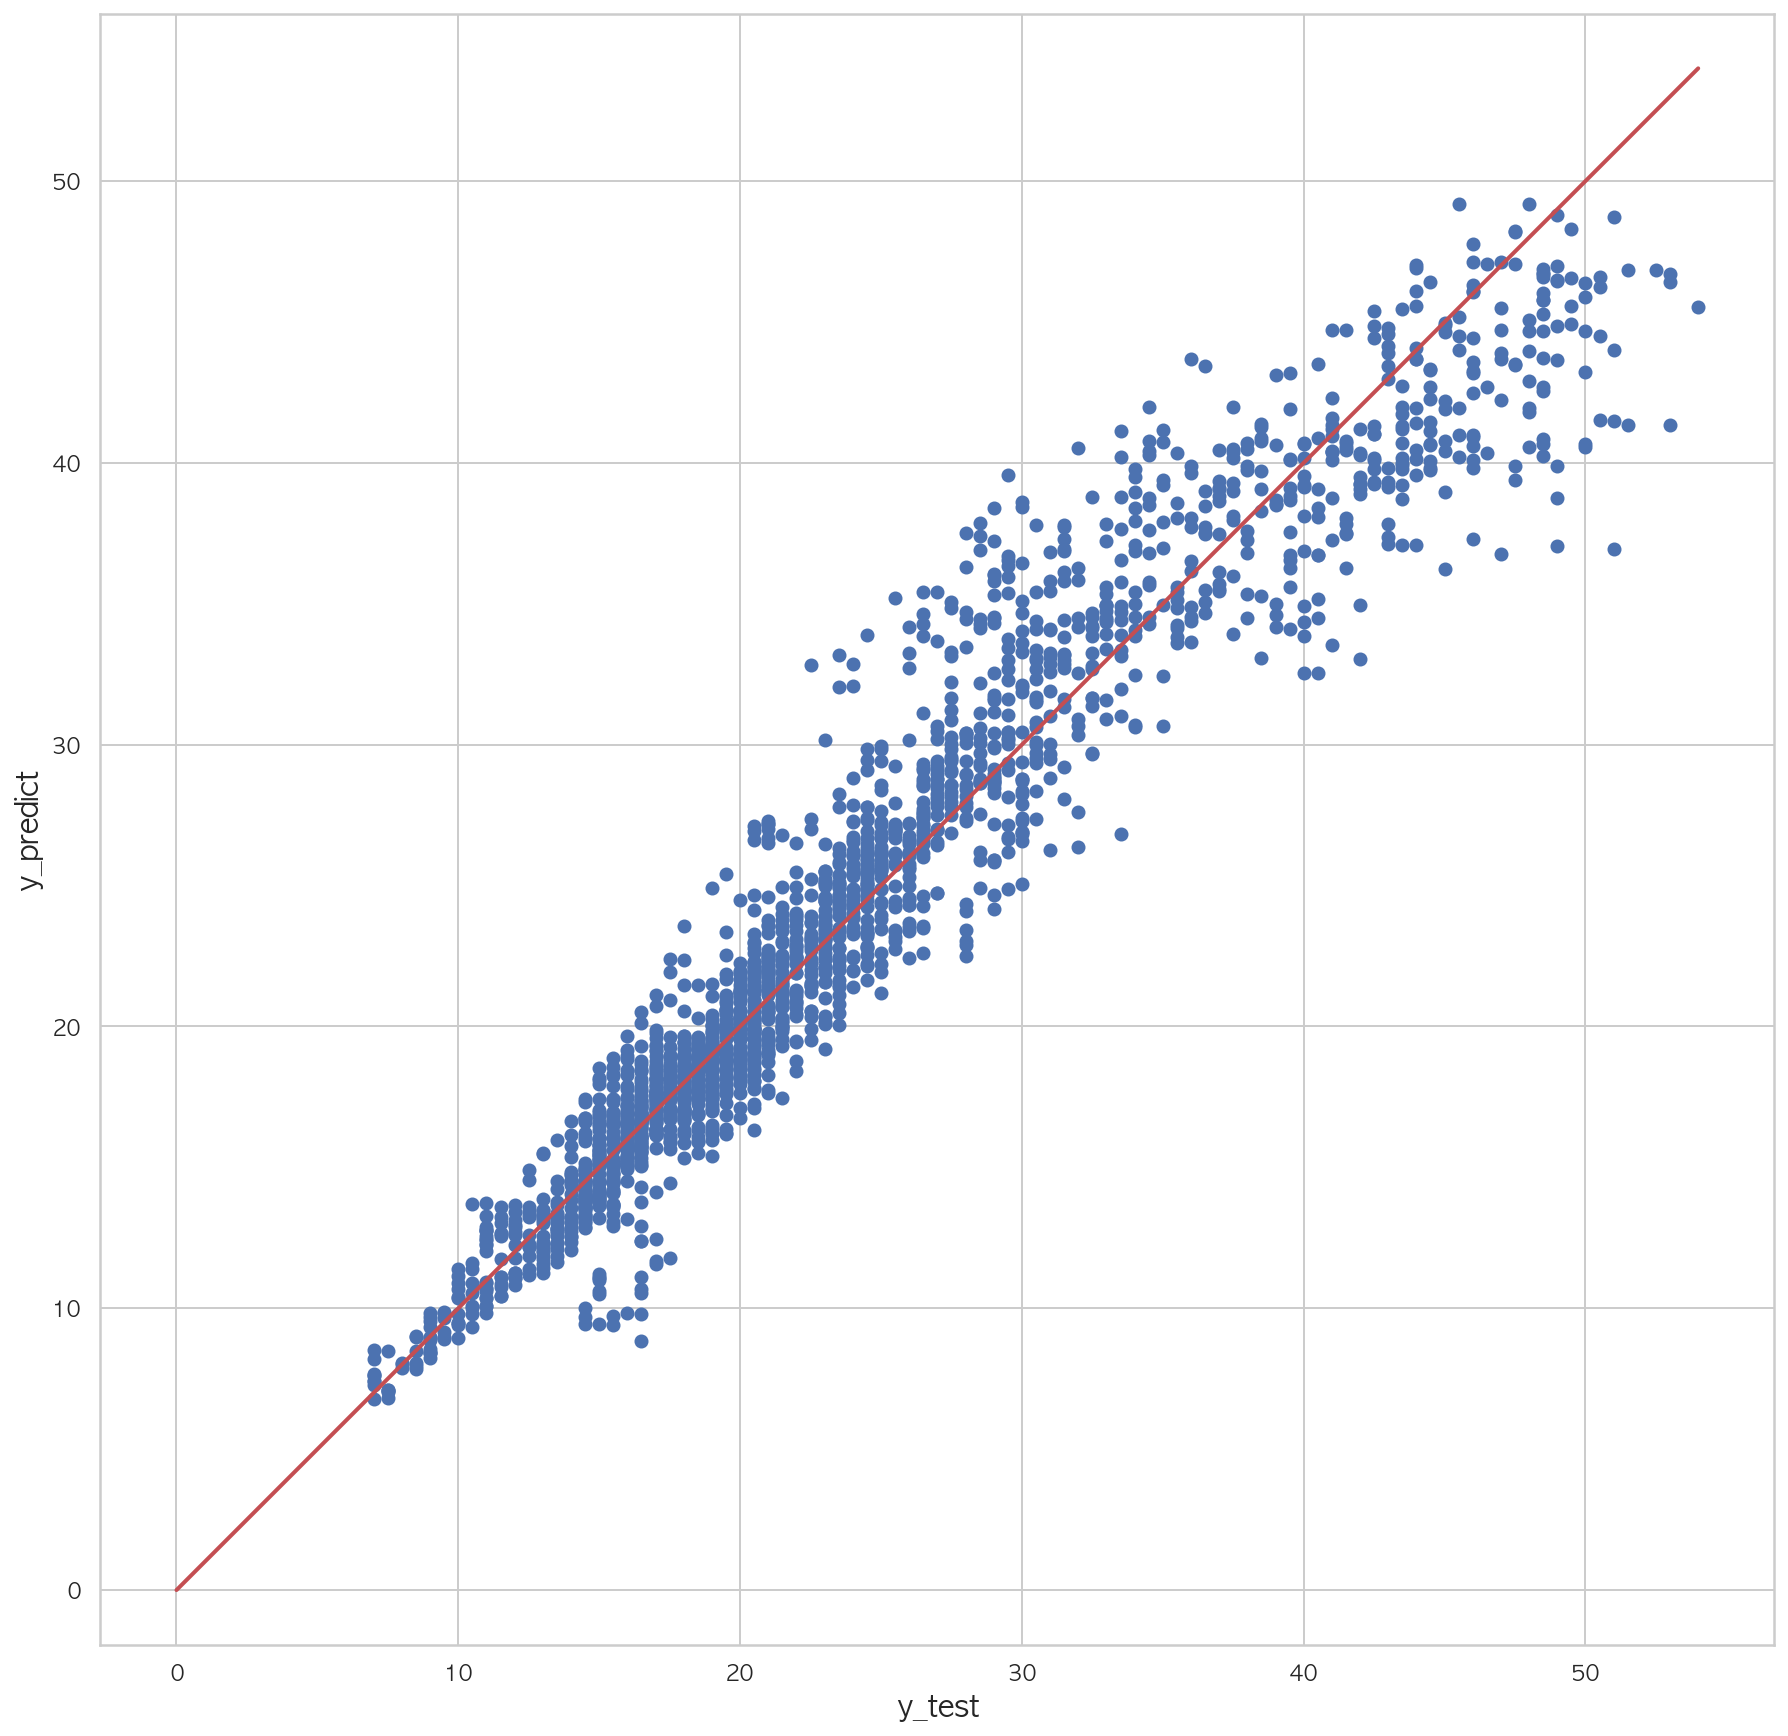

In [82]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y08'], pred)
plt.plot([0, dfX_test['Y08'].max()], [0, dfX_test['Y08'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [83]:
Y09_df = pd.concat([X_30s, sensor['Y09']], axis=1)

N = len(Y09_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y09_df.iloc[idx_train]
dfX_test = Y09_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model9 = sm.OLS.from_formula("Y09 ~ 1 +" + a, data=dfX_train)
    result9 = model9.fit()
    
    pred = result9.predict(df_test)
    rss = ((df_test.Y09 - pred) ** 2).sum()
    tss = ((df_test.Y09 - df_test.Y09.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result9.rsquared, rsquared))

pred = result9.predict(dfX_test)
rss = ((dfX_test.Y09 - pred) ** 2).sum()
tss = ((dfX_test.Y09 - dfX_test.Y09.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.97479786, 검증 R2 = 0.97486045
학습 R2 = 0.97479786, 검증 R2 = 0.97286052
학습 R2 = 0.97479786, 검증 R2 = 0.97321239
학습 R2 = 0.97479786, 검증 R2 = 0.97642863
학습 R2 = 0.97479786, 검증 R2 = 0.97640687
0.9711646789042401


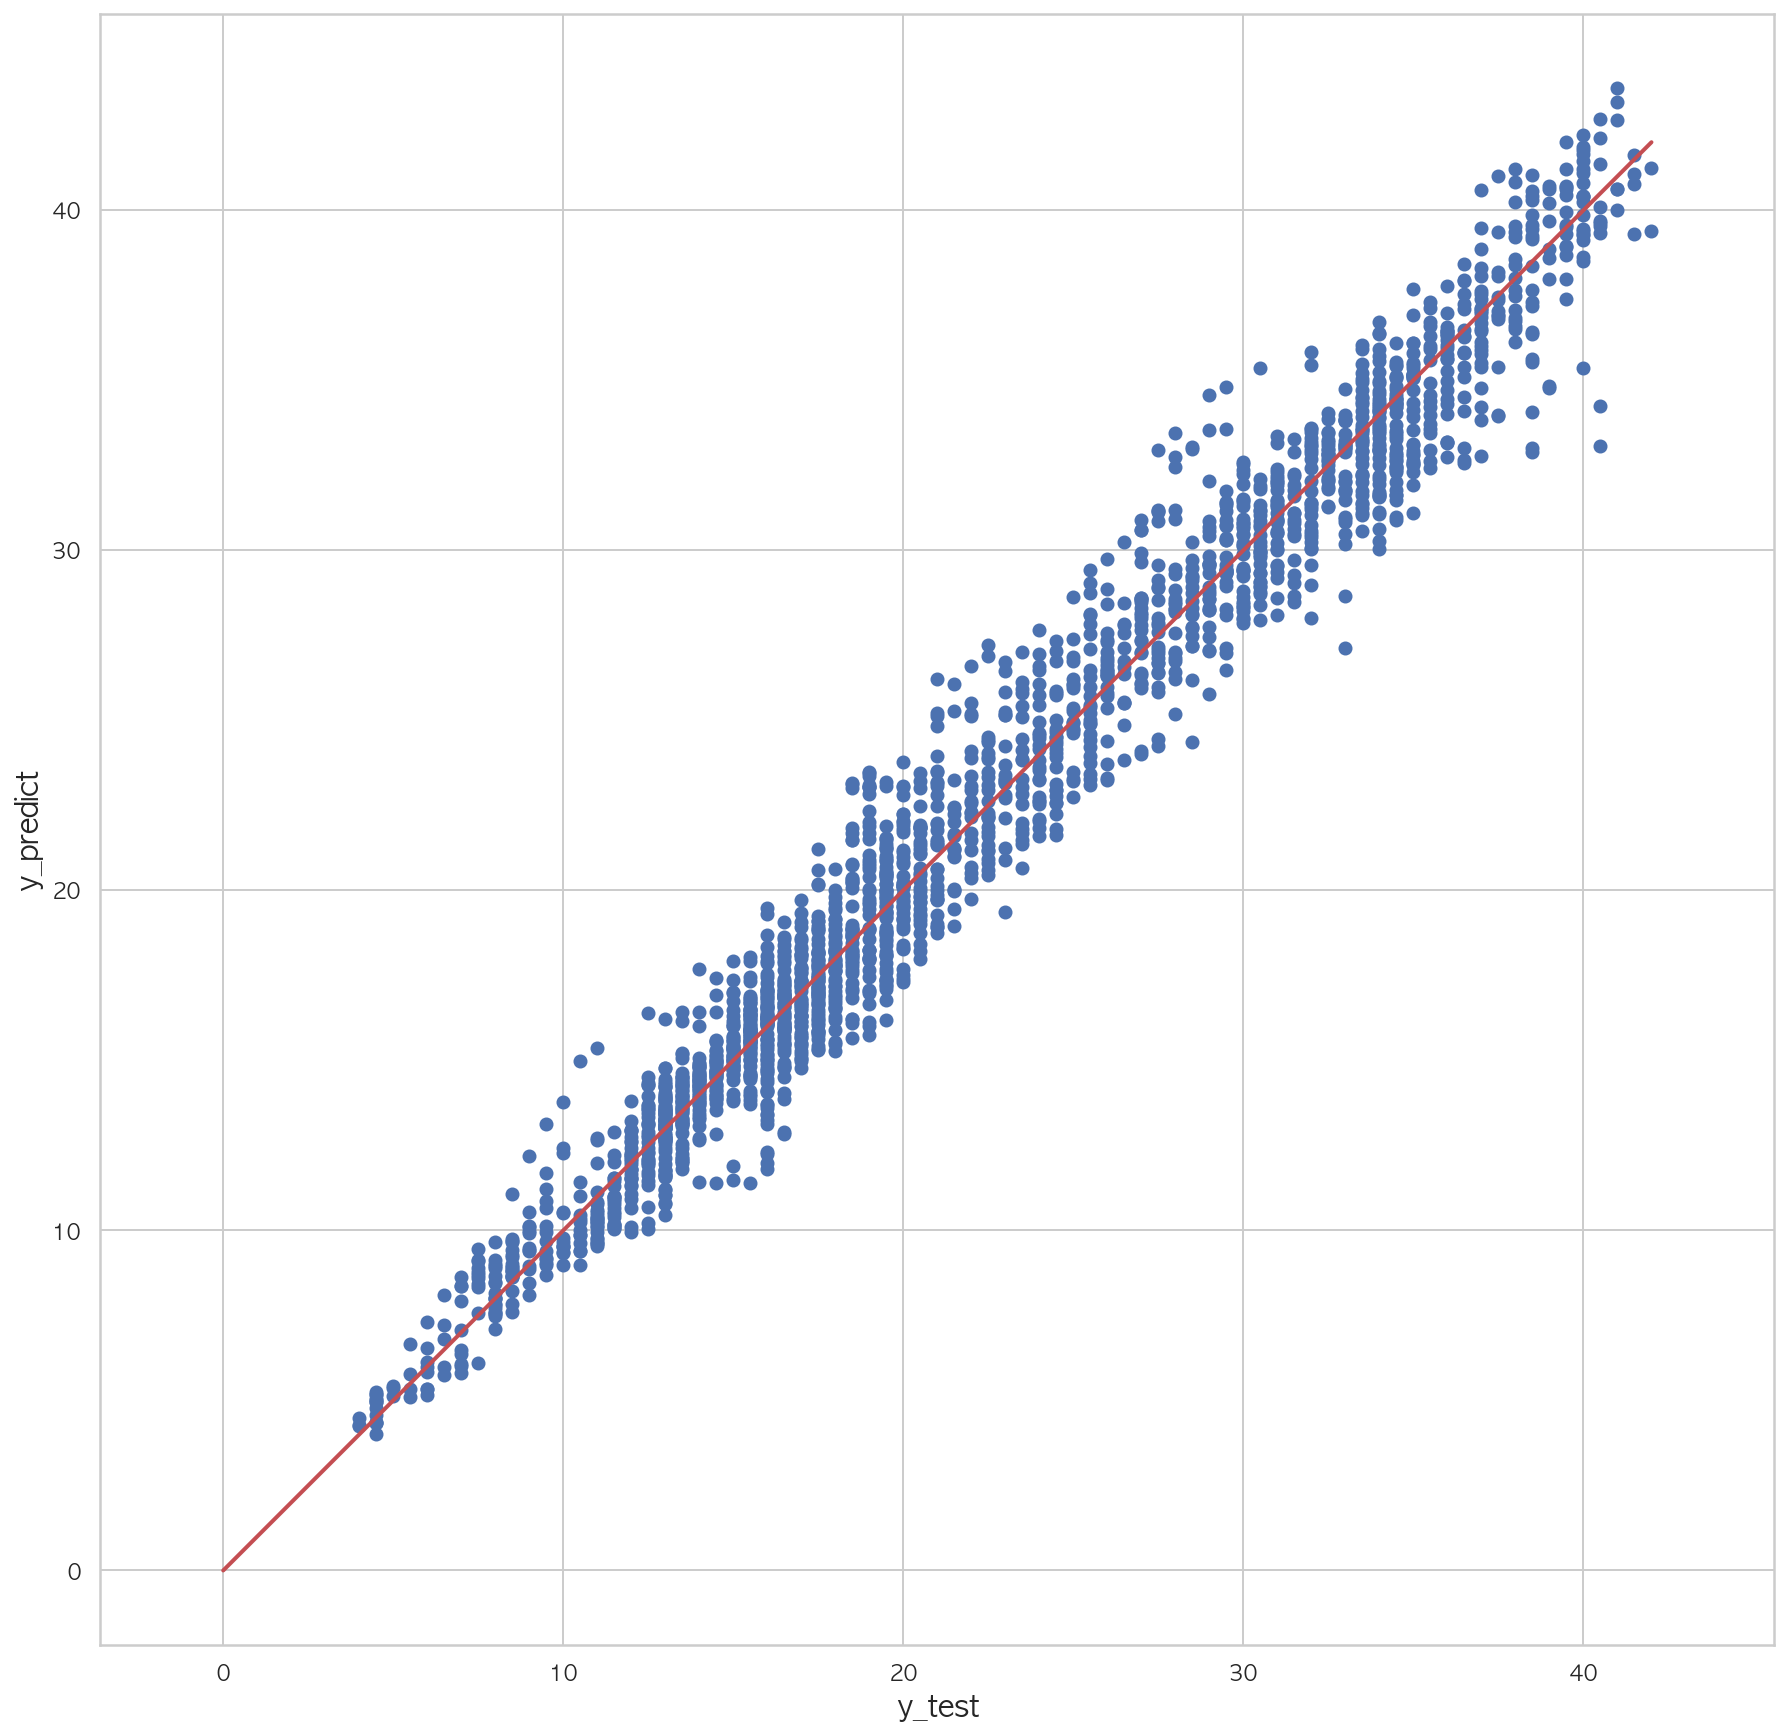

In [84]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y09'], pred)
plt.plot([0, dfX_test['Y09'].max()], [0, dfX_test['Y09'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [85]:
Y10_df = pd.concat([X_30s, sensor['Y10']], axis=1)

N = len(Y10_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y10_df.iloc[idx_train]
dfX_test = Y10_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model10 = sm.OLS.from_formula("Y10 ~ 1 +" + a, data=dfX_train)
    result10 = model10.fit()
    
    pred = result10.predict(df_test)
    rss = ((df_test.Y10 - pred) ** 2).sum()
    tss = ((df_test.Y10 - df_test.Y10.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result10.rsquared, rsquared))

pred = result10.predict(dfX_test)
rss = ((dfX_test.Y10 - pred) ** 2).sum()
tss = ((dfX_test.Y10 - dfX_test.Y10.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.97589977, 검증 R2 = 0.97627704
학습 R2 = 0.97589977, 검증 R2 = 0.97351250
학습 R2 = 0.97589977, 검증 R2 = 0.97526803
학습 R2 = 0.97589977, 검증 R2 = 0.97882271
학습 R2 = 0.97589977, 검증 R2 = 0.97525676
0.9710476924723909


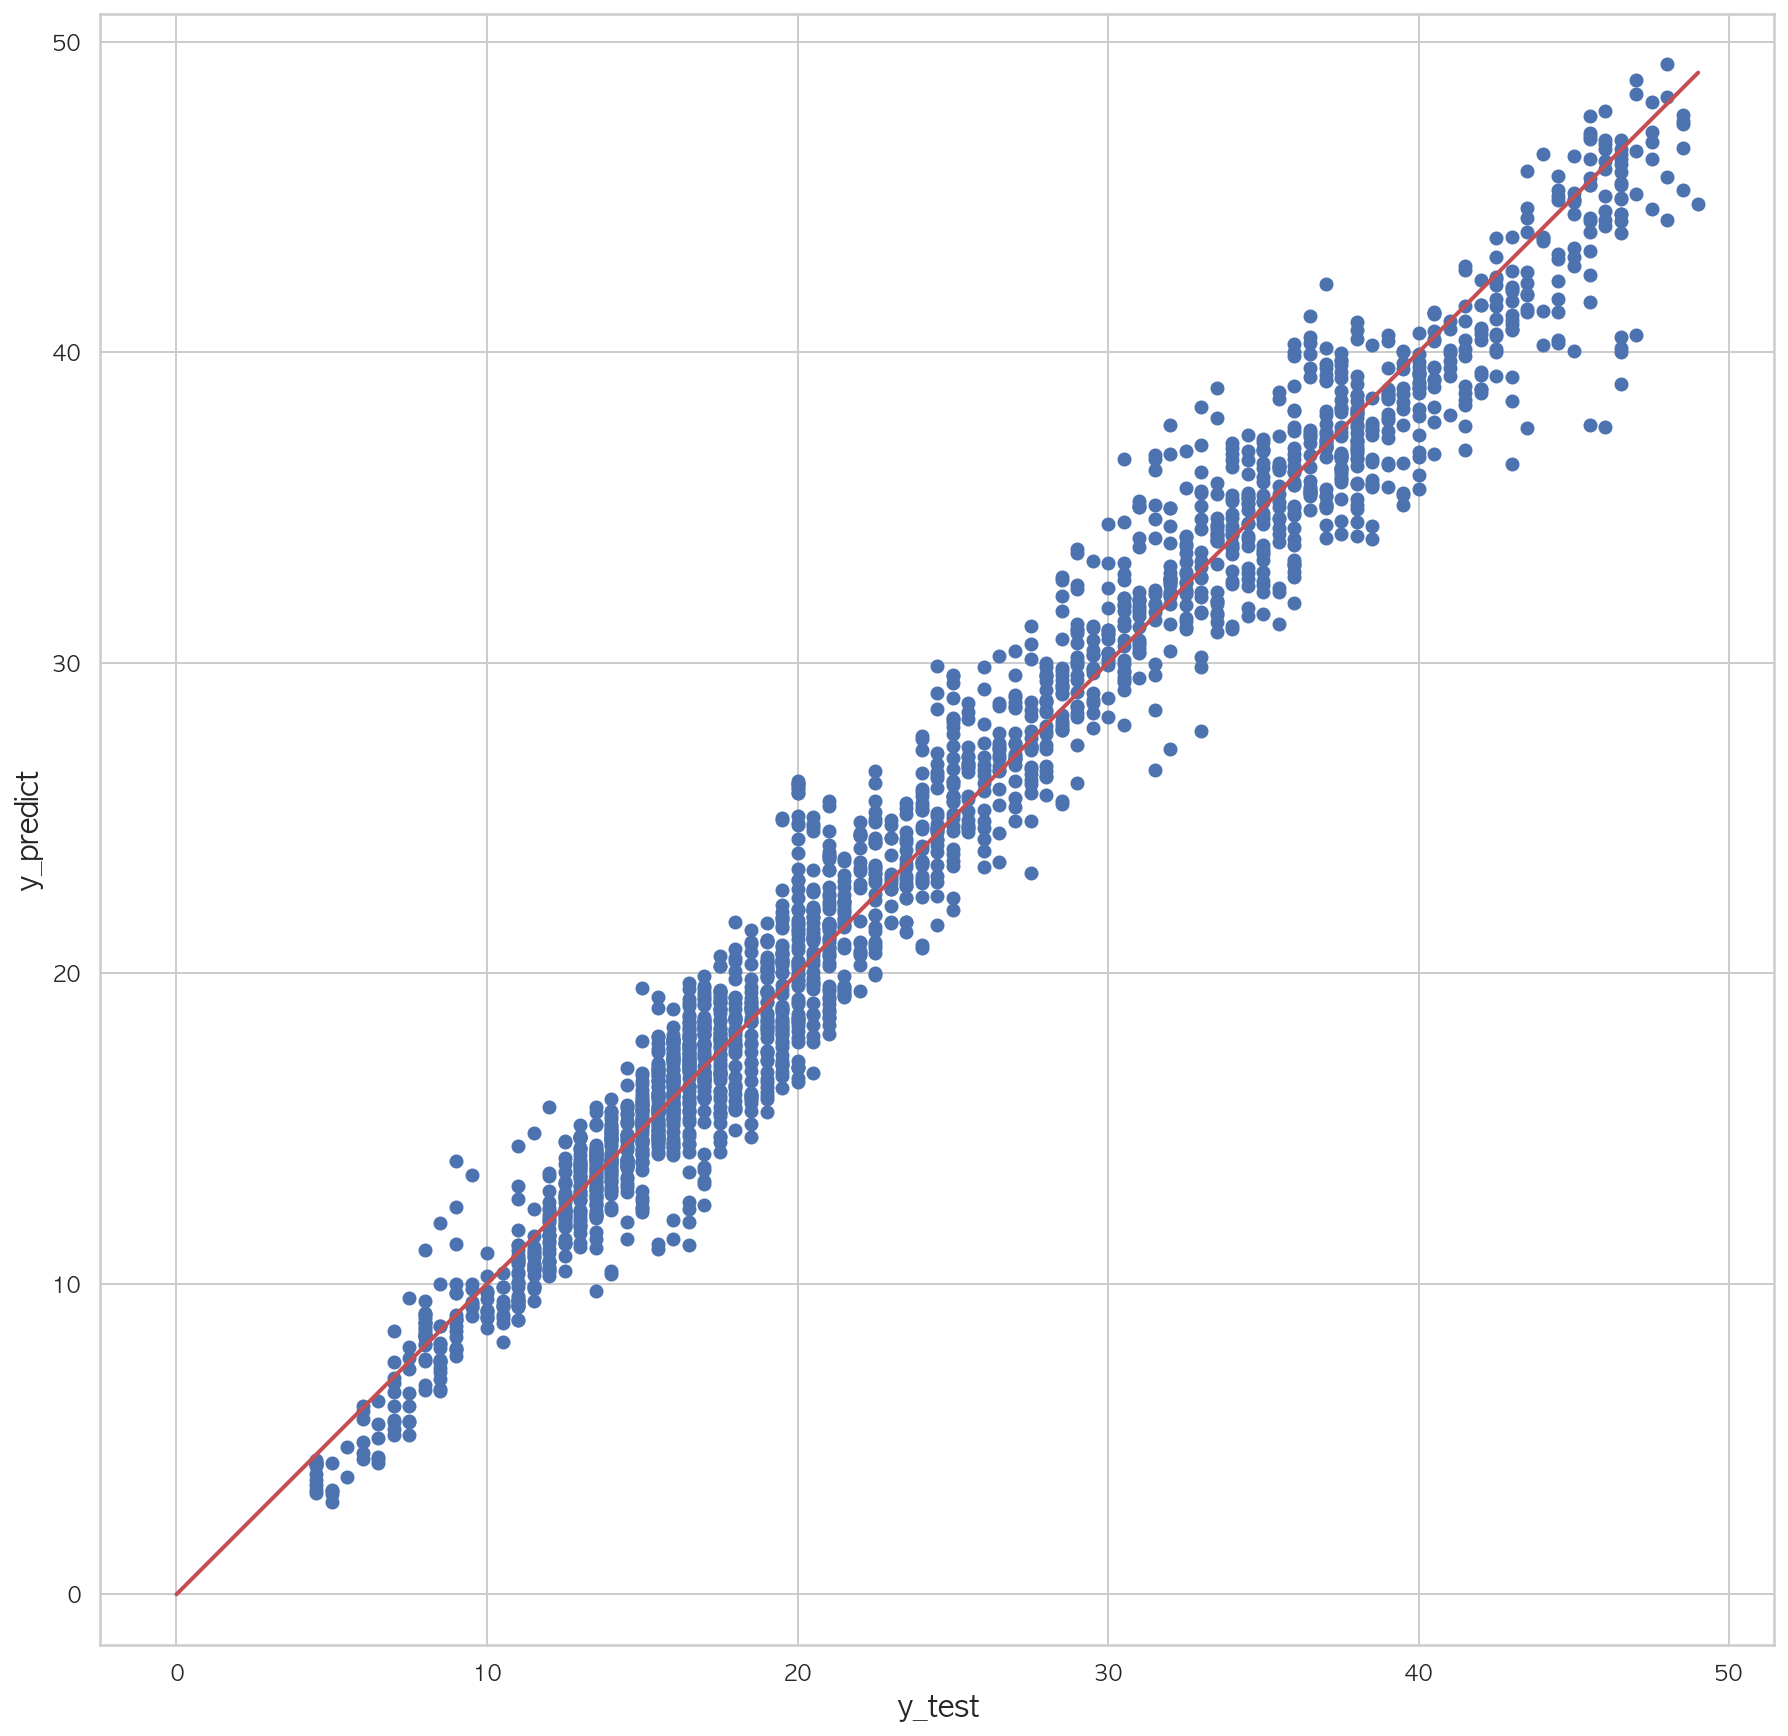

In [86]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y10'], pred)
plt.plot([0, dfX_test['Y10'].max()], [0, dfX_test['Y10'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [87]:
Y11_df = pd.concat([X_30s, sensor['Y11']], axis=1)

N = len(Y11_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y11_df.iloc[idx_train]
dfX_test = Y11_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model11 = sm.OLS.from_formula("Y11 ~ 1 +" + a, data=dfX_train)
    result11 = model11.fit()
    
    pred = result11.predict(df_test)
    rss = ((df_test.Y11 - pred) ** 2).sum()
    tss = ((df_test.Y11 - df_test.Y11.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result11.rsquared, rsquared))

pred = result11.predict(dfX_test)
rss = ((dfX_test.Y11 - pred) ** 2).sum()
tss = ((dfX_test.Y11 - dfX_test.Y11.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.97119857, 검증 R2 = 0.97285008
학습 R2 = 0.97119857, 검증 R2 = 0.96713121
학습 R2 = 0.97119857, 검증 R2 = 0.96954841
학습 R2 = 0.97119857, 검증 R2 = 0.97423509
학습 R2 = 0.97119857, 검증 R2 = 0.97184550
0.9651365225146471


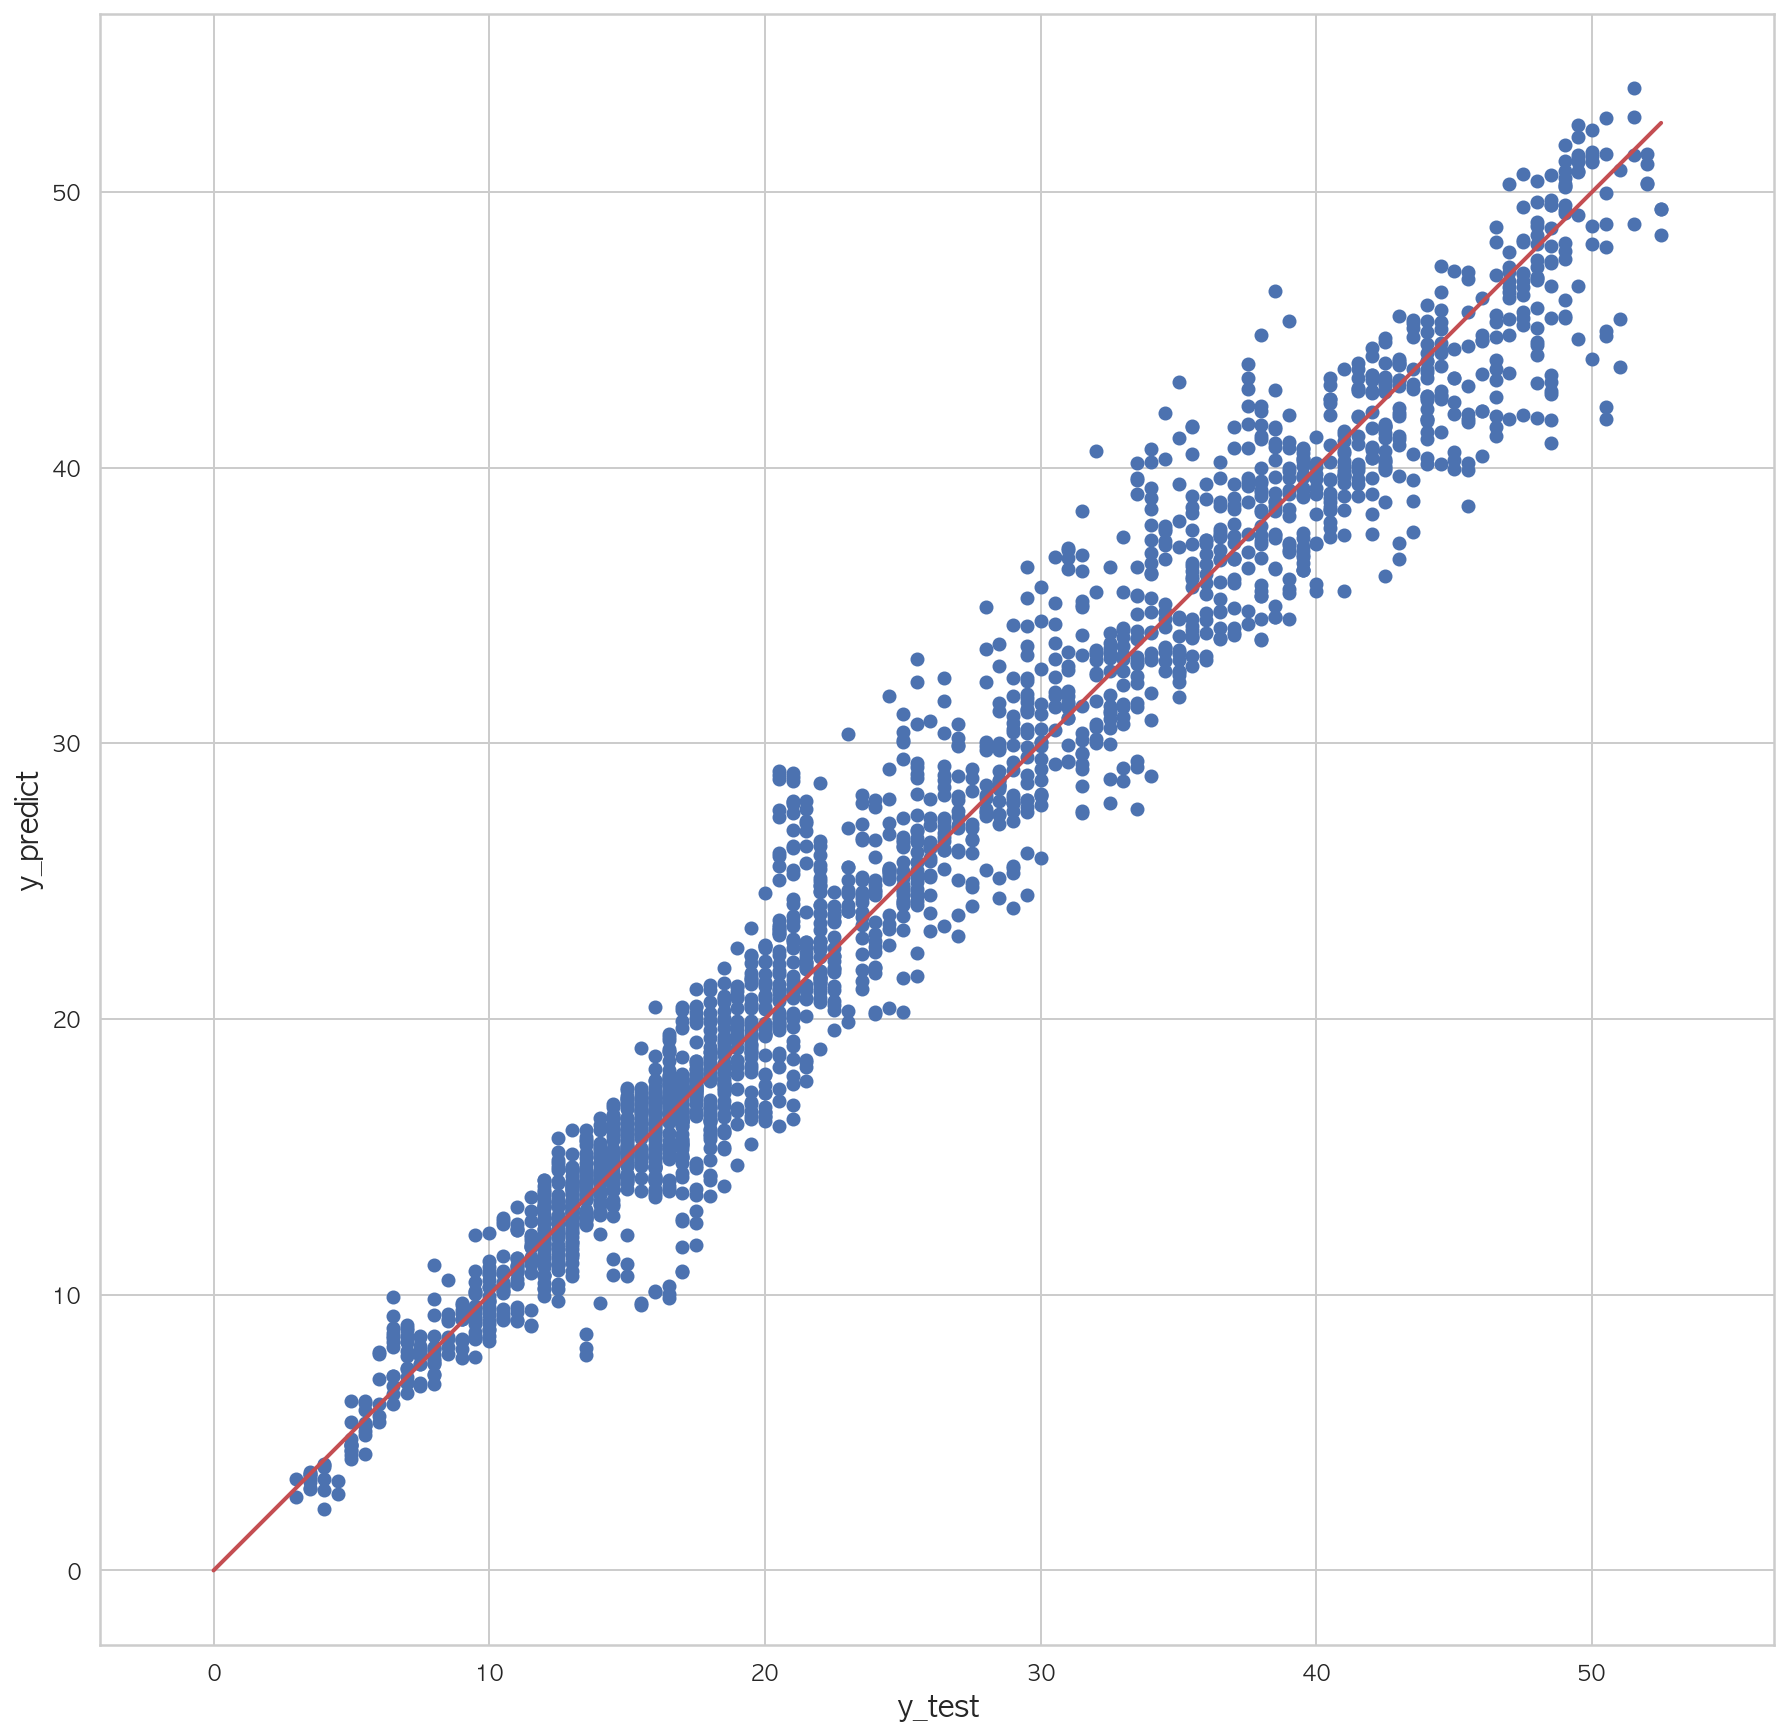

In [88]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y11'], pred)
plt.plot([0, dfX_test['Y11'].max()], [0, dfX_test['Y11'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [89]:
Y12_df = pd.concat([X_30s, sensor['Y12']], axis=1)

N = len(Y12_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y12_df.iloc[idx_train]
dfX_test = Y12_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model12 = sm.OLS.from_formula("Y12 ~ 1 +" + a, data=dfX_train)
    result12 = model12.fit()
    
    pred = result12.predict(df_test)
    rss = ((df_test.Y12 - pred) ** 2).sum()
    tss = ((df_test.Y12 - df_test.Y12.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result12.rsquared, rsquared))

pred = result12.predict(dfX_test)
rss = ((dfX_test.Y12 - pred) ** 2).sum()
tss = ((dfX_test.Y12 - dfX_test.Y12.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.93043914, 검증 R2 = 0.92730076
학습 R2 = 0.93043914, 검증 R2 = 0.92779232
학습 R2 = 0.93043914, 검증 R2 = 0.93719237
학습 R2 = 0.93043914, 검증 R2 = 0.92444176
학습 R2 = 0.93043914, 검증 R2 = 0.93435359
0.9258530541128716


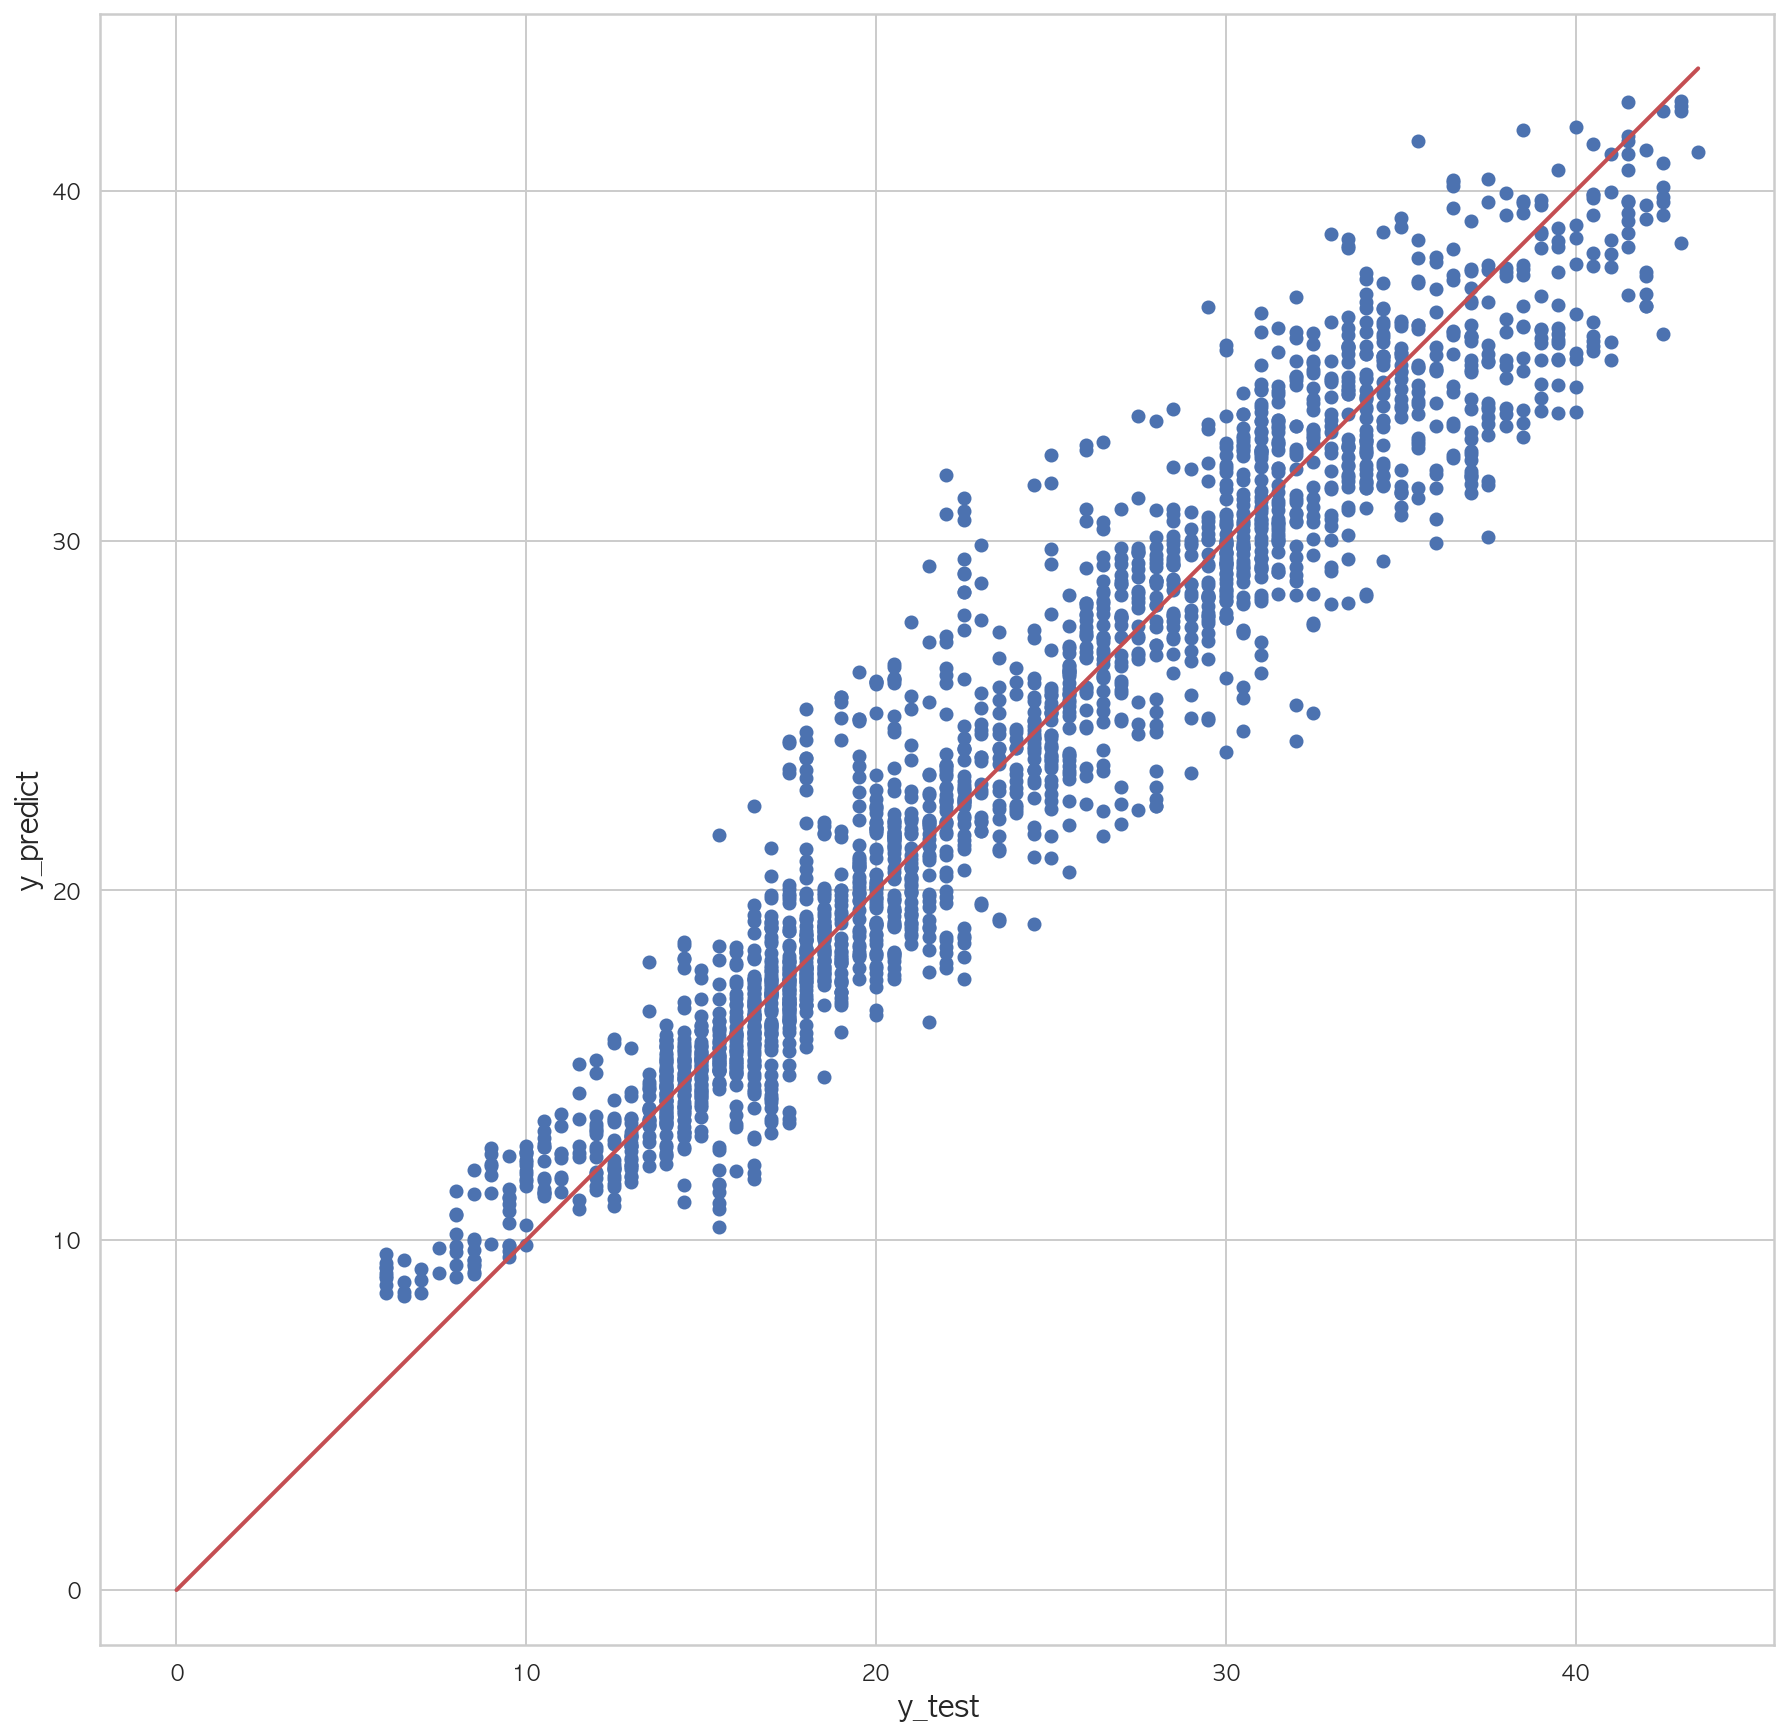

In [90]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y12'], pred)
plt.plot([0, dfX_test['Y12'].max()], [0, dfX_test['Y12'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [91]:
Y13_df = pd.concat([X_30s, sensor['Y13']], axis=1)

N = len(Y13_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y13_df.iloc[idx_train]
dfX_test = Y13_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model13 = sm.OLS.from_formula("Y13 ~ 1 +" + a, data=dfX_train)
    result13 = model13.fit()
    
    pred = result13.predict(df_test)
    rss = ((df_test.Y13 - pred) ** 2).sum()
    tss = ((df_test.Y13 - df_test.Y13.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result13.rsquared, rsquared))

pred = result13.predict(dfX_test)
rss = ((dfX_test.Y13 - pred) ** 2).sum()
tss = ((dfX_test.Y13 - dfX_test.Y13.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.97551170, 검증 R2 = 0.97691878
학습 R2 = 0.97551170, 검증 R2 = 0.97502043
학습 R2 = 0.97551170, 검증 R2 = 0.97650240
학습 R2 = 0.97551170, 검증 R2 = 0.97279838
학습 R2 = 0.97551170, 검증 R2 = 0.97615578
0.9723087570476632


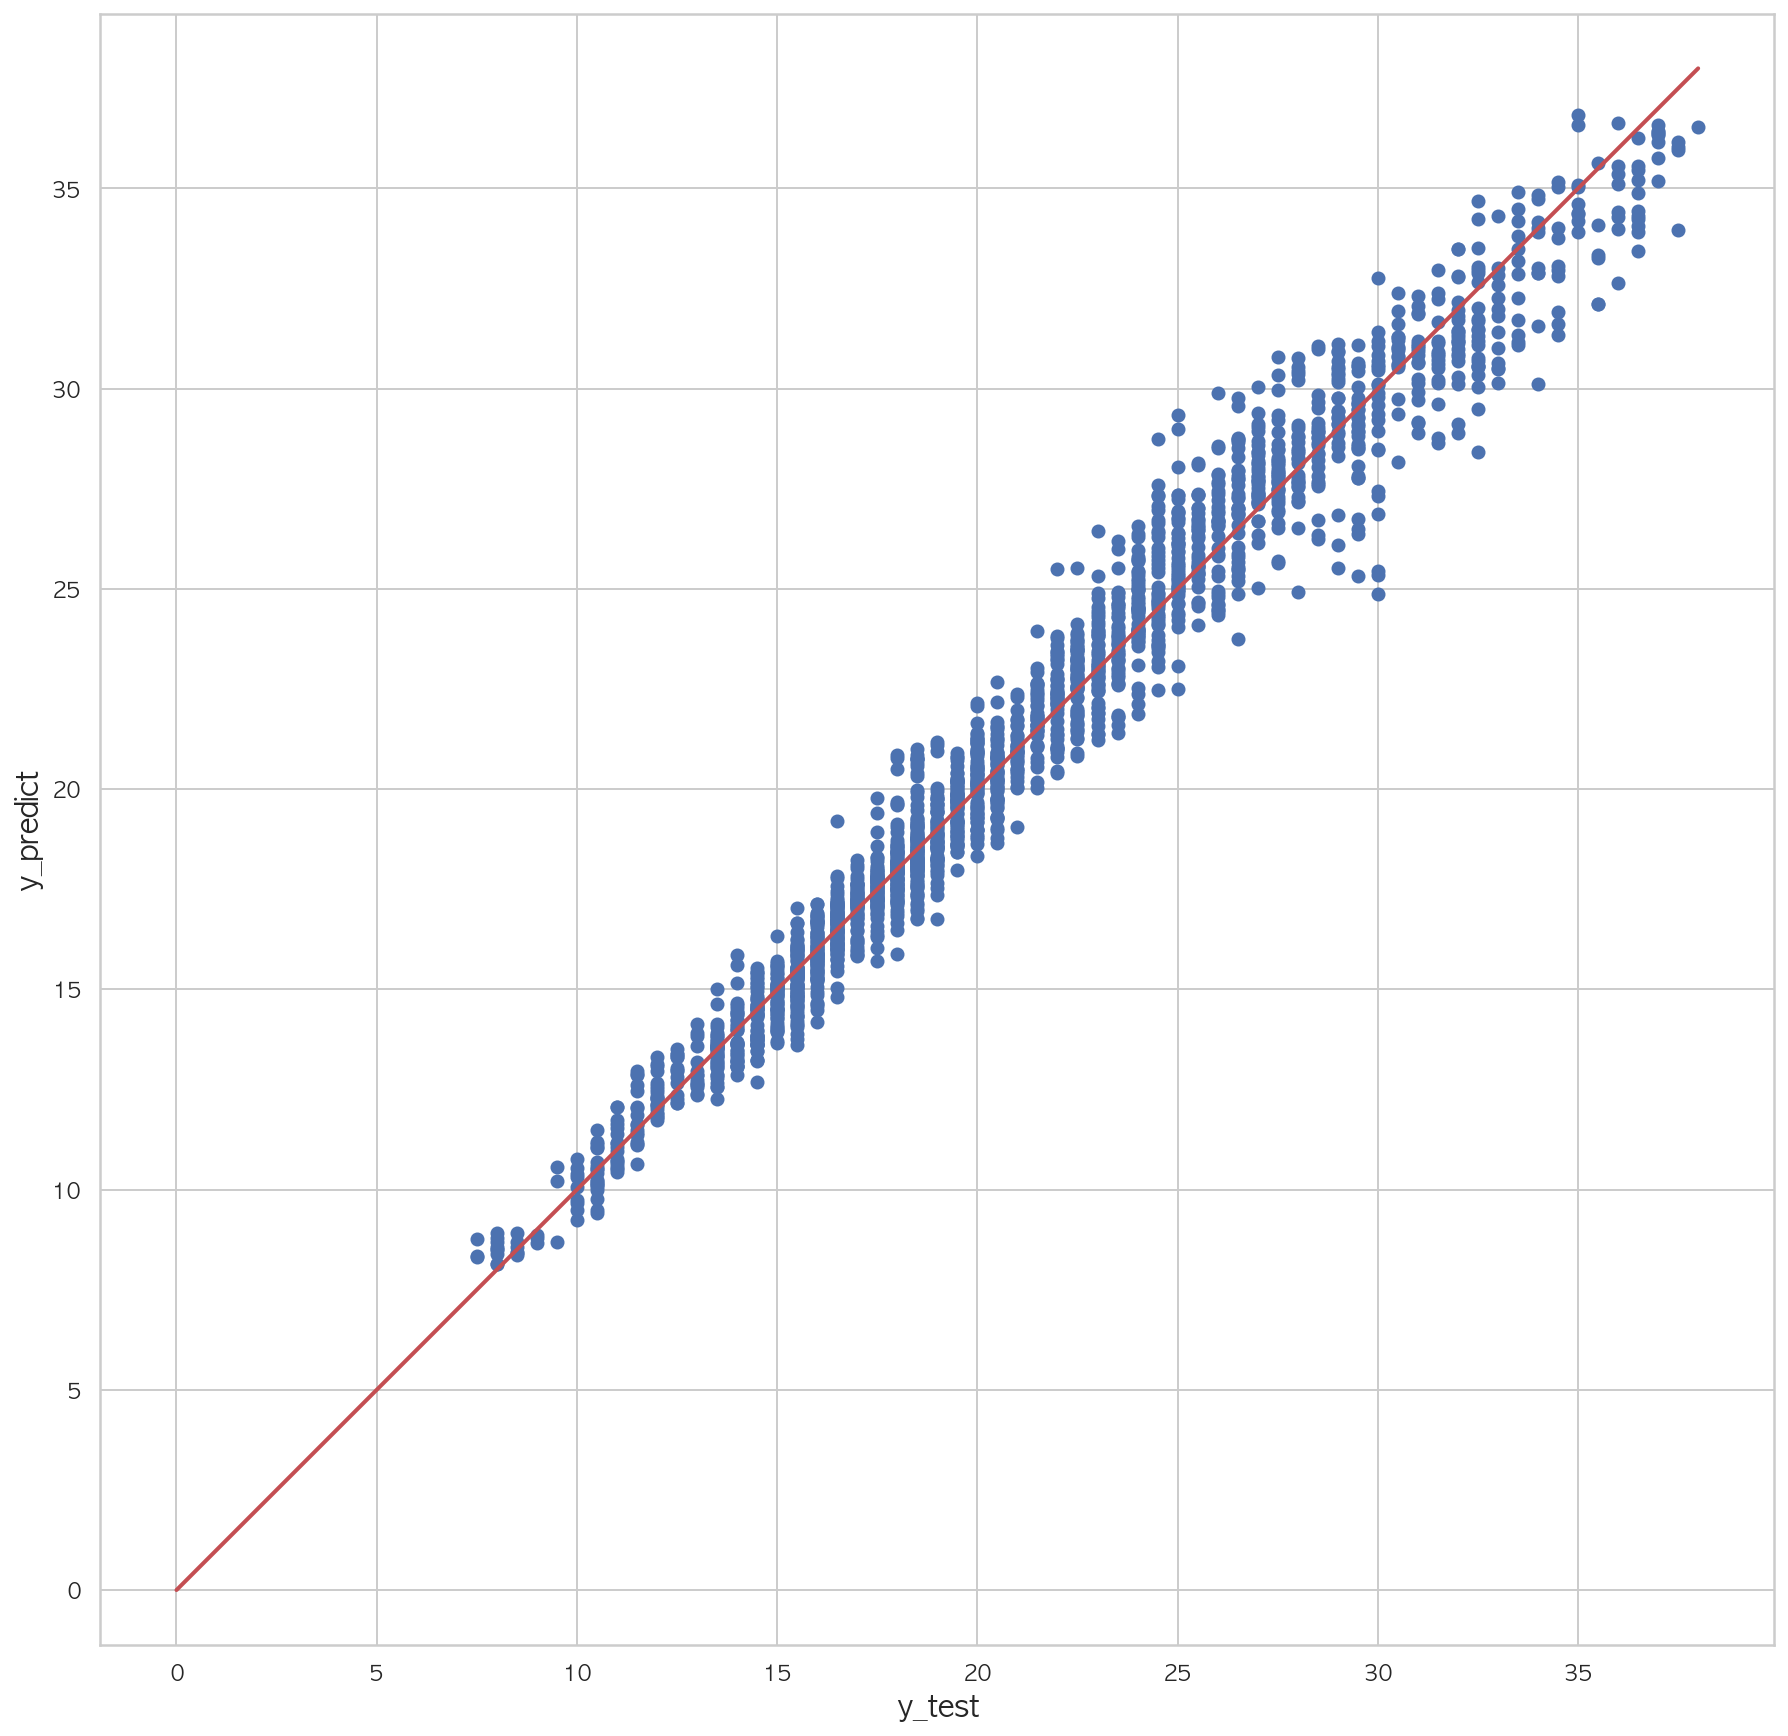

In [92]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y13'], pred)
plt.plot([0, dfX_test['Y13'].max()], [0, dfX_test['Y13'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [93]:
Y14_df = pd.concat([X_30s, sensor['Y14']], axis=1)

N = len(Y14_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y14_df.iloc[idx_train]
dfX_test = Y14_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model14 = sm.OLS.from_formula("Y14 ~ 1 +" + a, data=dfX_train)
    result14 = model14.fit()
    
    pred = result14.predict(df_test)
    rss = ((df_test.Y14 - pred) ** 2).sum()
    tss = ((df_test.Y14 - df_test.Y14.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result14.rsquared, rsquared))

pred = result14.predict(dfX_test)
rss = ((dfX_test.Y14 - pred) ** 2).sum()
tss = ((dfX_test.Y14 - dfX_test.Y14.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.95055229, 검증 R2 = 0.95174316
학습 R2 = 0.95055229, 검증 R2 = 0.95003596
학습 R2 = 0.95055229, 검증 R2 = 0.95233452
학습 R2 = 0.95055229, 검증 R2 = 0.94609319
학습 R2 = 0.95055229, 검증 R2 = 0.95207706
0.9433902924785645


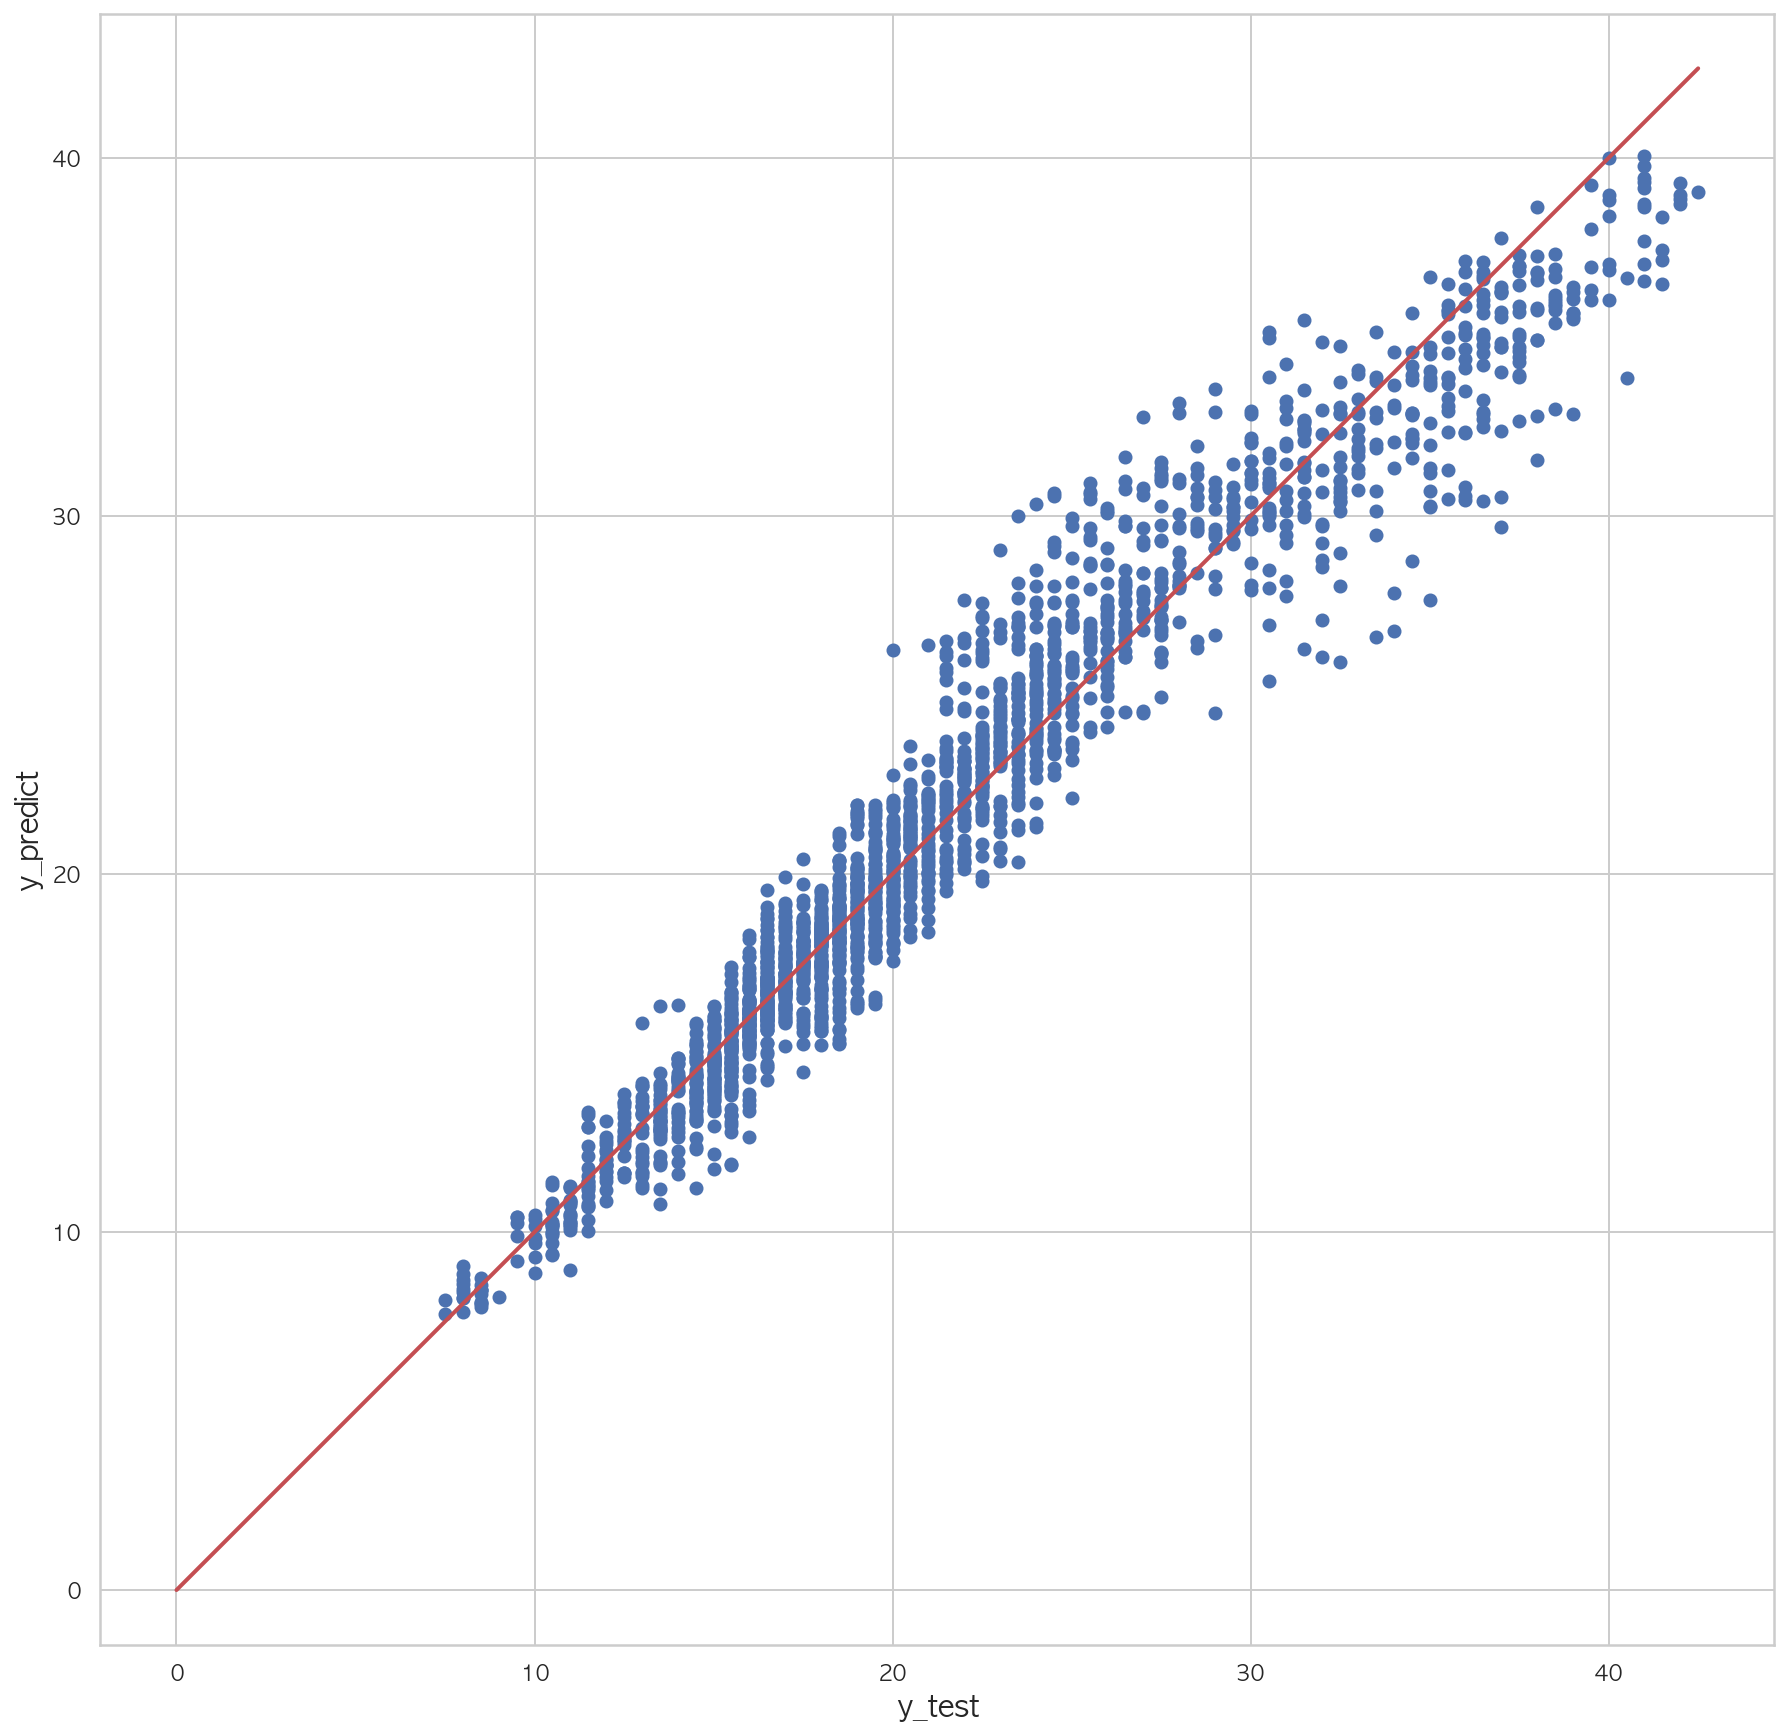

In [94]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y14'], pred)
plt.plot([0, dfX_test['Y14'].max()], [0, dfX_test['Y14'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show() 

In [95]:
Y15_df = pd.concat([X_30s, sensor['Y15']], axis=1)

N = len(Y15_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y15_df.iloc[idx_train]
dfX_test = Y15_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model15 = sm.OLS.from_formula("Y15 ~ 1 +" + a, data=dfX_train)
    result15 = model15.fit()
    
    pred = result15.predict(df_test)
    rss = ((df_test.Y15 - pred) ** 2).sum()
    tss = ((df_test.Y15 - df_test.Y15.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result15.rsquared, rsquared))

pred = result15.predict(dfX_test)
rss = ((dfX_test.Y15 - pred) ** 2).sum()
tss = ((dfX_test.Y15 - dfX_test.Y15.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.97086836, 검증 R2 = 0.97222260
학습 R2 = 0.97086836, 검증 R2 = 0.97190213
학습 R2 = 0.97086836, 검증 R2 = 0.96797335
학습 R2 = 0.97086836, 검증 R2 = 0.97158117
학습 R2 = 0.97086836, 검증 R2 = 0.97070777
0.9673690894807192


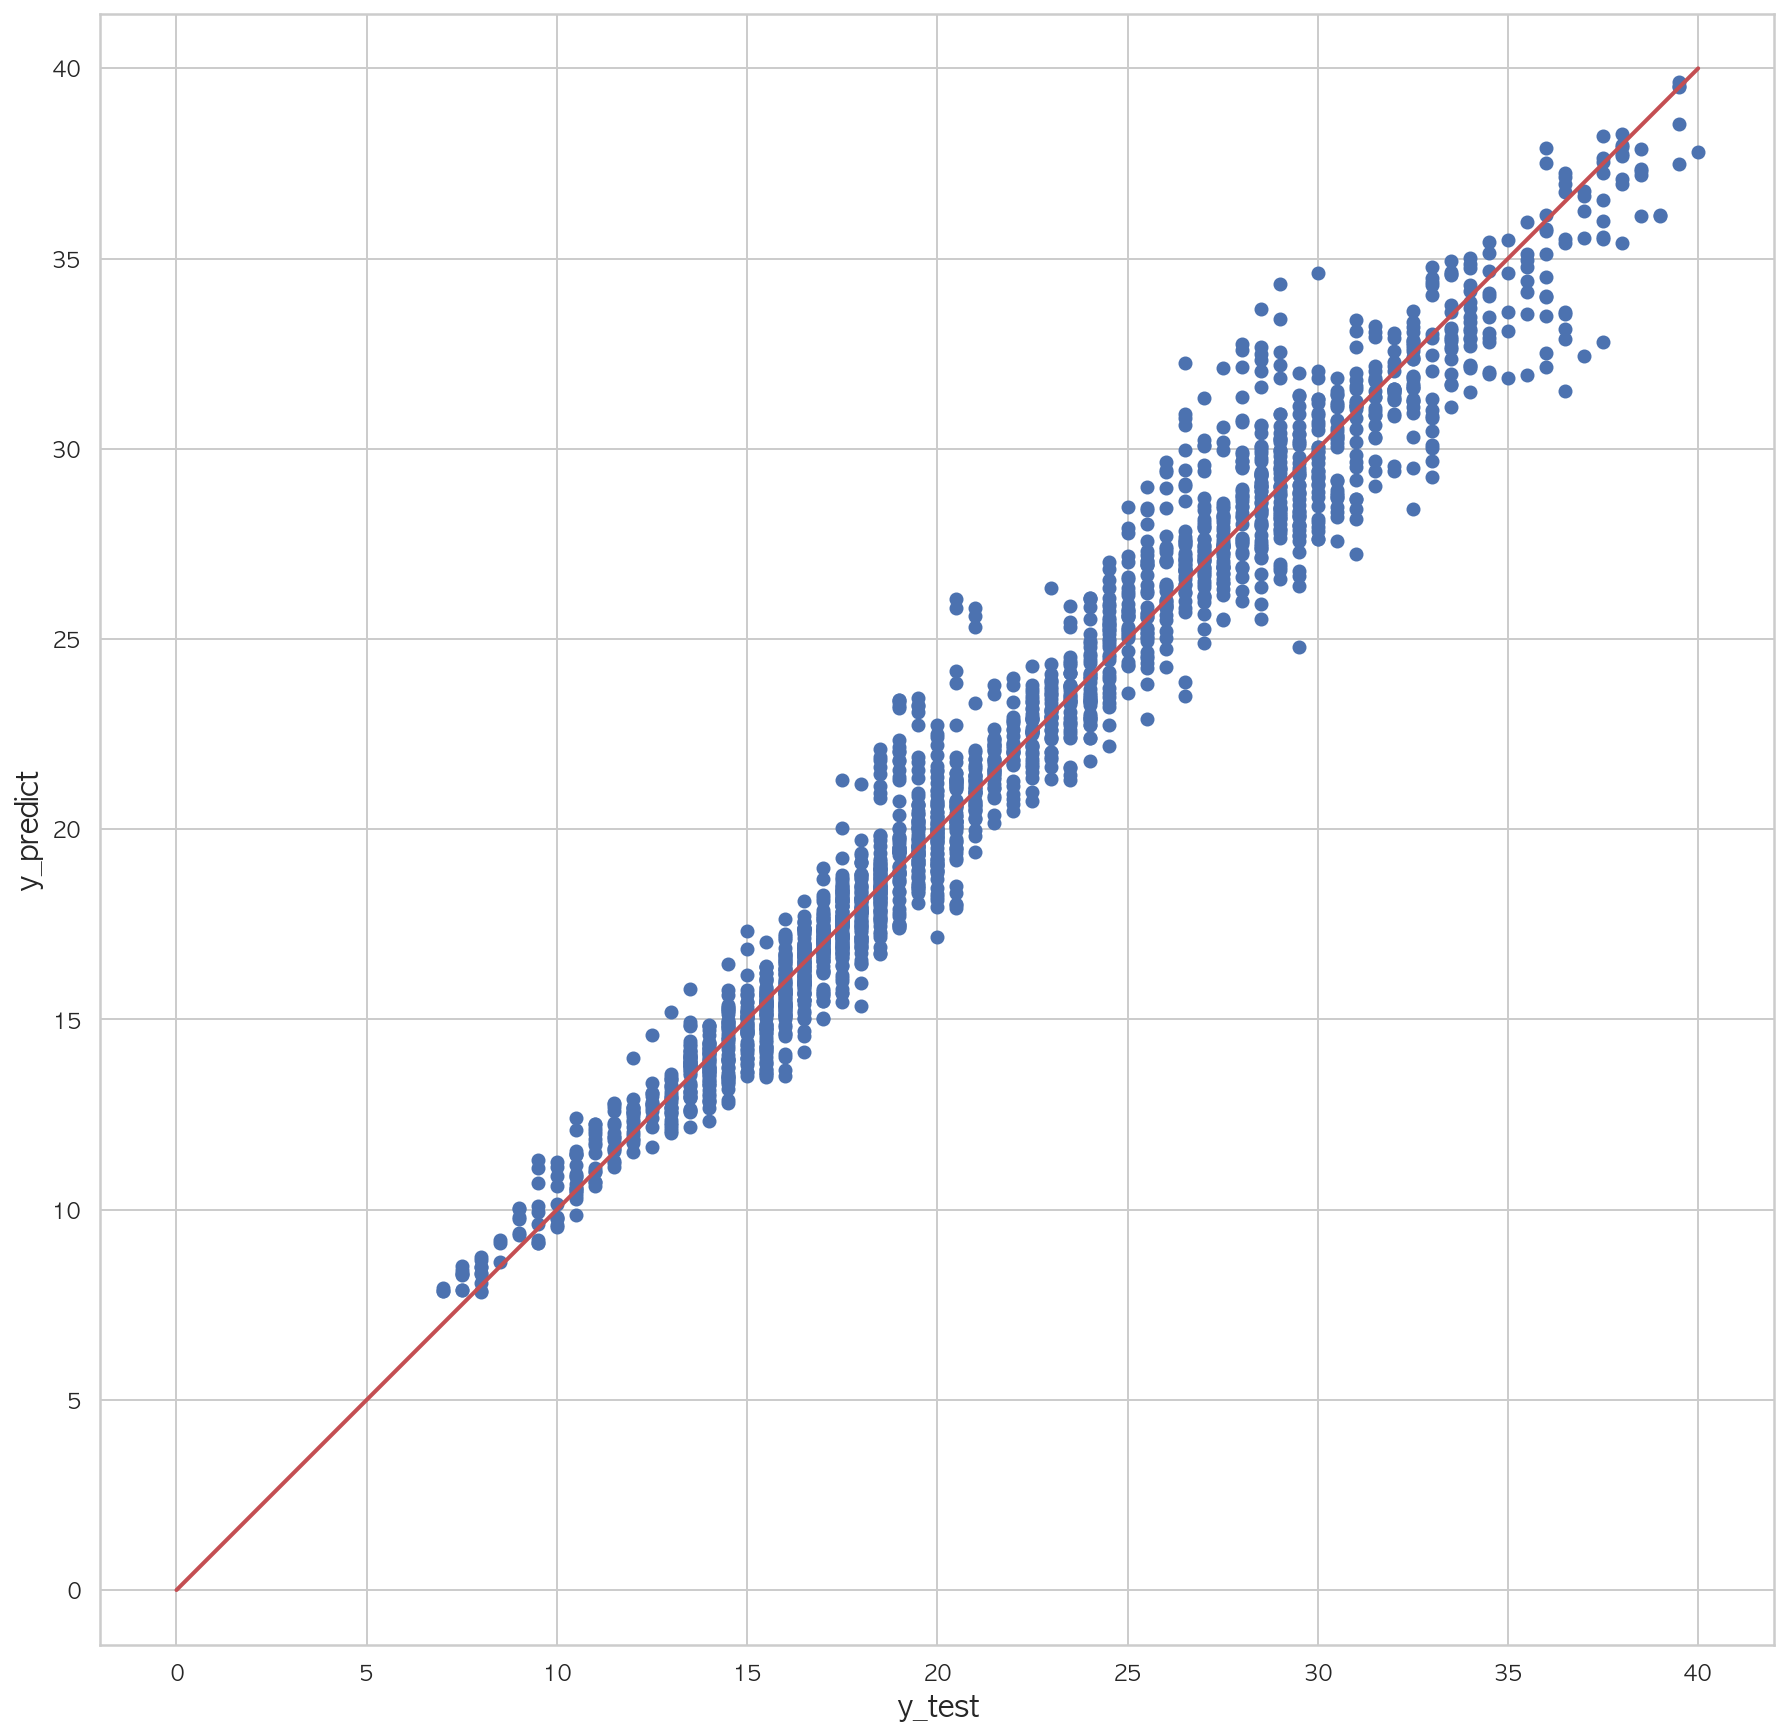

In [96]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y15'], pred)
plt.plot([0, dfX_test['Y15'].max()], [0, dfX_test['Y15'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [97]:
Y16_df = pd.concat([X_30s, sensor['Y16']], axis=1)

N = len(Y16_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y16_df.iloc[idx_train]
dfX_test = Y16_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model16 = sm.OLS.from_formula("Y16 ~ 1 +" + a, data=dfX_train)
    result16 = model16.fit()
    b
    pred = result16.predict(df_test)
    rss = ((df_test.Y16 - pred) ** 2).sum()
    tss = ((df_test.Y16 - df_test.Y16.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result16.rsquared, rsquared))

pred = result16.predict(dfX_test)
rss = ((dfX_test.Y16 - pred) ** 2).sum()
tss = ((dfX_test.Y16 - dfX_test.Y16.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.96814730, 검증 R2 = 0.96684993
학습 R2 = 0.96814730, 검증 R2 = 0.96568806
학습 R2 = 0.96814730, 검증 R2 = 0.96983776
학습 R2 = 0.96814730, 검증 R2 = 0.96852404
학습 R2 = 0.96814730, 검증 R2 = 0.96930078
0.9635284816353513


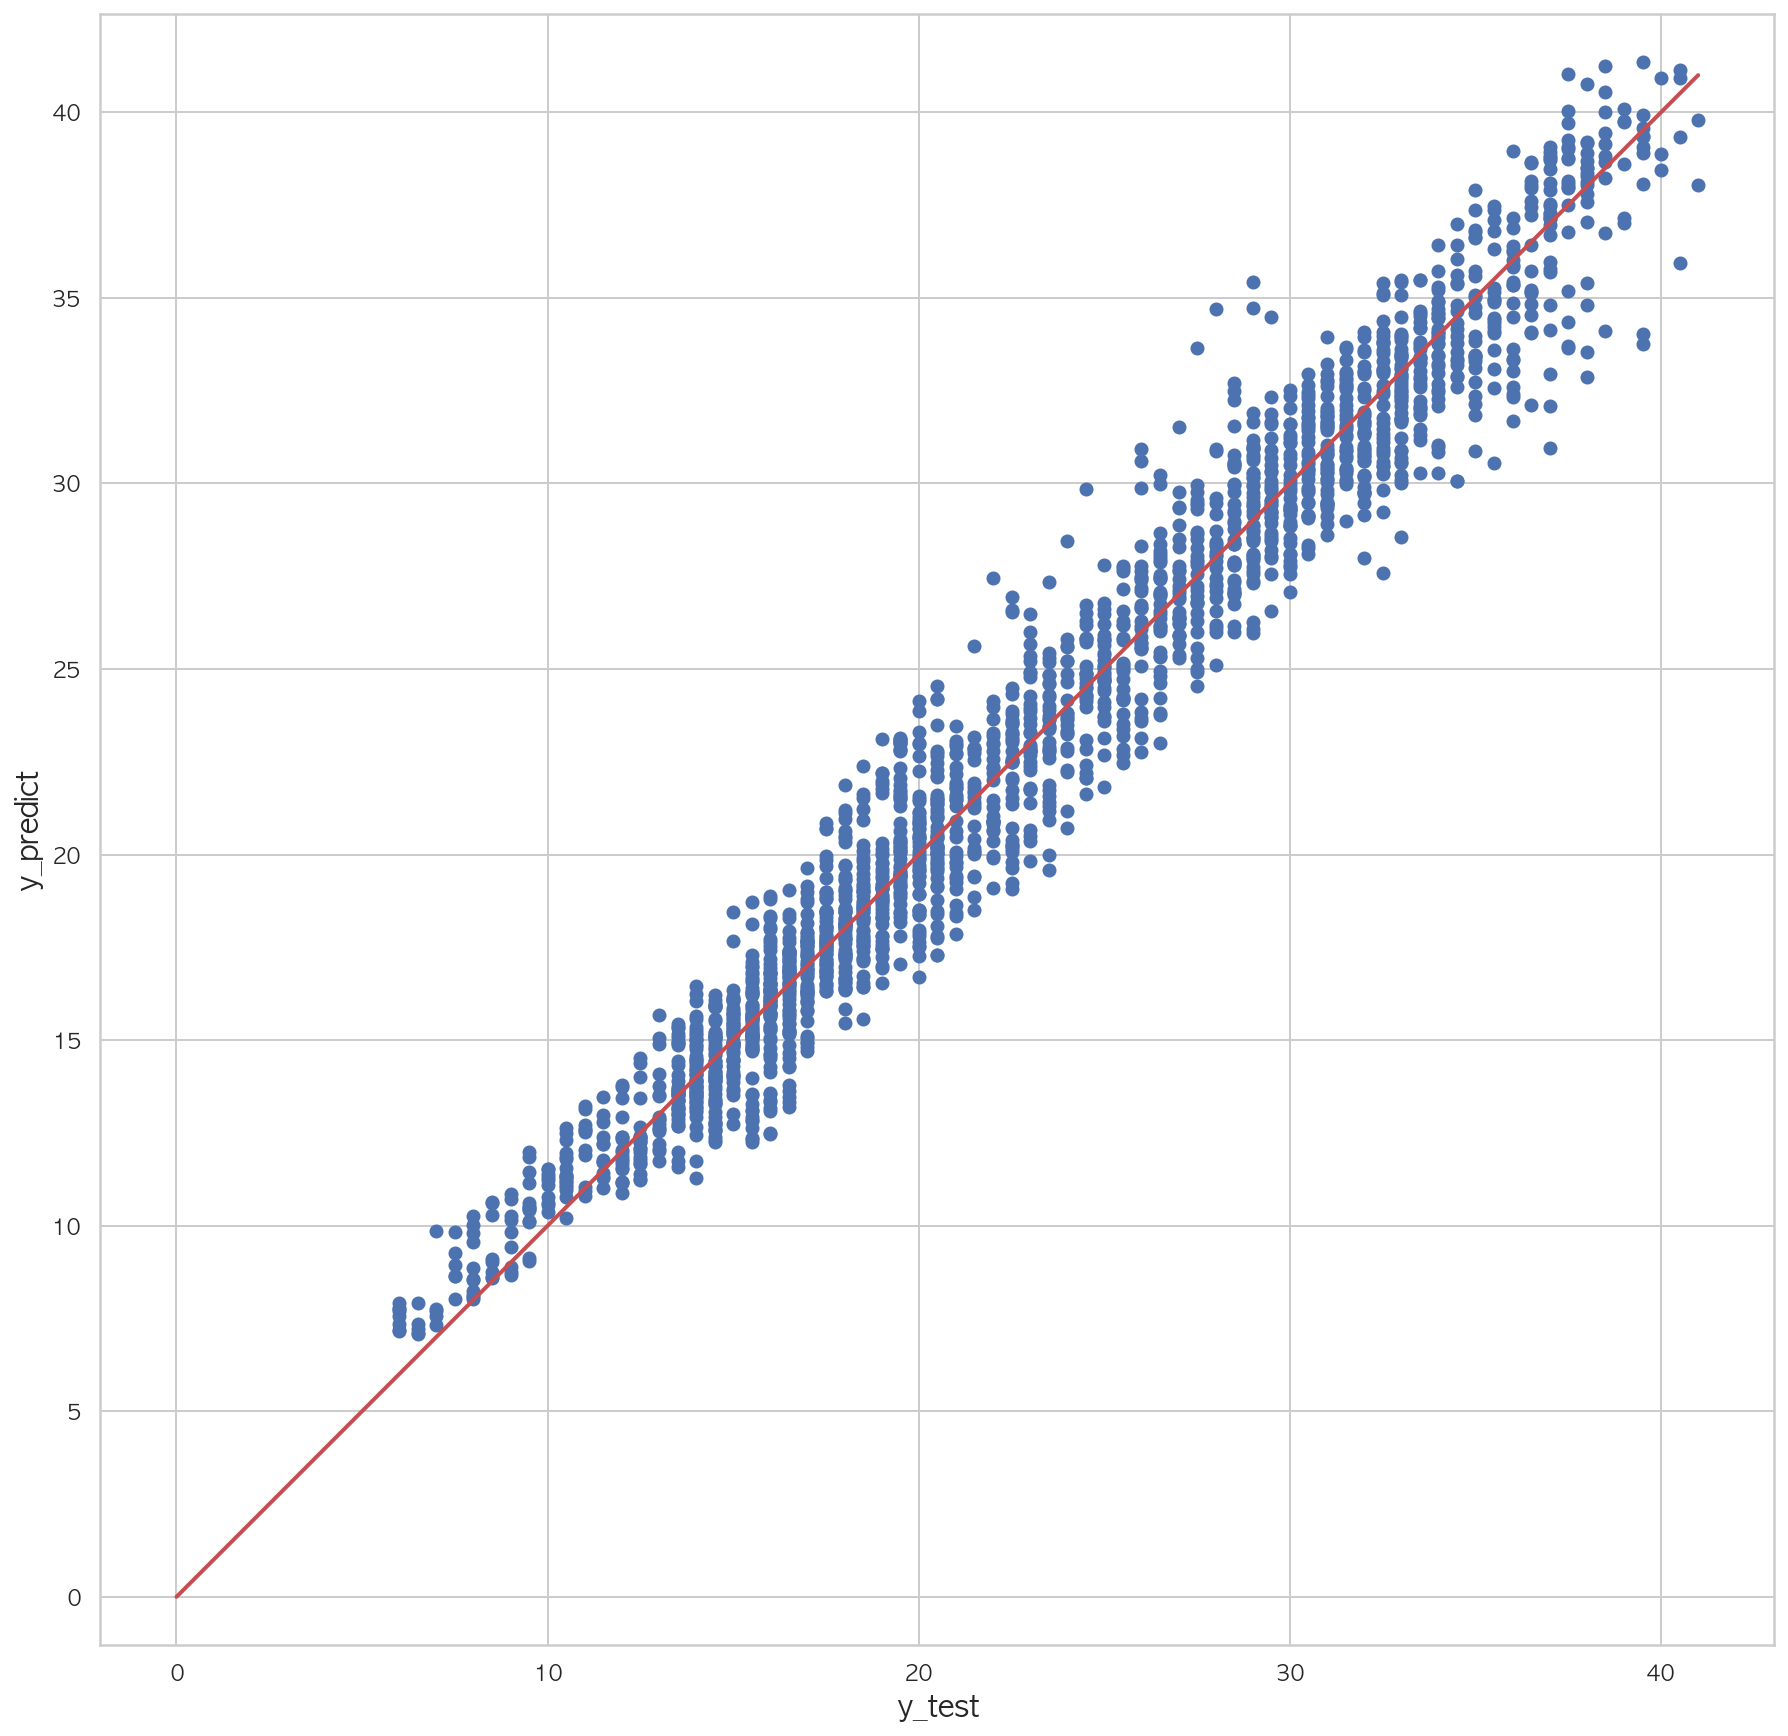

In [99]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y16'], pred)
plt.plot([0, dfX_test['Y16'].max()], [0, dfX_test['Y16'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [100]:
Y17_df = pd.concat([X_30s, sensor['Y17']], axis=1)

N = len(Y17_df)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y17_df.iloc[idx_train]
dfX_test = Y17_df.iloc[idx_test]

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model17 = sm.OLS.from_formula("Y17 ~ 1 +" + a, data=dfX_train)
    result17 = model17.fit()
    
    pred = result17.predict(df_test)
    rss = ((df_test.Y17 - pred) ** 2).sum()
    tss = ((df_test.Y17 - df_test.Y17.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result17.rsquared, rsquared))

pred = result17.predict(dfX_test)
rss = ((dfX_test.Y17 - pred) ** 2).sum()
tss = ((dfX_test.Y17 - dfX_test.Y17.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)

학습 R2 = 0.95399940, 검증 R2 = 0.95549371
학습 R2 = 0.95399940, 검증 R2 = 0.95233226
학습 R2 = 0.95399940, 검증 R2 = 0.95487363
학습 R2 = 0.95399940, 검증 R2 = 0.95520874
학습 R2 = 0.95399940, 검증 R2 = 0.95170376
0.9495062343625932


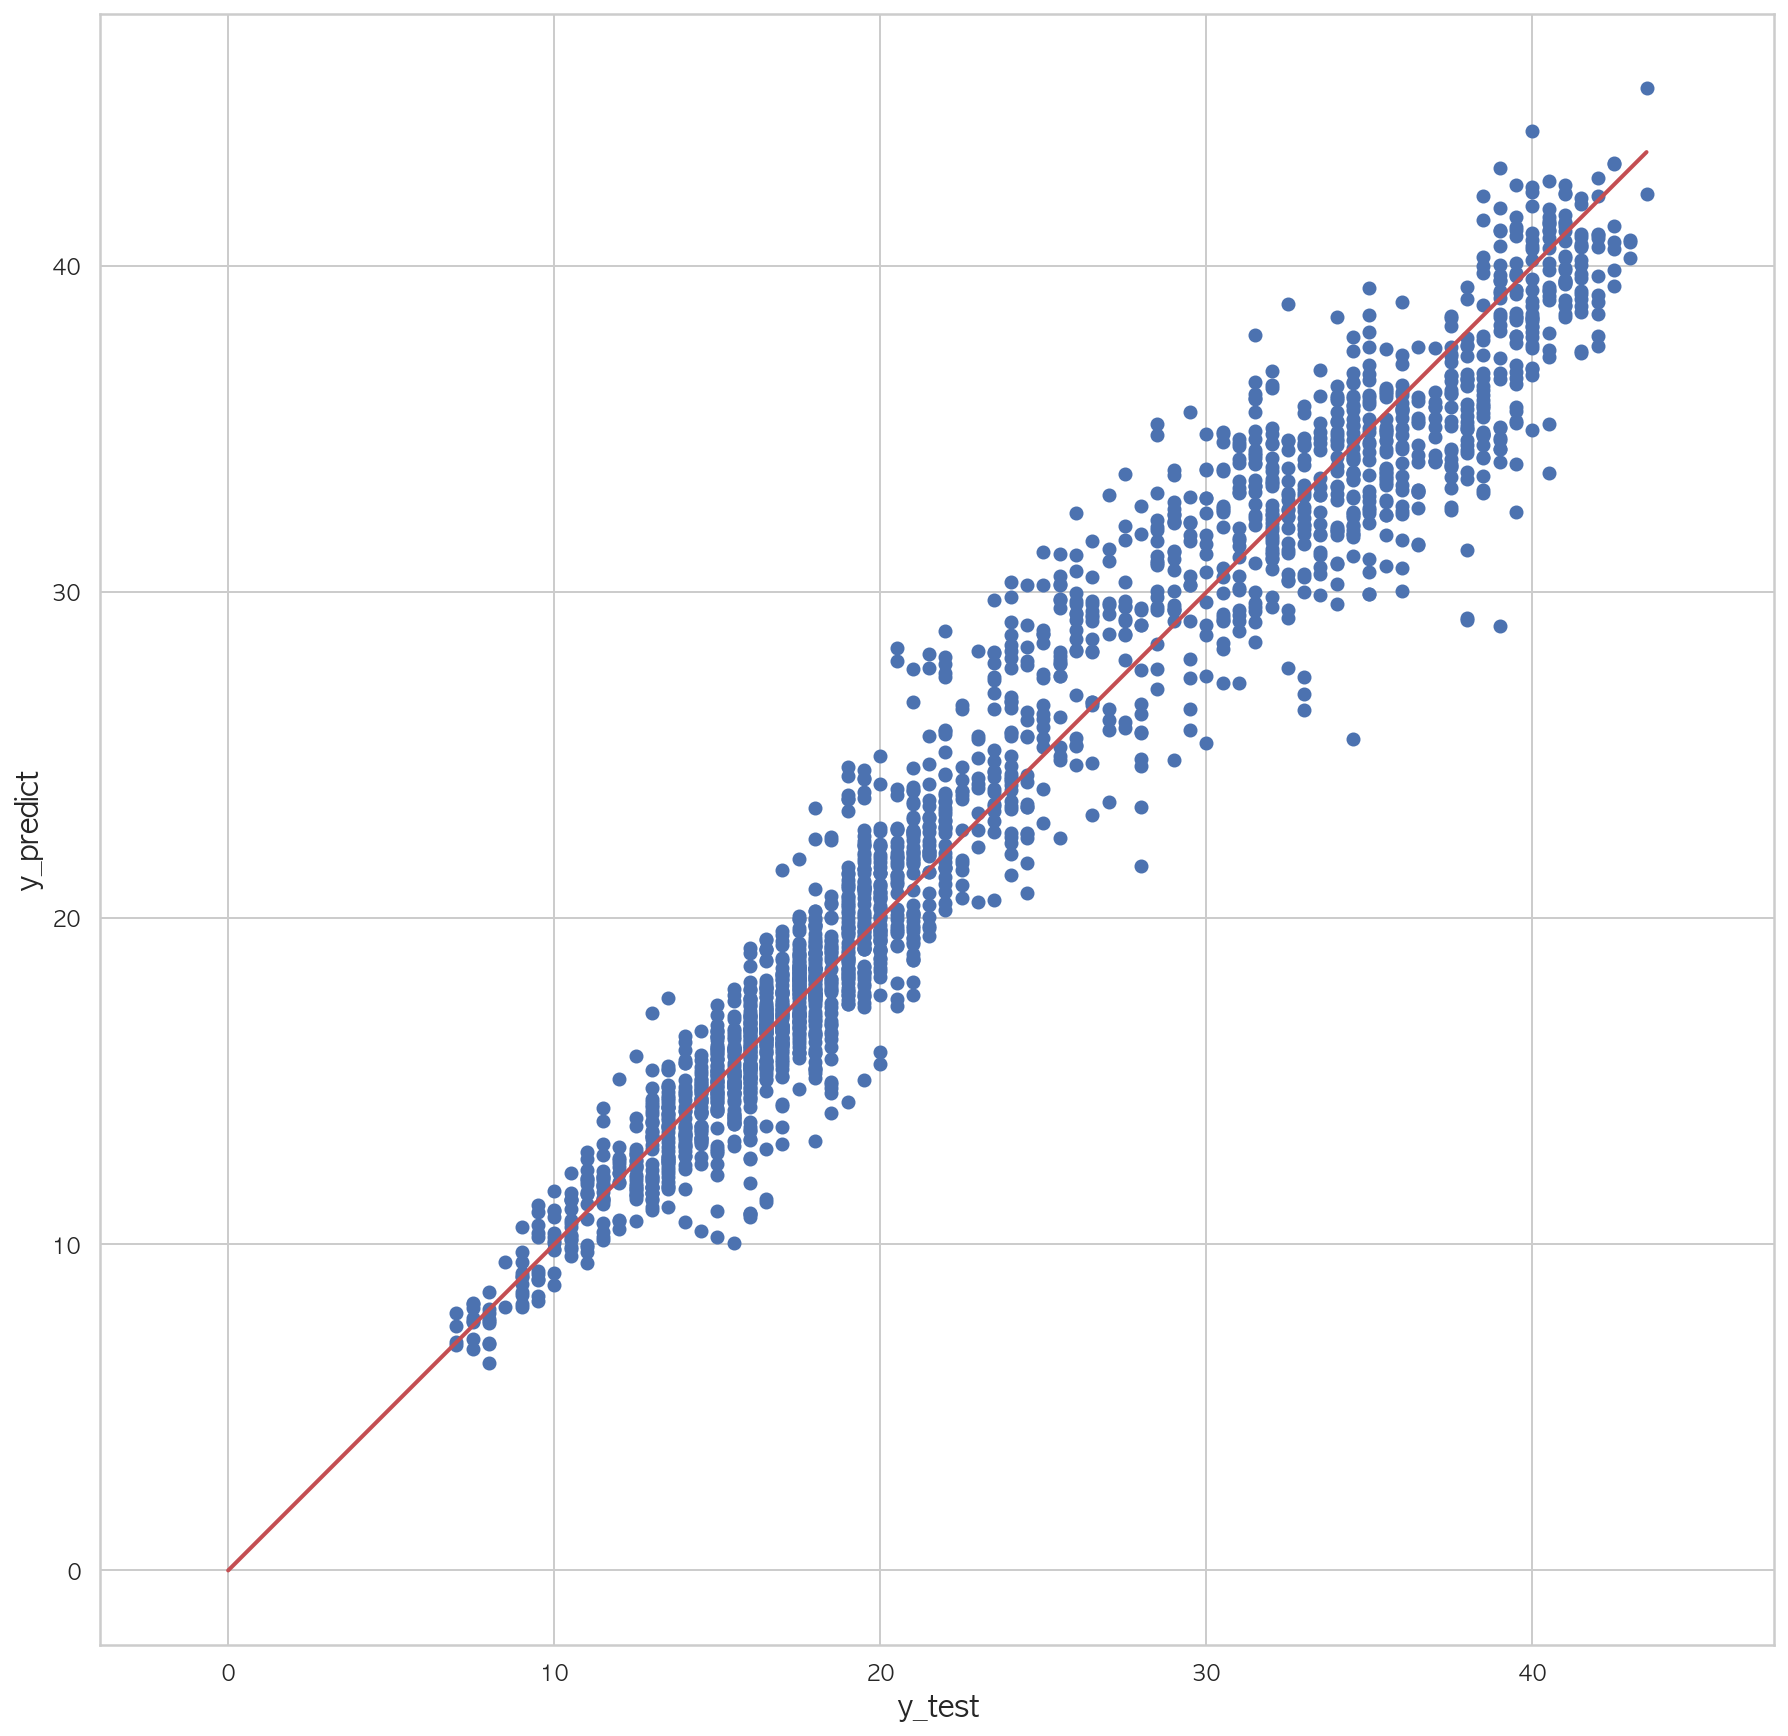

In [102]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y17'], pred)
plt.plot([0, dfX_test['Y17'].max()], [0, dfX_test['Y17'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

> ## 모델을 활용한 이후 3일의 Y00~Y17 값 예측

In [103]:
df2 = df.loc[4320:]
df2.dropna(axis=1, inplace=True)
df2

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,...,X32,X33,X34,X35,X36,X37,X38,X39,Y18,hour
4320,4320,19.3,987.7,0.9,2.2,0,1007.7,988.0,20.8,1007.8,...,18.7,1008.3,0.00,3,0,84.0,77.6,0,20.5,0
4321,4321,19.0,987.6,1.9,2.2,0,1007.7,988.0,20.6,1007.8,...,19.0,1008.3,0.00,3,0,84.4,79.2,0,20.5,0
4322,4322,19.1,987.6,2.0,1.4,0,1007.8,988.1,20.5,1007.9,...,19.2,1008.3,0.00,3,0,84.9,79.9,0,20.5,0
4323,4323,19.2,987.7,1.8,1.5,0,1007.9,988.1,20.5,1007.9,...,19.3,1008.4,0.00,3,0,84.9,80.7,0,20.5,0
4324,4324,19.2,987.8,1.4,1.4,0,1007.9,988.1,20.5,1007.8,...,19.5,1008.4,0.00,3,0,84.9,80.9,0,20.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,4747,19.9,987.6,0.9,0.8,0,1006.9,987.7,21.7,1007.5,...,19.1,1007.5,22.16,2,0,82.3,58.6,1,21.5,23
4748,4748,19.9,987.6,0.5,0.7,0,1006.8,987.7,21.6,1007.5,...,19.2,1007.5,22.16,1,0,82.5,59.1,1,21.5,23
4749,4749,19.7,987.7,0.9,0.6,0,1006.9,987.6,21.4,1007.4,...,19.2,1007.5,22.16,2,0,83.0,58.9,1,21.5,23
4750,4750,19.4,987.7,0.9,0.8,0,1006.9,987.8,21.3,1007.6,...,19.3,1007.6,22.16,3,0,83.2,59.8,1,21.5,23


In [104]:
X_3s = df2.drop(columns=['X14', 'X16', 'X19', 'Y18', 'id'], axis=1)

> ## 이후 3일의 기상청데이터

In [105]:
X_3s

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X31,X32,X33,X34,X35,X36,X37,X38,X39,hour
4320,19.3,987.7,0.9,2.2,0,1007.7,988.0,20.8,1007.8,1007.4,...,18.0,18.7,1008.3,0.00,3,0,84.0,77.6,0,0
4321,19.0,987.6,1.9,2.2,0,1007.7,988.0,20.6,1007.8,1007.4,...,17.7,19.0,1008.3,0.00,3,0,84.4,79.2,0,0
4322,19.1,987.6,2.0,1.4,0,1007.8,988.1,20.5,1007.9,1007.4,...,17.4,19.2,1008.3,0.00,3,0,84.9,79.9,0,0
4323,19.2,987.7,1.8,1.5,0,1007.9,988.1,20.5,1007.9,1007.5,...,17.5,19.3,1008.4,0.00,3,0,84.9,80.7,0,0
4324,19.2,987.8,1.4,1.4,0,1007.9,988.1,20.5,1007.8,1007.6,...,17.4,19.5,1008.4,0.00,3,0,84.9,80.9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,19.9,987.6,0.9,0.8,0,1006.9,987.7,21.7,1007.5,1007.4,...,17.7,19.1,1007.5,22.16,2,0,82.3,58.6,1,23
4748,19.9,987.6,0.5,0.7,0,1006.8,987.7,21.6,1007.5,1007.4,...,17.7,19.2,1007.5,22.16,1,0,82.5,59.1,1,23
4749,19.7,987.7,0.9,0.6,0,1006.9,987.6,21.4,1007.4,1007.5,...,17.8,19.2,1007.5,22.16,2,0,83.0,58.9,1,23
4750,19.4,987.7,0.9,0.8,0,1006.9,987.8,21.3,1007.6,1007.5,...,17.7,19.3,1007.6,22.16,3,0,83.2,59.8,1,23


In [106]:
model0 = sm.OLS.from_formula("Y00 ~ 1 +" + a, data=Y00_df)
model1 = sm.OLS.from_formula("Y01 ~ 1 +" + a, data=Y01_df)
model2 = sm.OLS.from_formula("Y02 ~ 1 +" + a, data=Y02_df)
model3 = sm.OLS.from_formula("Y03 ~ 1 +" + a, data=Y03_df)
model4 = sm.OLS.from_formula("Y04 ~ 1 +" + a, data=Y04_df)
model5 = sm.OLS.from_formula("Y05 ~ 1 +" + a, data=Y05_df)
model6 = sm.OLS.from_formula("Y06 ~ 1 +" + a, data=Y06_df)
model7 = sm.OLS.from_formula("Y07 ~ 1 +" + a, data=Y07_df)
model8 = sm.OLS.from_formula("Y08 ~ 1 +" + a, data=Y08_df)
model9 = sm.OLS.from_formula("Y09 ~ 1 +" + a, data=Y09_df)
mode110 = sm.OLS.from_formula("Y10 ~ 1 +" + a, data=Y10_df)
model11 = sm.OLS.from_formula("Y11 ~ 1 +" + a, data=Y11_df)
model12 = sm.OLS.from_formula("Y12 ~ 1 +" + a, data=Y12_df)
model13 = sm.OLS.from_formula("Y13 ~ 1 +" + a, data=Y13_df)
model14 = sm.OLS.from_formula("Y14 ~ 1 +" + a, data=Y14_df)
model15 = sm.OLS.from_formula("Y15 ~ 1 +" + a, data=Y15_df)
model16 = sm.OLS.from_formula("Y16 ~ 1 +" + a, data=Y16_df)
model17 = sm.OLS.from_formula("Y17 ~ 1 +" + a, data=Y17_df)

In [107]:
models = [model0, model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12, model13, model14, model15, model16, model17]

In [108]:
Y_pred = []

for model in models:
    result = model.fit()
    result = result.predict(X_3s).round(2)
    Y_pred.append(result)
Y_pred

[4320    21.36
 4321    21.25
 4322    21.09
 4323    21.03
 4324    21.02
         ...  
 4747    22.56
 4748    22.44
 4749    22.21
 4750    22.13
 4751    22.02
 Length: 432, dtype: float64, 4320    21.83
 4321    21.55
 4322    21.57
 4323    21.35
 4324    21.42
         ...  
 4747    22.25
 4748    21.99
 4749    22.06
 4750    21.82
 4751    21.43
 Length: 432, dtype: float64, 4320    21.58
 4321    21.42
 4322    21.38
 4323    21.30
 4324    21.37
         ...  
 4747    22.03
 4748    21.86
 4749    21.73
 4750    21.50
 4751    21.34
 Length: 432, dtype: float64, 4320    25.63
 4321    25.49
 4322    25.48
 4323    25.24
 4324    25.25
         ...  
 4747    27.11
 4748    27.09
 4749    27.02
 4750    26.94
 4751    26.84
 Length: 432, dtype: float64, 4320    25.70
 4321    25.52
 4322    25.47
 4323    25.24
 4324    25.24
         ...  
 4747    27.18
 4748    27.14
 4749    27.07
 4750    26.95
 4751    26.84
 Length: 432, dtype: float64, 4320    20.22
 4321    19.86


In [109]:
Y = []
for x in range(18):
    if x < 10:
        result = 'Y0' + str(x)
        Y.append(result)
    elif x >= 10:
        result = 'Y' + str(x)
        Y.append(result)
Y

['Y00',
 'Y01',
 'Y02',
 'Y03',
 'Y04',
 'Y05',
 'Y06',
 'Y07',
 'Y08',
 'Y09',
 'Y10',
 'Y11',
 'Y12',
 'Y13',
 'Y14',
 'Y15',
 'Y16',
 'Y17']

In [110]:
Y_pred = pd.DataFrame(Y_pred)
Y_pred = Y_pred.T
Y_pred.columns =  Y
Y_pred['hour'] = df2['hour']
Y_pred['Y18'] = df2['Y18']
Y_pred

,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,hour,Y18
4320,21.36,21.83,21.58,25.63,25.70,20.22,18.43,18.44,20.46,19.21,20.82,19.03,18.23,19.66,20.33,19.40,18.74,19.58,0,20.5
4321,21.25,21.55,21.42,25.49,25.52,19.86,18.65,19.08,19.56,18.63,19.94,18.60,18.58,19.08,19.07,18.95,18.63,18.57,0,20.5
4322,21.09,21.57,21.38,25.48,25.47,20.11,18.50,18.90,19.49,18.35,20.01,18.53,18.58,18.87,18.58,18.74,18.52,18.37,0,20.5
4323,21.03,21.35,21.30,25.24,25.24,20.02,18.72,19.42,19.72,18.45,19.85,18.48,18.69,18.87,18.80,18.78,18.57,18.78,0,20.5
4324,21.02,21.42,21.37,25.25,25.24,19.95,18.67,19.29,19.72,18.49,19.92,18.49,18.63,18.79,18.74,18.72,18.60,18.75,0,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,22.56,22.25,22.03,27.11,27.18,19.51,17.86,18.67,18.71,17.77,19.15,17.62,18.96,19.37,19.84,19.04,17.95,17.98,23,21.5
4748,22.44,21.99,21.86,27.09,27.14,19.39,17.81,18.59,18.73,17.91,19.29,17.78,18.77,19.34,19.96,19.08,17.98,18.20,23,21.5
4749,22.21,22.06,21.73,27.02,27.07,19.28,17.76,18.41,18.45,17.91,19.85,17.58,18.65,19.27,19.91,19.07,17.88,18.21,23,21.5
4750,22.13,21.82,21.50,26.94,26.95,19.29,17.75,18.50,18.41,17.53,19.29,17.32,18.76,19.20,19.73,18.80,17.84,17.78,23,21.5


In [113]:
b = list(Y_pred.columns)
b.remove('Y18')
b.remove('hour')
b = ['scale({})'.format(x) for x in b]
'+'.join(b)

'scale(Y00)+scale(Y01)+scale(Y02)+scale(Y03)+scale(Y04)+scale(Y05)+scale(Y06)+scale(Y07)+scale(Y08)+scale(Y09)+scale(Y10)+scale(Y11)+scale(Y12)+scale(Y13)+scale(Y14)+scale(Y15)+scale(Y16)+scale(Y17)'

> ## Y00 ~ Y17로 Y18 예측 모델 만들기
- 스케일링, formula

In [52]:
model20 = sm.OLS.from_formula("Y18 ~ 1 +" + '+'.join(b), Y_pred)
result20 = model20.fit()
print(result20.summary())

                            OLS Regression Results                            
Dep. Variable:                    Y18   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     495.8
Date:                Mon, 13 Apr 2020   Prob (F-statistic):          1.52e-266
Time:                        15:30:41   Log-Likelihood:                -733.14
No. Observations:                 432   AIC:                             1504.
Df Residuals:                     413   BIC:                             1582.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.6875      0.065    410.667      0.0

In [111]:
N = len(Y_pred)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = Y_pred.iloc[idx_train]
dfX_test = Y_pred.iloc[idx_test]

> ## Y18 모델 KFold 검증

In [118]:
scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(kfold.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model20 = sm.OLS.from_formula("Y18 ~ 1 +" + '+'.join(b), data=dfX_train)
    result20 = model20.fit()
    
    pred = result20.predict(df_test)
    rss = ((df_test.Y18 - pred) ** 2).sum()
    tss = ((df_test.Y18 - df_test.Y18.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result20.rsquared, rsquared))

pred = result20.predict(dfX_test)
rss = ((dfX_test.Y18 - pred) ** 2).sum()
tss = ((dfX_test.Y18 - dfX_test.Y18.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)
print(mean_squared_error(dfX_test.Y18, pred))

학습 R2 = 0.95404730, 검증 R2 = 0.95265858
학습 R2 = 0.95404730, 검증 R2 = 0.93511920
학습 R2 = 0.95404730, 검증 R2 = 0.96495716
학습 R2 = 0.95404730, 검증 R2 = 0.96417472
학습 R2 = 0.95404730, 검증 R2 = 0.94263016
0.9504900638797171
1.8285570780772598


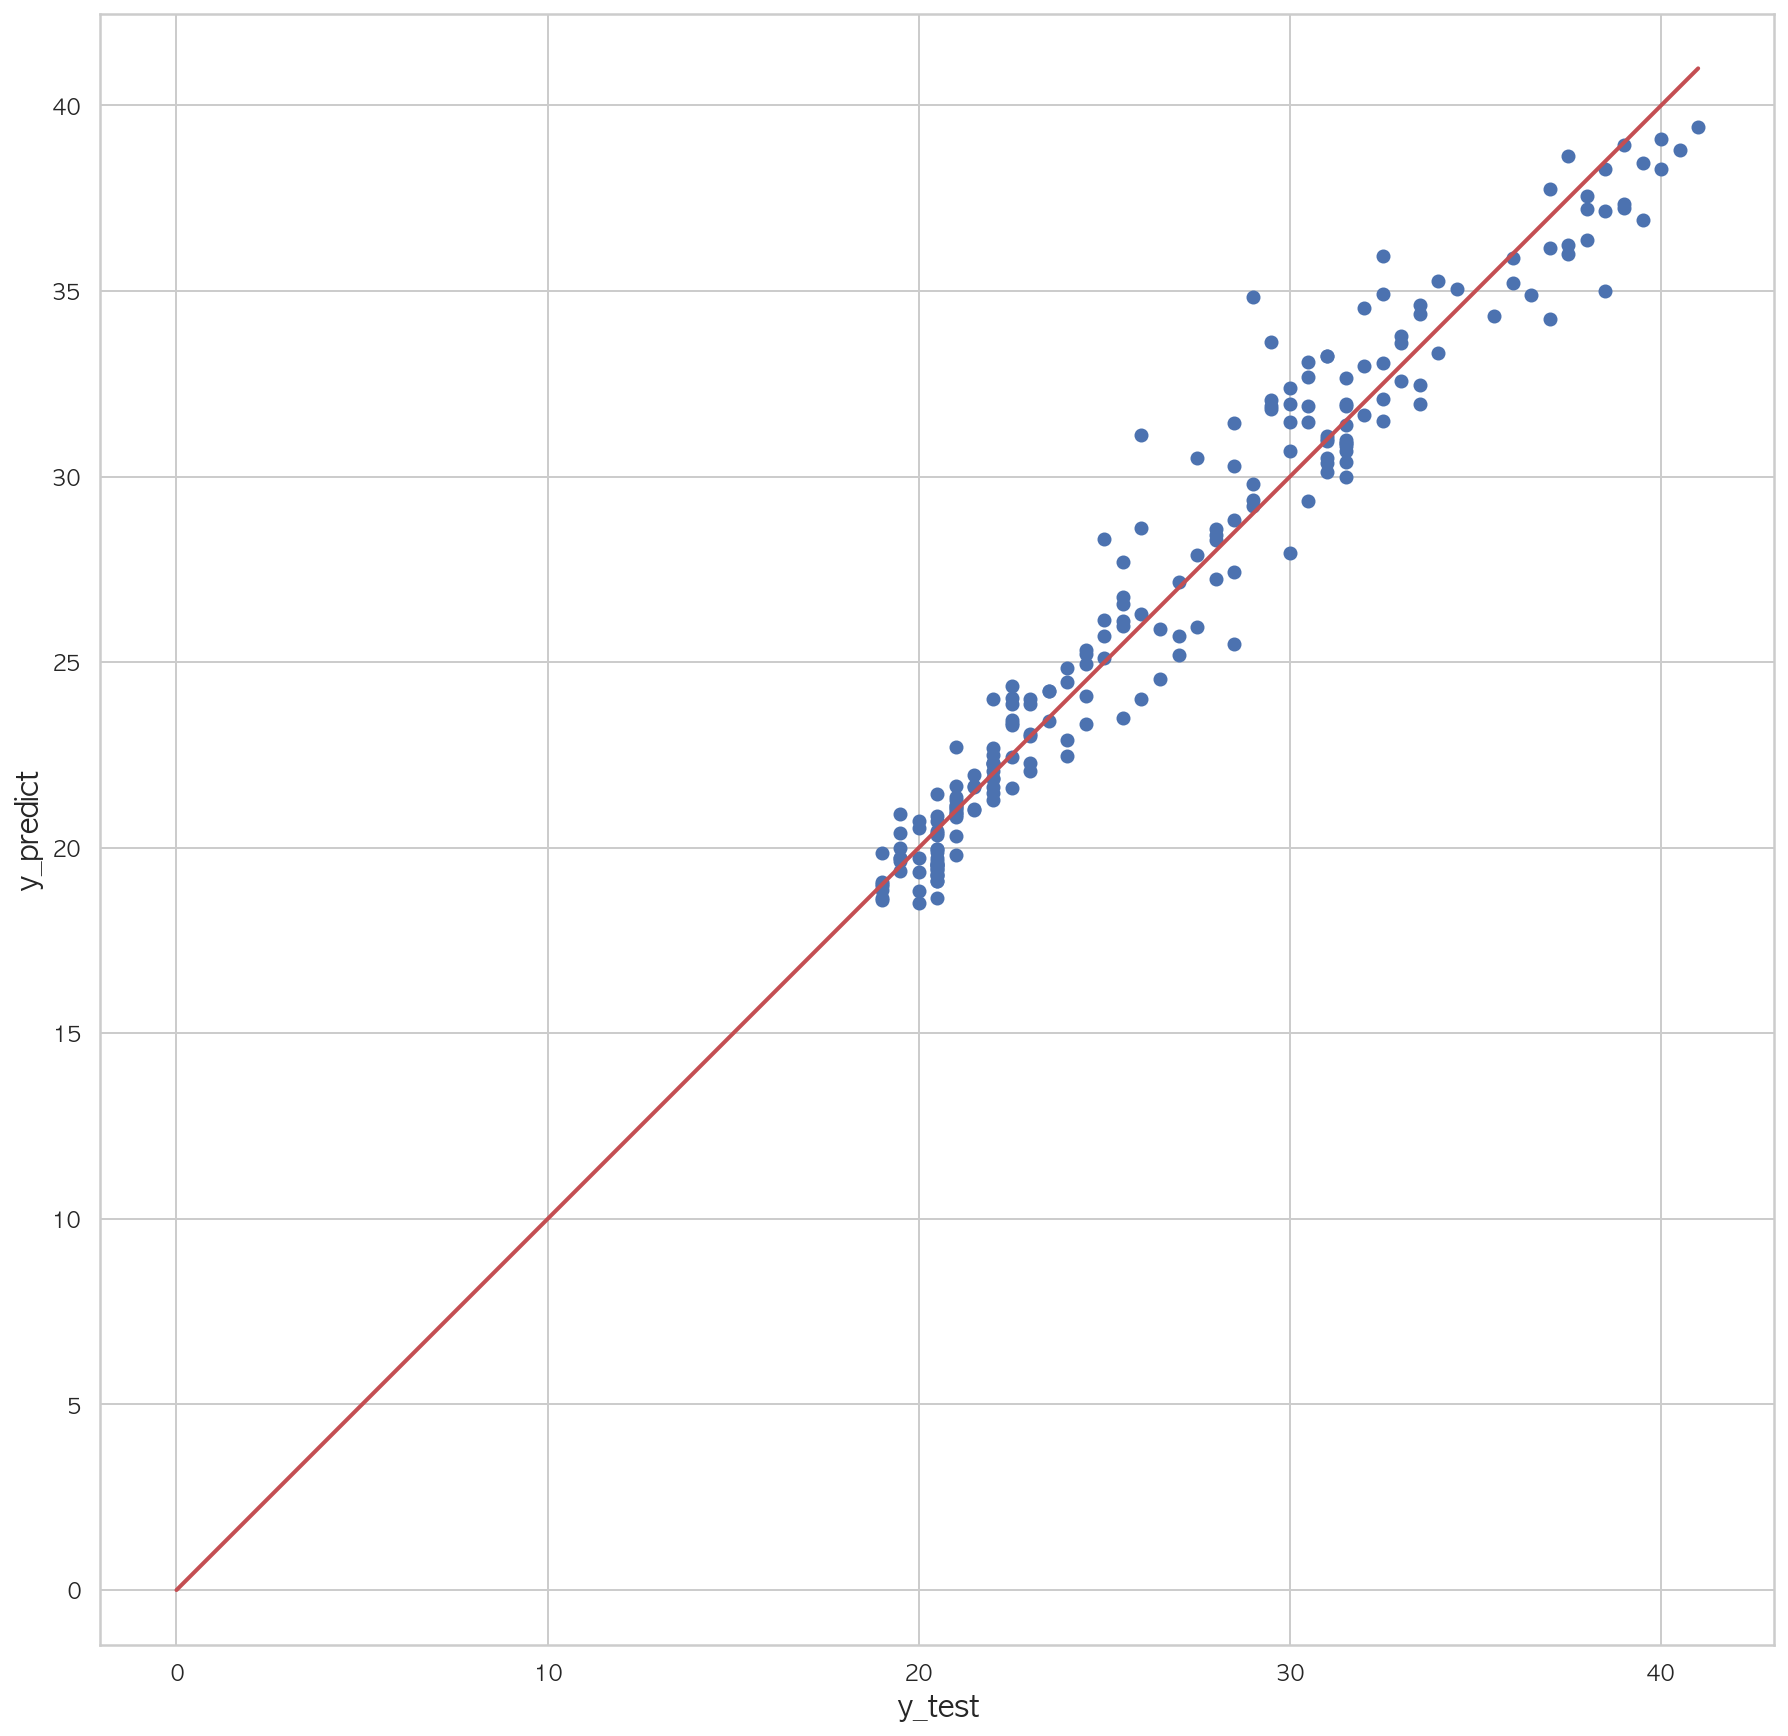

In [117]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y18'], pred)
plt.plot([0, dfX_test['Y18'].max()], [0, dfX_test['Y18'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

> ## accuracy_score와 mse가 좋게 나왔으나, 이를 활용해 구한 전체 데이터로 예측모델을 만들 경우 성능이 좋지 못함

> ## 다른 방법이 필요(Lasso, Ridge, EN)
- Ridge, Lasso, EN 정규화를 모두 사용했을 때 Lasso가 가장 좋은 성능을 가짐

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

X = Y_pred.drop(columns=['Y18'])
y = Y_pred['Y18']

alphas = np.logspace(-4, 0, 200)

train_scores = []
test_scores = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    train_score = -mean_squared_error(y, model.fit(X, y).predict(X))
    test_score = np.mean(cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)
print(optimal_alpha)

plt.plot(alphas, test_scores, "-", label="검증 성능")
plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

![title](lasso.png)

In [121]:
from sklearn.linear_model import Lasso, Ridge

X = dfX_train.drop(columns=['Y18'])
y = dfX_train['Y18']

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model18 = Lasso(0.172)
    model18.fit(X_train, y_train)
    pred = model18.predict(X_test)
    rss = ((y_test - pred) ** 2).sum()
    tss = ((y_test - y_test.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(model18.score(X_test, y_test), rsquared))


pred = model18.predict(dfX_test.drop(columns=['Y18']))
rss = ((dfX_test.Y18 - pred) ** 2).sum()
tss = ((dfX_test.Y18 - dfX_test.Y18.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)
print(mean_squared_error(dfX_test.Y18, pred))

학습 R2 = 0.92285981, 검증 R2 = 0.92285981
학습 R2 = 0.89027532, 검증 R2 = 0.89027532
학습 R2 = 0.94315430, 검증 R2 = 0.94315430
학습 R2 = 0.93493313, 검증 R2 = 0.93493313
학습 R2 = 0.90241774, 검증 R2 = 0.90241774
0.9127293186631104
3.2231797205211716


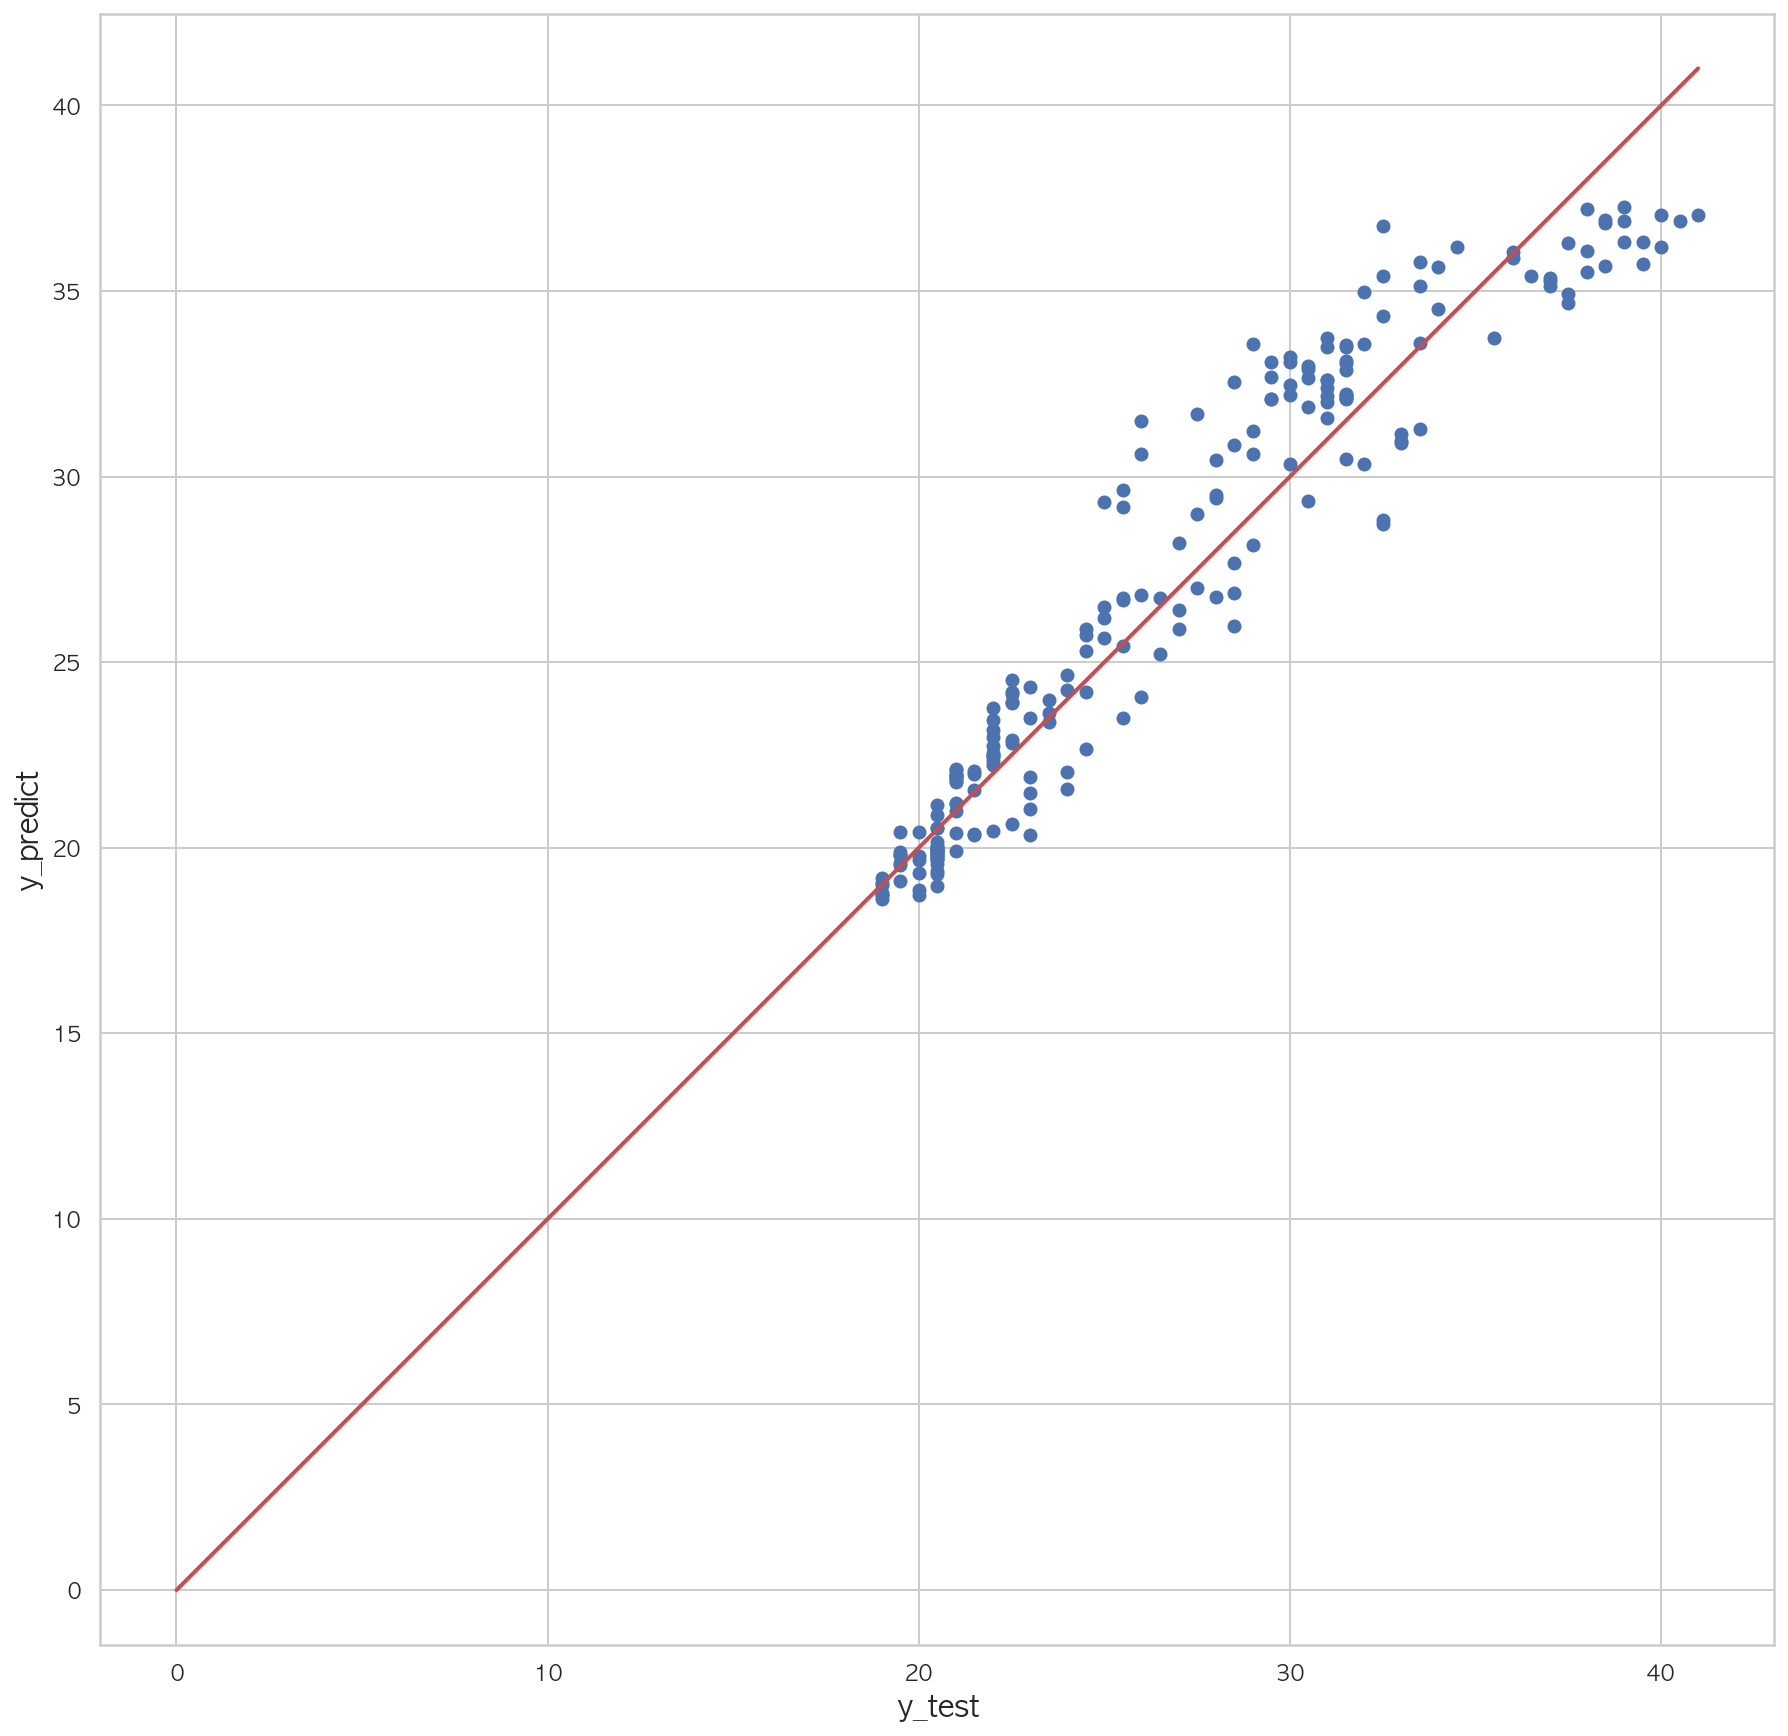

In [120]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y18'], pred)
plt.plot([0, dfX_test['Y18'].max()], [0, dfX_test['Y18'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

In [122]:
model18.fit(Y_pred.drop(columns=['Y18']), Y_pred['Y18'])

Lasso(alpha=0.172, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [131]:
c = sensor_name
c.append('hour')
c

['Y00',
 'Y01',
 'Y02',
 'Y03',
 'Y04',
 'Y05',
 'Y06',
 'Y07',
 'Y08',
 'Y09',
 'Y10',
 'Y11',
 'Y12',
 'Y13',
 'Y14',
 'Y15',
 'Y16',
 'Y17',
 'hour']

In [102]:
result20.predict(df1[c]).round(2)

0       11.30
1       13.29
2       10.72
3       12.32
4       11.70
        ...  
4315    22.28
4316    21.57
4317    19.64
4318    19.37
4319    18.30
Length: 4320, dtype: float64

In [132]:
X_30s['Y18'] = result20.predict(df1[c]).round(2)
X_30s

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X32,X33,X34,X35,X36,X37,X38,X39,hour,Y18
0,9.7,988.8,1.2,0.6,0,1009.3,989.6,12.2,1009.9,1009.8,...,10.7,1010.1,0.00,2,0,77.2,62.6,0,0,11.30
1,9.3,988.9,1.7,1.9,0,1009.3,989.6,12.1,1010.0,1009.9,...,10.3,1010.1,0.00,2,0,77.3,63.5,0,0,13.29
2,9.4,989.0,1.1,2.3,0,1009.2,989.7,12.1,1010.1,1010.1,...,9.7,1010.0,0.00,2,0,77.3,63.9,0,0,10.72
3,9.4,988.9,1.5,0.7,0,1009.2,989.6,12.0,1010.0,1010.0,...,9.4,1010.1,0.00,2,0,77.5,64.5,0,0,12.32
4,9.2,988.9,0.8,1.7,0,1009.2,989.7,12.0,1010.1,1010.0,...,9.4,1010.1,0.00,1,0,78.0,65.0,0,0,11.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,19.5,987.8,1.7,0.4,0,1007.8,988.0,21.3,1007.8,1007.5,...,19.4,1008.2,16.68,3,0,82.3,74.3,0,23,22.28
4316,19.3,987.7,2.1,0.9,0,1007.8,988.1,21.3,1008.0,1007.4,...,18.5,1008.4,16.68,3,0,82.4,74.8,0,23,21.57
4317,19.5,987.8,0.9,1.3,0,1007.8,988.3,21.2,1008.1,1007.5,...,19.1,1008.4,16.68,3,0,82.8,75.4,0,23,19.64
4318,20.0,987.8,1.4,0.5,0,1007.8,988.3,21.1,1008.1,1007.5,...,19.0,1008.4,16.68,3,0,82.8,75.8,0,23,19.37


> ## 이전 30일의 Y18 예측

In [133]:
X_30s['Y18'] = model18.predict(df1[c]).round(2)
X_30s

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X32,X33,X34,X35,X36,X37,X38,X39,hour,Y18
0,9.7,988.8,1.2,0.6,0,1009.3,989.6,12.2,1009.9,1009.8,...,10.7,1010.1,0.00,2,0,77.2,62.6,0,0,10.42
1,9.3,988.9,1.7,1.9,0,1009.3,989.6,12.1,1010.0,1009.9,...,10.3,1010.1,0.00,2,0,77.3,63.5,0,0,10.41
2,9.4,989.0,1.1,2.3,0,1009.2,989.7,12.1,1010.1,1010.1,...,9.7,1010.0,0.00,2,0,77.3,63.9,0,0,9.81
3,9.4,988.9,1.5,0.7,0,1009.2,989.6,12.0,1010.0,1010.0,...,9.4,1010.1,0.00,2,0,77.5,64.5,0,0,9.94
4,9.2,988.9,0.8,1.7,0,1009.2,989.7,12.0,1010.1,1010.0,...,9.4,1010.1,0.00,1,0,78.0,65.0,0,0,9.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,19.5,987.8,1.7,0.4,0,1007.8,988.0,21.3,1007.8,1007.5,...,19.4,1008.2,16.68,3,0,82.3,74.3,0,23,21.12
4316,19.3,987.7,2.1,0.9,0,1007.8,988.1,21.3,1008.0,1007.4,...,18.5,1008.4,16.68,3,0,82.4,74.8,0,23,20.91
4317,19.5,987.8,0.9,1.3,0,1007.8,988.3,21.2,1008.1,1007.5,...,19.1,1008.4,16.68,3,0,82.8,75.4,0,23,20.65
4318,20.0,987.8,1.4,0.5,0,1007.8,988.3,21.1,1008.1,1007.5,...,19.0,1008.4,16.68,3,0,82.8,75.8,0,23,20.66


In [134]:
X_3s['Y18'] = df2['Y18']
X_3s

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X32,X33,X34,X35,X36,X37,X38,X39,hour,Y18
4320,19.3,987.7,0.9,2.2,0,1007.7,988.0,20.8,1007.8,1007.4,...,18.7,1008.3,0.00,3,0,84.0,77.6,0,0,20.5
4321,19.0,987.6,1.9,2.2,0,1007.7,988.0,20.6,1007.8,1007.4,...,19.0,1008.3,0.00,3,0,84.4,79.2,0,0,20.5
4322,19.1,987.6,2.0,1.4,0,1007.8,988.1,20.5,1007.9,1007.4,...,19.2,1008.3,0.00,3,0,84.9,79.9,0,0,20.5
4323,19.2,987.7,1.8,1.5,0,1007.9,988.1,20.5,1007.9,1007.5,...,19.3,1008.4,0.00,3,0,84.9,80.7,0,0,20.5
4324,19.2,987.8,1.4,1.4,0,1007.9,988.1,20.5,1007.8,1007.6,...,19.5,1008.4,0.00,3,0,84.9,80.9,0,0,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,19.9,987.6,0.9,0.8,0,1006.9,987.7,21.7,1007.5,1007.4,...,19.1,1007.5,22.16,2,0,82.3,58.6,1,23,21.5
4748,19.9,987.6,0.5,0.7,0,1006.8,987.7,21.6,1007.5,1007.4,...,19.2,1007.5,22.16,1,0,82.5,59.1,1,23,21.5
4749,19.7,987.7,0.9,0.6,0,1006.9,987.6,21.4,1007.4,1007.5,...,19.2,1007.5,22.16,2,0,83.0,58.9,1,23,21.5
4750,19.4,987.7,0.9,0.8,0,1006.9,987.8,21.3,1007.6,1007.5,...,19.3,1007.6,22.16,3,0,83.2,59.8,1,23,21.5


> ## 전체 X데이터로 Y18 예측모델 만들기

In [135]:
all_X = pd.concat([X_30s, X_3s])
all_X

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X32,X33,X34,X35,X36,X37,X38,X39,hour,Y18
0,9.7,988.8,1.2,0.6,0,1009.3,989.6,12.2,1009.9,1009.8,...,10.7,1010.1,0.00,2,0,77.2,62.6,0,0,10.42
1,9.3,988.9,1.7,1.9,0,1009.3,989.6,12.1,1010.0,1009.9,...,10.3,1010.1,0.00,2,0,77.3,63.5,0,0,10.41
2,9.4,989.0,1.1,2.3,0,1009.2,989.7,12.1,1010.1,1010.1,...,9.7,1010.0,0.00,2,0,77.3,63.9,0,0,9.81
3,9.4,988.9,1.5,0.7,0,1009.2,989.6,12.0,1010.0,1010.0,...,9.4,1010.1,0.00,2,0,77.5,64.5,0,0,9.94
4,9.2,988.9,0.8,1.7,0,1009.2,989.7,12.0,1010.1,1010.0,...,9.4,1010.1,0.00,1,0,78.0,65.0,0,0,9.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,19.9,987.6,0.9,0.8,0,1006.9,987.7,21.7,1007.5,1007.4,...,19.1,1007.5,22.16,2,0,82.3,58.6,1,23,21.50
4748,19.9,987.6,0.5,0.7,0,1006.8,987.7,21.6,1007.5,1007.4,...,19.2,1007.5,22.16,1,0,82.5,59.1,1,23,21.50
4749,19.7,987.7,0.9,0.6,0,1006.9,987.6,21.4,1007.4,1007.5,...,19.2,1007.5,22.16,2,0,83.0,58.9,1,23,21.50
4750,19.4,987.7,0.9,0.8,0,1006.9,987.8,21.3,1007.6,1007.5,...,19.3,1007.6,22.16,3,0,83.2,59.8,1,23,21.50


In [137]:
N = len(all_X)
ratio = 0.7
np.random.seed(0)
idx_train = np.random.choice(np.arange(N), np.int(ratio * N))
idx_test = list(set(np.arange(N)).difference(idx_train))

dfX_train = all_X.iloc[idx_train]
dfX_test = all_X.iloc[idx_test]

> ## Y18 OLS report

In [138]:
model18 = sm.OLS.from_formula("Y18 ~ 1 +" + a, data=dfX_train)
result18 = model18.fit()
print(result18.summary())

                            OLS Regression Results                            
Dep. Variable:                    Y18   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1472.
Date:                Sat, 18 Apr 2020   Prob (F-statistic):               0.00
Time:                        02:27:53   Log-Likelihood:                -5817.7
No. Observations:                3326   AIC:                         1.177e+04
Df Residuals:                    3260   BIC:                         1.217e+04
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        21.9494      0.179    122.879

In [141]:
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=13)
for i, (idx_train, idx_test) in enumerate(cv.split(dfX_train)):
    df_train = dfX_train.iloc[idx_train]
    df_test = dfX_train.iloc[idx_test]
    
    model18 = sm.OLS.from_formula("Y18 ~ 1 +" + a, data=dfX_train)
    result18 = model18.fit()
    
    pred = result18.predict(df_test)
    rss = ((df_test.Y18 - pred) ** 2).sum()
    tss = ((df_test.Y18 - df_test.Y18.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result18.rsquared, rsquared))

pred = result18.predict(dfX_test)
rss = ((dfX_test.Y18 - pred) ** 2).sum()
tss = ((dfX_test.Y18 - dfX_test.Y18.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)
print(mean_squared_error(dfX_test.Y18, pred))

학습 R2 = 0.96704763, 검증 R2 = 0.96344232
학습 R2 = 0.96704763, 검증 R2 = 0.96605570
학습 R2 = 0.96704763, 검증 R2 = 0.96840262
학습 R2 = 0.96704763, 검증 R2 = 0.96691297
학습 R2 = 0.96704763, 검증 R2 = 0.96968124
0.9643708671481441
1.9913783582763236


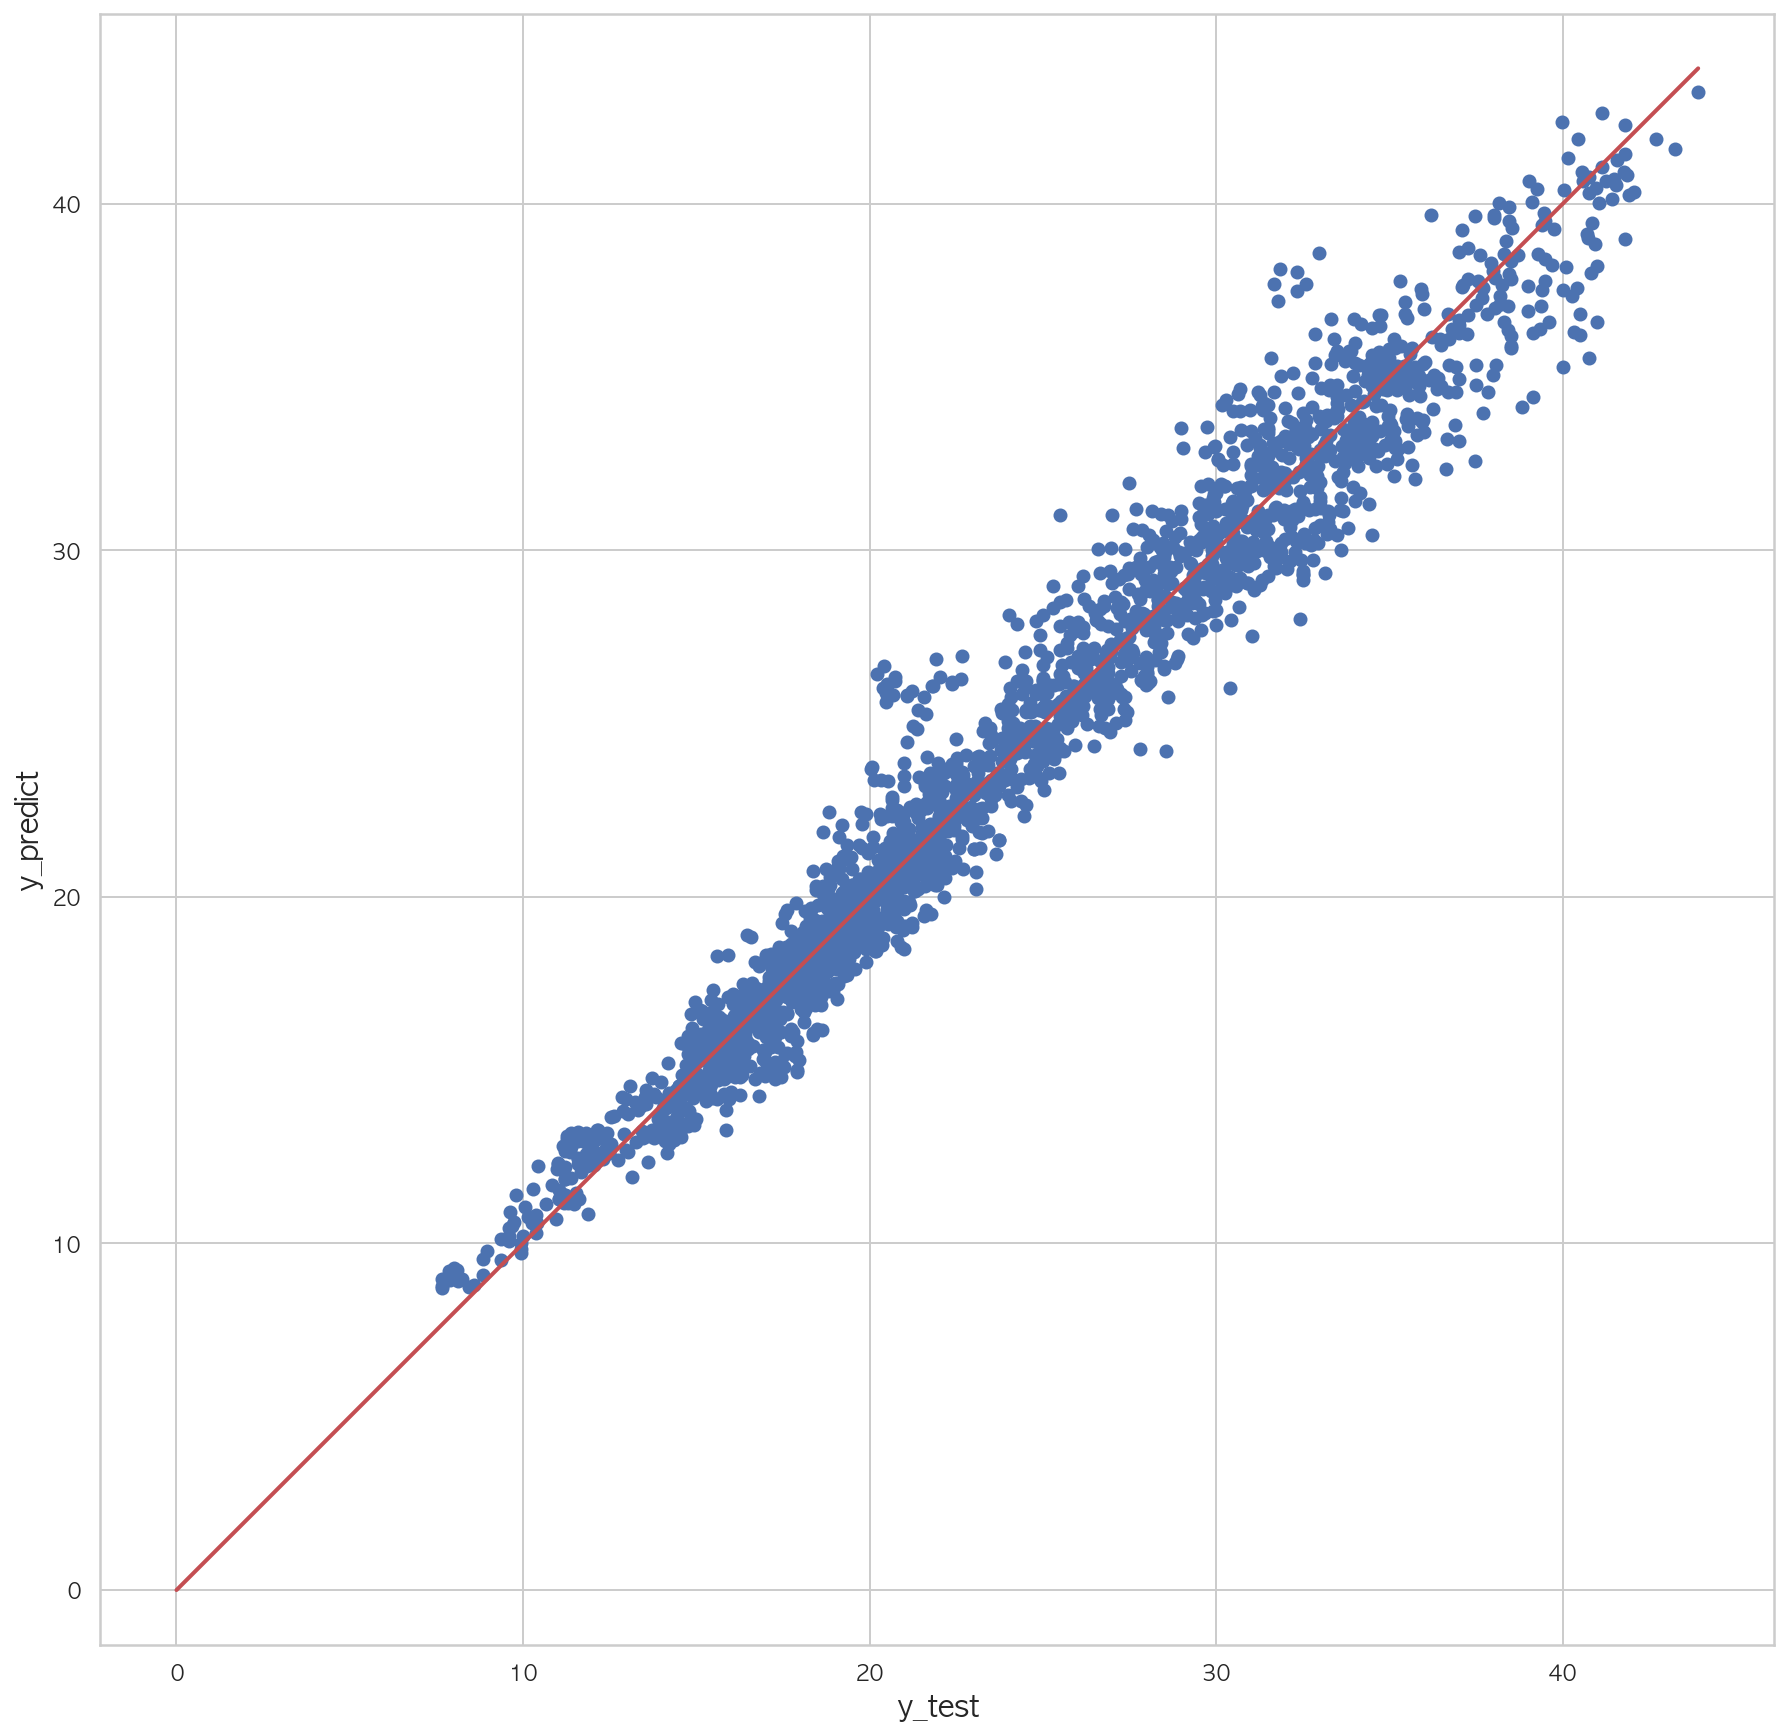

In [142]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y18'], pred)
plt.plot([0, dfX_test['Y18'].max()], [0, dfX_test['Y18'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

> ## 테스트 결과는?

![title](formula.png)

> ## Lasso는 어떨까?

0.01289890261253308


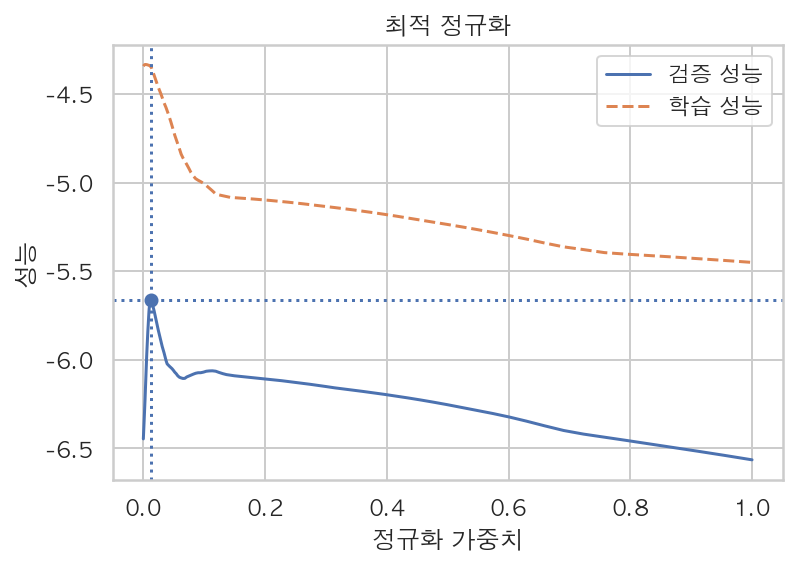

In [143]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

X = all_X.drop(columns=['Y18'])
y = all_X['Y18']

alphas = np.logspace(-4, 0, 200)

train_scores = []
test_scores = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    train_score = -mean_squared_error(y, model.fit(X, y).predict(X))
    test_score = np.mean(cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)
print(optimal_alpha)

plt.plot(alphas, test_scores, "-", label="검증 성능")
plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

In [145]:
X = dfX_train.drop(columns=['Y18'])
y = dfX_train['Y18']

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model18 = Lasso(0.012)
    model18.fit(X_train, y_train)
    pred = model18.predict(X_test)
    rss = ((y_test - pred) ** 2).sum()
    tss = ((y_test - y_test.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(model18.score(X_test, y_test), rsquared))


pred = model18.predict(dfX_test.drop(columns=['Y18']))
rss = ((dfX_test.Y18 - pred) ** 2).sum()
tss = ((dfX_test.Y18 - dfX_test.Y18.mean())** 2).sum()
rsquared = 1 - rss / tss
print(rsquared)
print(mean_squared_error(dfX_test.Y18, pred))

학습 R2 = 0.92249209, 검증 R2 = 0.92249209
학습 R2 = 0.91956967, 검증 R2 = 0.91956967
학습 R2 = 0.92019706, 검증 R2 = 0.92019706
학습 R2 = 0.92395915, 검증 R2 = 0.92395915
학습 R2 = 0.92177100, 검증 R2 = 0.92177100
0.9246531552968336
4.2112749847201885


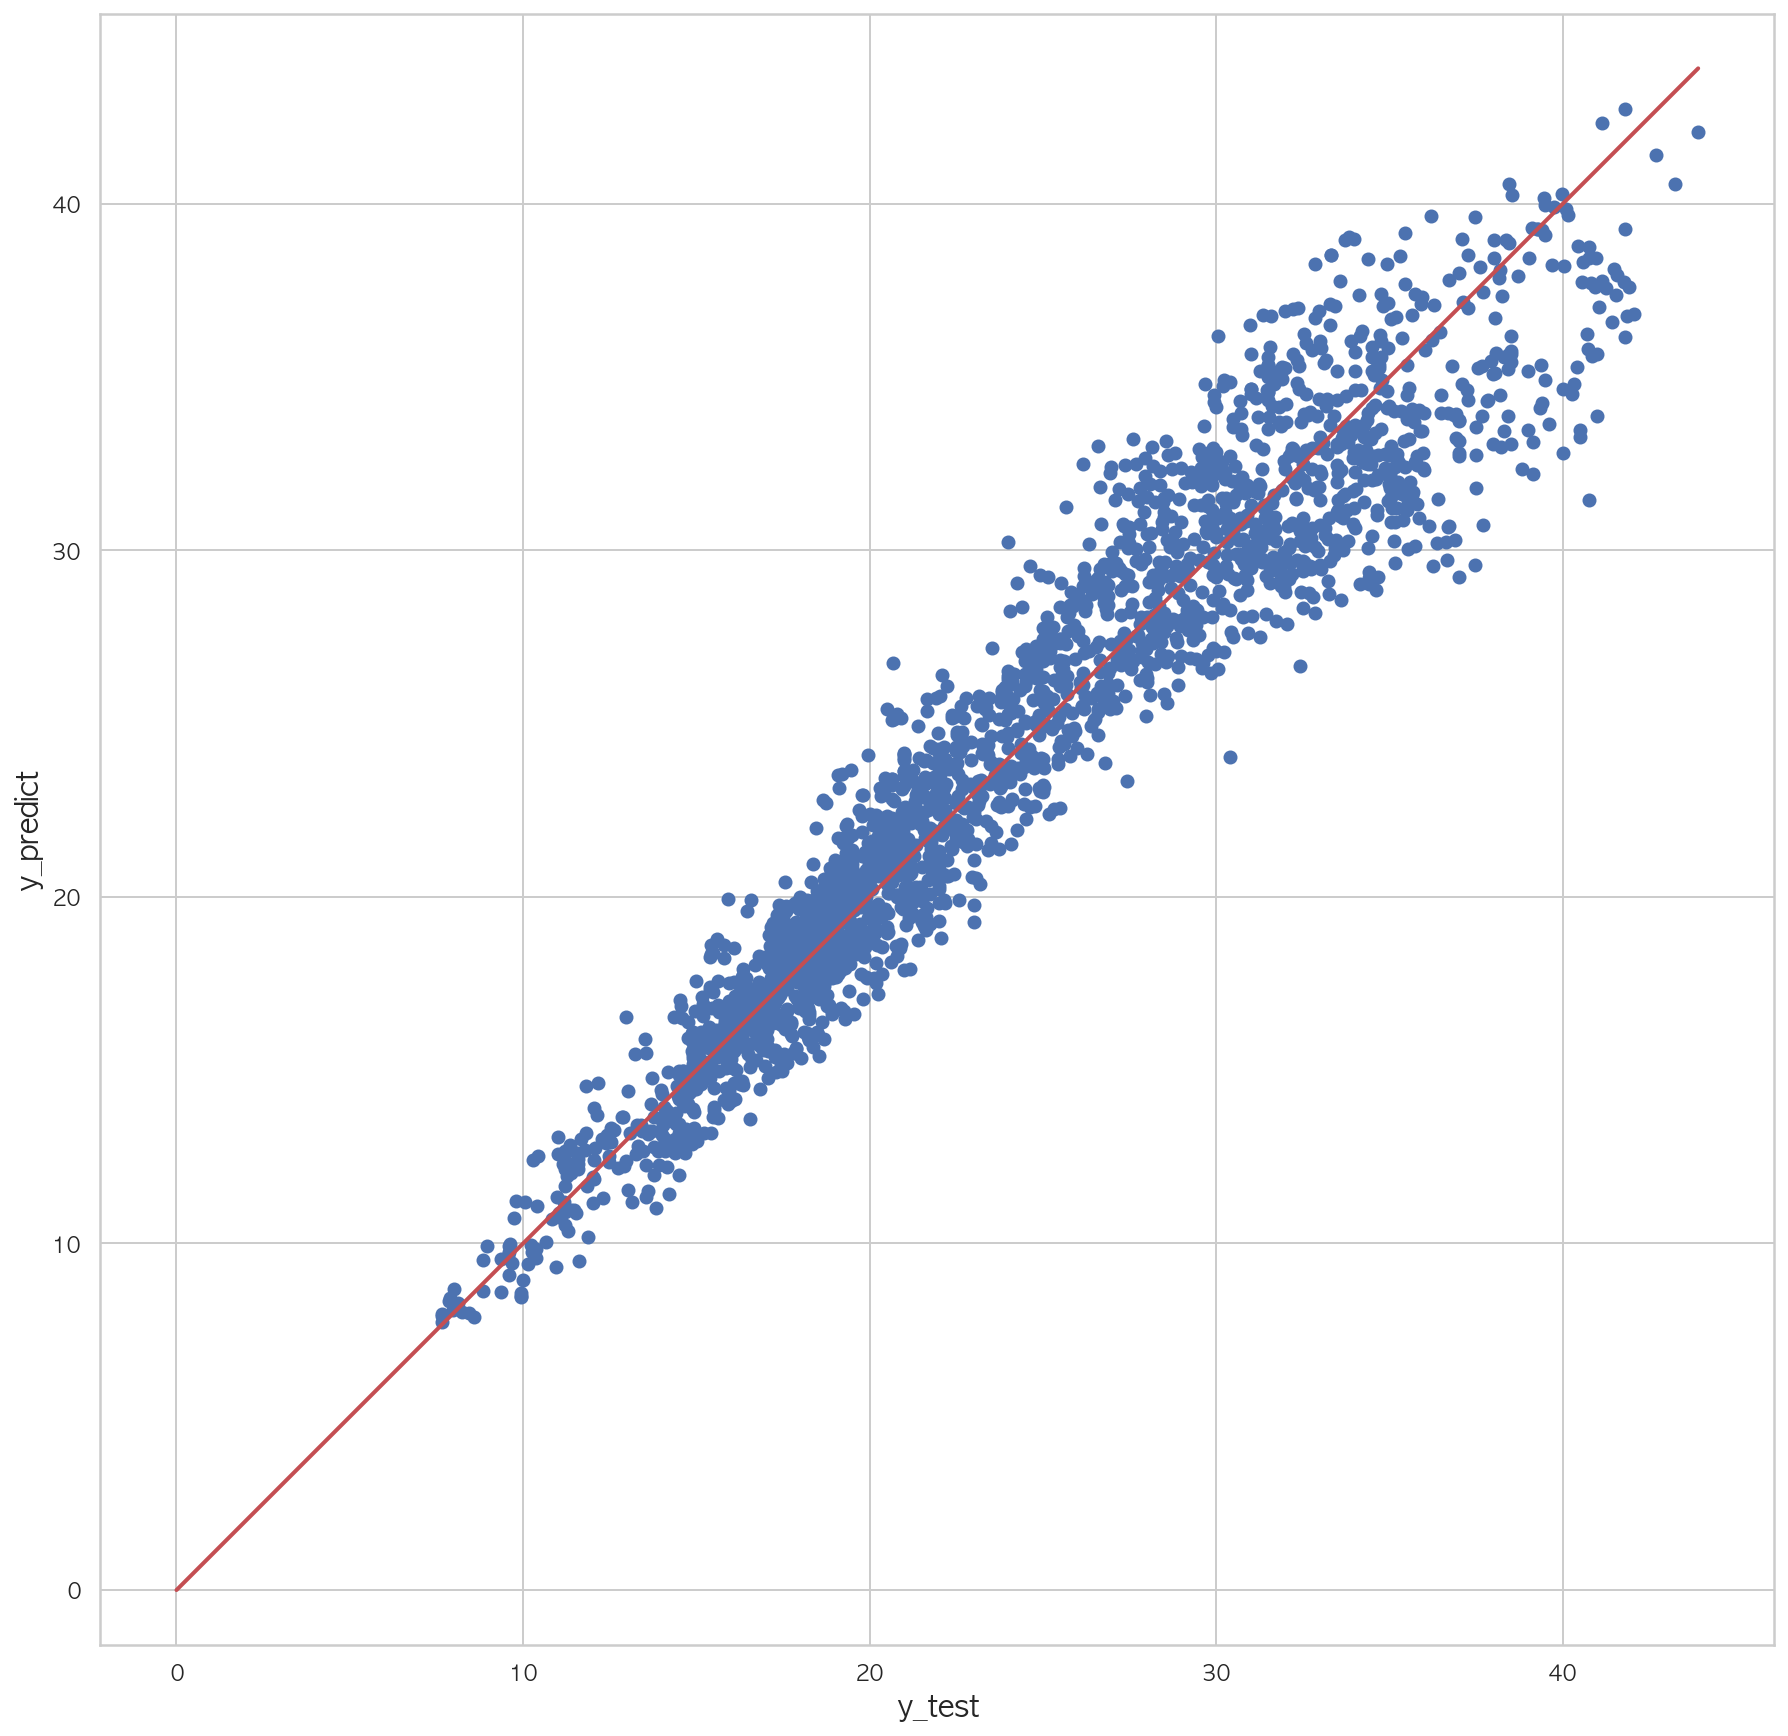

In [146]:
plt.figure(figsize=(15,15))
plt.scatter(dfX_test['Y18'], pred)
plt.plot([0, dfX_test['Y18'].max()], [0, dfX_test['Y18'].max()], "r", lw=2)
plt.xlabel("y_test", fontsize=15)
plt.ylabel("y_predict", fontsize=15)
plt.axis("equal")
plt.show()

> ## 테스트 결과는?
- OLS 보다 더 안좋게 나왔다.

![title](lasso_.png)

> ## 시도해 본 모델들
- **각 측정영역 별 평균 모델(잘못된 방법)**
    - MSE : 4.60
- **OLS 모델**
    - MSE : 5.46
- **Lasso 모델**
    - MSE : 6.75
- **OLS + Lasso + OLS 모델**
    - MSE : 3.99
- **OLS + Lasso + Lasso 모델**
    - MSE = 5.30

> ## + 성능의 향상을 위해! 머신러닝 기법 적용
- LGBM, RandomForestRegressor
    - RandomForestRegressor 성능이 제일 좋았음

> ## RandomForestRegressor

In [105]:
X = all_X.drop(['Y18'], axis=1)
y = all_X['Y18']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [106]:
rf_reg = RandomForestRegressor(random_state=13, n_jobs=-1, bootstrap=False, criterion='mse')

In [170]:
# def MSE(y_true,y_pred):
#     mse = mean_squared_error(y_true, y_pred)
#     print('MSE: %2.3f' % mse)
#     return mse

In [175]:
# params = {
#     'max_depth' : [6, 8, 10, 12, 16, 20, 24],
#     'n_estimators': [50, 100, 150, 200],
#     'min_samples_leaf': [8, 12],
#     'min_samples_split': [8, 12]
# }

# grid_cv = GridSearchCV(rf_reg, param_grid=params, cv=5, scoring=make_scorer(MSE, greater_is_better=False), return_train_score=True, n_jobs=-1)
# grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=13,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-

In [107]:
params = {
    'max_depth' : [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70],
    'max_features' : [10, 20, 30, 35, 40, 45, 50, 55],
    'n_estimators': [50, 100, 150, 200],
    'min_samples_leaf': [8, 12],
    'min_samples_split': [8, 12],
}

grid_cv = GridSearchCV(rf_reg, param_grid=params, cv=5, return_train_score=True, n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=13,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [108]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'param_min_samples_split', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [109]:
cols = ['rank_test_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth']
cv_results_df[cols].sort_values('rank_test_score')

,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
1047,1,0.930728,200,50
1431,1,0.930728,200,70
919,1,0.930728,200,45
1303,1,0.930728,200,60
915,1,0.930728,200,45
...,...,...,...,...
730,1532,NaN,150,35
731,1533,NaN,200,35
732,1534,NaN,50,35
1022,1535,NaN,150,45


In [110]:
grid_cv.best_params_

{'max_depth': 25,
 'max_features': 20,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 200}

In [111]:
grid_cv.best_score_

0.9307276554332164

In [112]:
rf_reg_best = grid_cv.best_estimator_
rf_reg_best.fit(X_train, y_train)

pred = rf_reg_best.predict(X_test)

print(mean_squared_error(y_test, pred))

3.5975712904104613


> ## 전체 모델 만들어 Test 데이터에 적용

In [114]:
params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24],
    'n_estimators': [50, 100, 150, 200],
    'min_samples_leaf': [8, 12],
    'min_samples_split': [8, 12]
}

grid_cv = GridSearchCV(rf_reg, param_grid=params, cv=5, return_train_score=True, n_jobs=-1)
grid_cv.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=13,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-

In [115]:
grid_cv.best_params_

{'max_depth': 16,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 100}

In [116]:
grid_cv.best_score_

0.9558424688563008

In [117]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [118]:
cols = ['rank_test_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth']
cv_results_df[cols].sort_values('rank_test_score')

,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
65,1,0.955842,100,16
69,1,0.955842,100,16
81,3,0.955842,100,20
101,3,0.955842,100,24
85,3,0.955842,100,20
...,...,...,...,...
11,107,0.947681,200,6
8,109,0.947502,50,6
12,109,0.947502,50,6
4,111,0.947374,50,6


In [113]:
rf_reg_best = grid_cv.best_estimator_
rf_reg_best.fit(X, y)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=20, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=13, verbose=0, warm_start=False)

In [72]:
test = pd.read_csv('datas/test.csv', encoding='utf-8')

In [73]:
hour= pd.Series((test.index%144/6).astype(int))
test['hour'] = list(hour)

In [74]:
test1 = test.drop(columns=['X14', 'X16', 'X19', 'id'], axis=1)

In [75]:
for x in direction_name:
    test1[x] = test1[x].apply(lambda x: 0 if x < 90 else 1 if x < 180 else 2 if x < 270 else 3)
# 북동 : 0 / 남동 : 1 / 남서 : 2 / 북서 : 3

In [76]:
for x in water_name:
    for i in range(1, len(x)):
        test1[x].loc[i] = test1[x].loc[i] - test1[x].loc[i-1]

In [77]:
for x in water_name:
    test1[x] = test1[x].apply(lambda x: 0 if x == 0  else 1)

> ## TEST 데이터

In [78]:
test1

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X31,X32,X33,X34,X35,X36,X37,X38,X39,hour
0,18.7,987.4,1.5,1.3,0,1006.8,987.7,21.1,1007.5,1007.2,...,17.5,19.2,1007.6,0.00,2,0,84.0,59.9,0,0
1,18.8,987.4,1.1,1.2,0,1006.7,987.7,21.2,1007.5,1007.2,...,17.4,19.1,1007.5,0.00,1,0,84.0,60.5,0,0
2,19.0,987.4,1.3,1.2,0,1006.6,987.6,21.2,1007.4,1007.2,...,17.2,19.0,1007.5,0.00,2,0,85.0,60.8,0,0
3,18.7,987.4,2.3,0.8,0,1006.6,987.6,21.1,1007.4,1007.2,...,17.2,18.8,1007.4,0.00,2,0,85.8,61.2,0,0
4,18.4,987.4,1.1,0.7,0,1006.7,987.7,20.9,1007.5,1007.2,...,17.4,18.9,1007.5,0.00,1,0,87.3,61.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,25.7,993.2,3.9,3.8,0,1011.7,993.8,26.3,1013.3,1012.6,...,23.6,24.4,1013.0,19.56,1,0,79.7,67.5,1,23
11516,25.6,993.2,3.0,3.0,0,1011.7,993.8,26.3,1013.3,1012.6,...,25.3,24.4,1012.9,19.56,1,0,79.6,67.9,1,23
11517,25.6,993.2,3.8,2.5,0,1011.9,993.7,26.2,1013.2,1012.7,...,24.9,24.3,1012.9,19.56,2,0,79.2,68.3,1,23
11518,25.5,993.2,2.4,2.8,0,1011.8,993.7,26.1,1013.2,1012.6,...,25.3,24.2,1012.9,19.56,1,0,80.1,68.8,1,23


In [119]:
answer = rf_reg_best.predict(test1).round(2) - 0.5
answer

array([19.62, 19.61, 19.61, ..., 26.06, 24.58, 24.46])

> ## 결과는?

![title](rf.png)
![title](final.png)

In [120]:
answer_df = pd.DataFrame(answer)
answer_df.rename(columns={
    0 : 'Y18'
}, inplace=True)

In [121]:
answer_df['id'] = test['id']
answer_df = answer_df[['id', 'Y18']]

In [122]:
answer_df.to_csv('submission_0412.csv', index=False, encoding='utf-8')

In [123]:
answer_df

,id,Y18
0,4752,19.62
1,4753,19.61
2,4754,19.61
3,4755,18.68
4,4756,19.52
...,...,...
11515,16267,25.63
11516,16268,26.11
11517,16269,26.06
11518,16270,24.58
